# Thumbnail.ipynb
## Trains DCGAN on Fetched Thumbnails 

### DCGAN Code By https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

# Imports

In [1]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from matplotlib.animation import FuncAnimation

# DCGAN (modified for thumbnail samples)

In [2]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 80
        self.img_cols = 80
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 20 * 20, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((20, 20, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, training_data, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        X_train = training_data * 2 - 1

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("dcgan/dcgan_%d.png" % epoch)
        plt.close()
    
    def save_model(self):
        model_json = self.generator.to_json()
        with open("thumbnail_model.json", "w") as json_file:
            json_file.write(model_json)
        self.generator.save_weights("thumbnail_model.h5")

# Reads and Converts Thumbnails to Black and White

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [4]:
image = []
for file in os.listdir("../data/thumbnails_png_square"):
    if file.endswith(".png"):
        img = plt.imread("../data/thumbnails_png_square/" + file)
        image.append(rgb2gray(img)[:,:])

# DCGAN Training using Thumbnails

In [6]:
gan = DCGAN()
gan.train(training_data=np.array(image).reshape(-1,80,80,1), epochs=4000, batch_size=32, save_interval=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 40, 40, 32)        320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 21, 21, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 21, 21, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 21, 21, 64)        0         
__________

9 [D loss: 0.386939, acc.: 87.50%] [G loss: 0.627877]
10 [D loss: 0.144990, acc.: 93.75%] [G loss: 0.370219]
11 [D loss: 0.212600, acc.: 90.62%] [G loss: 0.453855]
12 [D loss: 0.119088, acc.: 96.88%] [G loss: 0.471007]
13 [D loss: 0.443479, acc.: 78.12%] [G loss: 0.526641]
14 [D loss: 0.656419, acc.: 76.56%] [G loss: 0.518752]
15 [D loss: 0.848301, acc.: 60.94%] [G loss: 0.831409]
16 [D loss: 0.316809, acc.: 84.38%] [G loss: 1.615985]
17 [D loss: 1.232987, acc.: 39.06%] [G loss: 1.406199]
18 [D loss: 1.230577, acc.: 40.62%] [G loss: 2.505548]
19 [D loss: 0.764420, acc.: 60.94%] [G loss: 1.994765]
20 [D loss: 1.080140, acc.: 51.56%] [G loss: 2.082555]
21 [D loss: 1.161497, acc.: 39.06%] [G loss: 2.677049]
22 [D loss: 0.648111, acc.: 71.88%] [G loss: 3.316318]
23 [D loss: 1.020535, acc.: 42.19%] [G loss: 3.262663]
24 [D loss: 0.887771, acc.: 62.50%] [G loss: 3.365337]
25 [D loss: 0.823403, acc.: 57.81%] [G loss: 3.264335]
26 [D loss: 1.470010, acc.: 23.44%] [G loss: 3.040298]
27 [D loss:

31 [D loss: 0.863960, acc.: 56.25%] [G loss: 3.027349]
32 [D loss: 1.236943, acc.: 39.06%] [G loss: 3.025708]
33 [D loss: 0.523331, acc.: 78.12%] [G loss: 2.958749]
34 [D loss: 0.854636, acc.: 46.88%] [G loss: 2.855968]
35 [D loss: 0.953726, acc.: 57.81%] [G loss: 2.727197]
36 [D loss: 0.561553, acc.: 73.44%] [G loss: 2.545187]
37 [D loss: 0.758886, acc.: 51.56%] [G loss: 1.984488]
38 [D loss: 0.613834, acc.: 75.00%] [G loss: 1.092942]
39 [D loss: 0.327267, acc.: 90.62%] [G loss: 0.879262]
40 [D loss: 0.473202, acc.: 73.44%] [G loss: 1.506671]
41 [D loss: 1.017650, acc.: 51.56%] [G loss: 1.407582]
42 [D loss: 1.031484, acc.: 53.12%] [G loss: 3.045796]
43 [D loss: 1.203102, acc.: 54.69%] [G loss: 2.624868]
44 [D loss: 0.372551, acc.: 89.06%] [G loss: 3.382041]
45 [D loss: 0.322005, acc.: 92.19%] [G loss: 3.456978]
46 [D loss: 0.489147, acc.: 73.44%] [G loss: 3.589727]
47 [D loss: 0.582592, acc.: 65.62%] [G loss: 3.937012]
48 [D loss: 1.082380, acc.: 45.31%] [G loss: 3.274352]
49 [D loss

53 [D loss: 1.306995, acc.: 35.94%] [G loss: 3.040957]
54 [D loss: 0.665958, acc.: 71.88%] [G loss: 2.876646]
55 [D loss: 0.775482, acc.: 59.38%] [G loss: 2.343974]
56 [D loss: 0.729827, acc.: 75.00%] [G loss: 2.749804]
57 [D loss: 0.562799, acc.: 75.00%] [G loss: 3.154502]
58 [D loss: 0.836772, acc.: 68.75%] [G loss: 3.456676]
59 [D loss: 0.891533, acc.: 57.81%] [G loss: 2.894800]
60 [D loss: 0.792686, acc.: 71.88%] [G loss: 2.156348]
61 [D loss: 0.595569, acc.: 65.62%] [G loss: 1.858588]
62 [D loss: 0.277516, acc.: 87.50%] [G loss: 1.869738]
63 [D loss: 0.436256, acc.: 76.56%] [G loss: 1.794456]
64 [D loss: 0.545422, acc.: 79.69%] [G loss: 1.742678]
65 [D loss: 1.341240, acc.: 28.12%] [G loss: 2.001150]
66 [D loss: 1.311792, acc.: 37.50%] [G loss: 2.470938]
67 [D loss: 0.994126, acc.: 46.88%] [G loss: 2.876134]
68 [D loss: 0.872437, acc.: 56.25%] [G loss: 2.688788]
69 [D loss: 0.636096, acc.: 70.31%] [G loss: 2.853705]
70 [D loss: 1.202743, acc.: 34.38%] [G loss: 2.446920]
71 [D loss

75 [D loss: 1.098205, acc.: 37.50%] [G loss: 2.037052]
76 [D loss: 1.058010, acc.: 45.31%] [G loss: 1.685256]
77 [D loss: 0.754625, acc.: 60.94%] [G loss: 1.800796]
78 [D loss: 1.505923, acc.: 21.88%] [G loss: 1.459799]
79 [D loss: 0.827824, acc.: 54.69%] [G loss: 1.702640]
80 [D loss: 0.743187, acc.: 64.06%] [G loss: 1.002130]
81 [D loss: 1.670079, acc.: 34.38%] [G loss: 1.320313]
82 [D loss: 1.079614, acc.: 71.88%] [G loss: 1.034494]
83 [D loss: 1.264257, acc.: 39.06%] [G loss: 1.177251]
84 [D loss: 0.747838, acc.: 59.38%] [G loss: 0.708410]
85 [D loss: 1.822369, acc.: 25.00%] [G loss: 1.264293]
86 [D loss: 1.336450, acc.: 32.81%] [G loss: 2.158181]
87 [D loss: 1.931147, acc.: 15.62%] [G loss: 2.418029]
88 [D loss: 1.175866, acc.: 45.31%] [G loss: 1.593643]
89 [D loss: 0.698441, acc.: 68.75%] [G loss: 1.111601]
90 [D loss: 0.613348, acc.: 68.75%] [G loss: 0.878570]
91 [D loss: 0.447839, acc.: 78.12%] [G loss: 0.384527]
92 [D loss: 0.878915, acc.: 48.44%] [G loss: 0.195268]
93 [D loss

97 [D loss: 0.347147, acc.: 85.94%] [G loss: 0.376264]
98 [D loss: 0.628032, acc.: 67.19%] [G loss: 0.844118]
99 [D loss: 1.290380, acc.: 34.38%] [G loss: 0.317635]
100 [D loss: 0.791845, acc.: 59.38%] [G loss: 0.528103]
101 [D loss: 1.289400, acc.: 31.25%] [G loss: 0.501045]
102 [D loss: 2.067934, acc.: 10.94%] [G loss: 0.711090]
103 [D loss: 1.329141, acc.: 31.25%] [G loss: 0.565271]
104 [D loss: 1.001496, acc.: 45.31%] [G loss: 0.958293]
105 [D loss: 2.586606, acc.: 1.56%] [G loss: 0.477049]
106 [D loss: 0.885180, acc.: 46.88%] [G loss: 1.475291]
107 [D loss: 0.979291, acc.: 40.62%] [G loss: 1.499549]
108 [D loss: 1.733196, acc.: 12.50%] [G loss: 1.405086]
109 [D loss: 0.853132, acc.: 54.69%] [G loss: 2.039380]
110 [D loss: 1.033859, acc.: 40.62%] [G loss: 1.982432]
111 [D loss: 1.015200, acc.: 51.56%] [G loss: 1.891107]
112 [D loss: 1.317829, acc.: 31.25%] [G loss: 1.572249]
113 [D loss: 1.125667, acc.: 35.94%] [G loss: 2.276847]
114 [D loss: 1.200963, acc.: 42.19%] [G loss: 2.3848

119 [D loss: 0.709617, acc.: 65.62%] [G loss: 0.975730]
120 [D loss: 0.560733, acc.: 67.19%] [G loss: 0.823237]
121 [D loss: 0.480954, acc.: 76.56%] [G loss: 0.692311]
122 [D loss: 0.573933, acc.: 70.31%] [G loss: 0.653733]
123 [D loss: 0.977434, acc.: 45.31%] [G loss: 0.812795]
124 [D loss: 0.633431, acc.: 62.50%] [G loss: 1.379962]
125 [D loss: 1.088726, acc.: 34.38%] [G loss: 0.952647]
126 [D loss: 0.994560, acc.: 43.75%] [G loss: 0.783966]
127 [D loss: 1.096538, acc.: 42.19%] [G loss: 1.635171]
128 [D loss: 1.300599, acc.: 42.19%] [G loss: 1.147203]
129 [D loss: 1.391757, acc.: 20.31%] [G loss: 0.781253]
130 [D loss: 0.759858, acc.: 64.06%] [G loss: 1.521812]
131 [D loss: 1.247557, acc.: 34.38%] [G loss: 2.241235]
132 [D loss: 1.425493, acc.: 17.19%] [G loss: 1.517307]
133 [D loss: 1.377753, acc.: 25.00%] [G loss: 1.530710]
134 [D loss: 1.074908, acc.: 42.19%] [G loss: 1.910805]
135 [D loss: 1.052061, acc.: 48.44%] [G loss: 1.356132]
136 [D loss: 0.706865, acc.: 56.25%] [G loss: 1.

140 [D loss: 0.649075, acc.: 59.38%] [G loss: 1.101576]
141 [D loss: 0.426730, acc.: 78.12%] [G loss: 1.085759]
142 [D loss: 0.725267, acc.: 57.81%] [G loss: 1.149832]
143 [D loss: 1.300944, acc.: 26.56%] [G loss: 1.188792]
144 [D loss: 0.471506, acc.: 76.56%] [G loss: 1.230464]
145 [D loss: 0.558894, acc.: 70.31%] [G loss: 0.878833]
146 [D loss: 0.501161, acc.: 78.12%] [G loss: 1.134621]
147 [D loss: 0.820558, acc.: 54.69%] [G loss: 1.383902]
148 [D loss: 0.583598, acc.: 68.75%] [G loss: 1.410854]
149 [D loss: 0.768980, acc.: 59.38%] [G loss: 1.256100]
150 [D loss: 1.005385, acc.: 40.62%] [G loss: 1.312274]
151 [D loss: 1.084529, acc.: 40.62%] [G loss: 1.646939]
152 [D loss: 0.970680, acc.: 46.88%] [G loss: 1.326577]
153 [D loss: 0.763808, acc.: 57.81%] [G loss: 1.513448]
154 [D loss: 0.791148, acc.: 57.81%] [G loss: 1.784958]
155 [D loss: 0.665783, acc.: 62.50%] [G loss: 2.129027]
156 [D loss: 0.865737, acc.: 53.12%] [G loss: 1.603579]
157 [D loss: 0.659965, acc.: 68.75%] [G loss: 2.

162 [D loss: 0.793968, acc.: 56.25%] [G loss: 2.784662]
163 [D loss: 0.807634, acc.: 59.38%] [G loss: 2.257354]
164 [D loss: 0.375051, acc.: 84.38%] [G loss: 2.217174]
165 [D loss: 0.526472, acc.: 76.56%] [G loss: 1.487448]
166 [D loss: 0.277973, acc.: 90.62%] [G loss: 2.389302]
167 [D loss: 0.502688, acc.: 75.00%] [G loss: 2.413661]
168 [D loss: 0.447743, acc.: 81.25%] [G loss: 1.971709]
169 [D loss: 0.258878, acc.: 92.19%] [G loss: 2.104854]
170 [D loss: 0.257791, acc.: 92.19%] [G loss: 2.223602]
171 [D loss: 0.805008, acc.: 59.38%] [G loss: 1.367547]
172 [D loss: 0.314904, acc.: 84.38%] [G loss: 2.039517]
173 [D loss: 0.227215, acc.: 89.06%] [G loss: 2.105014]
174 [D loss: 0.527346, acc.: 73.44%] [G loss: 1.199602]
175 [D loss: 0.413772, acc.: 82.81%] [G loss: 1.189836]
176 [D loss: 0.414747, acc.: 79.69%] [G loss: 1.208498]
177 [D loss: 0.550613, acc.: 70.31%] [G loss: 1.054932]
178 [D loss: 0.404072, acc.: 82.81%] [G loss: 0.691115]
179 [D loss: 0.430527, acc.: 81.25%] [G loss: 0.

184 [D loss: 0.244933, acc.: 93.75%] [G loss: 2.752573]
185 [D loss: 0.486920, acc.: 76.56%] [G loss: 2.738052]
186 [D loss: 1.029759, acc.: 51.56%] [G loss: 3.221644]
187 [D loss: 0.433099, acc.: 84.38%] [G loss: 2.193778]
188 [D loss: 0.516959, acc.: 79.69%] [G loss: 1.943849]
189 [D loss: 0.385809, acc.: 84.38%] [G loss: 1.586658]
190 [D loss: 0.275535, acc.: 89.06%] [G loss: 1.967091]
191 [D loss: 0.429443, acc.: 78.12%] [G loss: 1.233859]
192 [D loss: 0.549548, acc.: 70.31%] [G loss: 1.944708]
193 [D loss: 0.363024, acc.: 82.81%] [G loss: 1.807223]
194 [D loss: 0.181577, acc.: 93.75%] [G loss: 1.654554]
195 [D loss: 0.649154, acc.: 70.31%] [G loss: 1.071234]
196 [D loss: 0.667142, acc.: 67.19%] [G loss: 2.406760]
197 [D loss: 0.785131, acc.: 54.69%] [G loss: 2.688965]
198 [D loss: 0.686674, acc.: 64.06%] [G loss: 2.787540]
199 [D loss: 0.517225, acc.: 71.88%] [G loss: 2.343821]
200 [D loss: 0.668337, acc.: 60.94%] [G loss: 1.687298]
201 [D loss: 0.286565, acc.: 90.62%] [G loss: 1.

206 [D loss: 0.307152, acc.: 87.50%] [G loss: 1.298877]
207 [D loss: 0.400809, acc.: 84.38%] [G loss: 0.684582]
208 [D loss: 0.398962, acc.: 75.00%] [G loss: 0.923146]
209 [D loss: 0.165096, acc.: 95.31%] [G loss: 1.197202]
210 [D loss: 0.341599, acc.: 90.62%] [G loss: 0.801938]
211 [D loss: 0.476036, acc.: 75.00%] [G loss: 0.853962]
212 [D loss: 0.443527, acc.: 82.81%] [G loss: 1.197744]
213 [D loss: 1.207312, acc.: 37.50%] [G loss: 1.600680]
214 [D loss: 0.786499, acc.: 57.81%] [G loss: 2.227145]
215 [D loss: 1.040283, acc.: 43.75%] [G loss: 1.641134]
216 [D loss: 0.602023, acc.: 65.62%] [G loss: 2.094993]
217 [D loss: 0.846193, acc.: 50.00%] [G loss: 1.796443]
218 [D loss: 0.974162, acc.: 53.12%] [G loss: 1.501724]
219 [D loss: 1.056521, acc.: 31.25%] [G loss: 1.962192]
220 [D loss: 0.483976, acc.: 81.25%] [G loss: 2.464089]
221 [D loss: 0.845864, acc.: 53.12%] [G loss: 2.275895]
222 [D loss: 1.157126, acc.: 34.38%] [G loss: 1.704159]
223 [D loss: 0.888339, acc.: 48.44%] [G loss: 1.

228 [D loss: 0.619011, acc.: 64.06%] [G loss: 2.283443]
229 [D loss: 1.166770, acc.: 32.81%] [G loss: 1.630385]
230 [D loss: 0.718790, acc.: 56.25%] [G loss: 1.978724]
231 [D loss: 1.096810, acc.: 39.06%] [G loss: 1.402755]
232 [D loss: 1.039308, acc.: 43.75%] [G loss: 1.346836]
233 [D loss: 1.154763, acc.: 34.38%] [G loss: 1.035152]
234 [D loss: 0.421001, acc.: 81.25%] [G loss: 1.141597]
235 [D loss: 0.506549, acc.: 75.00%] [G loss: 1.042601]
236 [D loss: 0.812396, acc.: 48.44%] [G loss: 1.263481]
237 [D loss: 1.090456, acc.: 42.19%] [G loss: 1.568081]
238 [D loss: 2.183471, acc.: 7.81%] [G loss: 0.816361]
239 [D loss: 1.089788, acc.: 43.75%] [G loss: 1.869887]
240 [D loss: 2.298074, acc.: 12.50%] [G loss: 1.252105]
241 [D loss: 1.726488, acc.: 12.50%] [G loss: 1.845283]
242 [D loss: 1.264810, acc.: 25.00%] [G loss: 2.179342]
243 [D loss: 1.336240, acc.: 34.38%] [G loss: 1.883958]
244 [D loss: 1.211603, acc.: 28.12%] [G loss: 1.588371]
245 [D loss: 0.626100, acc.: 68.75%] [G loss: 1.9

250 [D loss: 0.847981, acc.: 51.56%] [G loss: 1.592314]
251 [D loss: 0.897471, acc.: 51.56%] [G loss: 2.180951]
252 [D loss: 0.980327, acc.: 51.56%] [G loss: 1.370205]
253 [D loss: 0.919301, acc.: 53.12%] [G loss: 1.503397]
254 [D loss: 1.252891, acc.: 35.94%] [G loss: 1.184728]
255 [D loss: 1.274961, acc.: 32.81%] [G loss: 1.215632]
256 [D loss: 1.034706, acc.: 43.75%] [G loss: 1.672036]
257 [D loss: 0.776384, acc.: 64.06%] [G loss: 1.823247]
258 [D loss: 1.424355, acc.: 26.56%] [G loss: 1.056379]
259 [D loss: 0.945201, acc.: 43.75%] [G loss: 1.505869]
260 [D loss: 0.823207, acc.: 51.56%] [G loss: 1.515483]
261 [D loss: 1.032722, acc.: 32.81%] [G loss: 1.503849]
262 [D loss: 1.002617, acc.: 45.31%] [G loss: 1.318211]
263 [D loss: 1.270075, acc.: 39.06%] [G loss: 1.568045]
264 [D loss: 1.145928, acc.: 40.62%] [G loss: 1.346074]
265 [D loss: 1.098953, acc.: 48.44%] [G loss: 1.209023]
266 [D loss: 1.234919, acc.: 29.69%] [G loss: 1.424510]
267 [D loss: 0.813606, acc.: 53.12%] [G loss: 1.

272 [D loss: 1.388161, acc.: 17.19%] [G loss: 1.128387]
273 [D loss: 1.232770, acc.: 32.81%] [G loss: 1.413561]
274 [D loss: 1.587896, acc.: 20.31%] [G loss: 1.204247]
275 [D loss: 1.222240, acc.: 39.06%] [G loss: 1.352172]
276 [D loss: 1.481148, acc.: 23.44%] [G loss: 1.335276]
277 [D loss: 0.925606, acc.: 42.19%] [G loss: 1.279252]
278 [D loss: 1.331869, acc.: 32.81%] [G loss: 0.982931]
279 [D loss: 1.197191, acc.: 42.19%] [G loss: 1.275241]
280 [D loss: 1.186436, acc.: 31.25%] [G loss: 1.166781]
281 [D loss: 1.103329, acc.: 29.69%] [G loss: 1.622144]
282 [D loss: 0.982586, acc.: 32.81%] [G loss: 1.518638]
283 [D loss: 1.223089, acc.: 31.25%] [G loss: 1.289703]
284 [D loss: 0.937134, acc.: 34.38%] [G loss: 1.411364]
285 [D loss: 0.826143, acc.: 53.12%] [G loss: 1.409052]
286 [D loss: 1.271205, acc.: 26.56%] [G loss: 1.333289]
287 [D loss: 0.925658, acc.: 48.44%] [G loss: 1.596634]
288 [D loss: 1.093263, acc.: 34.38%] [G loss: 1.613242]
289 [D loss: 1.139157, acc.: 29.69%] [G loss: 1.

294 [D loss: 0.728117, acc.: 59.38%] [G loss: 1.479173]
295 [D loss: 1.016830, acc.: 39.06%] [G loss: 1.581982]
296 [D loss: 1.131650, acc.: 43.75%] [G loss: 0.878577]
297 [D loss: 1.058806, acc.: 37.50%] [G loss: 1.218349]
298 [D loss: 1.215708, acc.: 25.00%] [G loss: 1.043726]
299 [D loss: 0.958087, acc.: 43.75%] [G loss: 0.937928]
300 [D loss: 1.231231, acc.: 25.00%] [G loss: 1.103822]
301 [D loss: 0.904816, acc.: 51.56%] [G loss: 1.359162]
302 [D loss: 1.127772, acc.: 34.38%] [G loss: 1.590343]
303 [D loss: 1.058159, acc.: 32.81%] [G loss: 1.159265]
304 [D loss: 1.204484, acc.: 25.00%] [G loss: 1.024914]
305 [D loss: 1.094934, acc.: 39.06%] [G loss: 1.391136]
306 [D loss: 1.017957, acc.: 40.62%] [G loss: 1.326964]
307 [D loss: 1.123823, acc.: 29.69%] [G loss: 1.469012]
308 [D loss: 0.978386, acc.: 35.94%] [G loss: 1.326732]
309 [D loss: 1.079841, acc.: 35.94%] [G loss: 0.976453]
310 [D loss: 1.021965, acc.: 32.81%] [G loss: 1.227906]
311 [D loss: 1.068497, acc.: 25.00%] [G loss: 1.

316 [D loss: 0.943707, acc.: 43.75%] [G loss: 1.333264]
317 [D loss: 0.928572, acc.: 39.06%] [G loss: 1.310228]
318 [D loss: 1.200524, acc.: 18.75%] [G loss: 1.169137]
319 [D loss: 1.145043, acc.: 34.38%] [G loss: 1.369997]
320 [D loss: 0.848966, acc.: 57.81%] [G loss: 1.395412]
321 [D loss: 0.960864, acc.: 39.06%] [G loss: 0.909496]
322 [D loss: 0.902252, acc.: 50.00%] [G loss: 1.227927]
323 [D loss: 1.059072, acc.: 46.88%] [G loss: 1.036644]
324 [D loss: 1.005600, acc.: 43.75%] [G loss: 1.619457]
325 [D loss: 0.665520, acc.: 60.94%] [G loss: 1.869534]
326 [D loss: 1.141099, acc.: 31.25%] [G loss: 1.434012]
327 [D loss: 0.731555, acc.: 59.38%] [G loss: 1.737747]
328 [D loss: 0.993910, acc.: 39.06%] [G loss: 1.263238]
329 [D loss: 0.856043, acc.: 50.00%] [G loss: 1.378834]
330 [D loss: 0.981561, acc.: 40.62%] [G loss: 1.357052]
331 [D loss: 0.669459, acc.: 60.94%] [G loss: 1.037716]
332 [D loss: 1.080122, acc.: 42.19%] [G loss: 1.231140]
333 [D loss: 0.621335, acc.: 67.19%] [G loss: 1.

338 [D loss: 1.210728, acc.: 26.56%] [G loss: 0.542787]
339 [D loss: 0.654760, acc.: 65.62%] [G loss: 0.996123]
340 [D loss: 0.930712, acc.: 40.62%] [G loss: 1.005543]
341 [D loss: 0.846411, acc.: 54.69%] [G loss: 1.239200]
342 [D loss: 0.970523, acc.: 46.88%] [G loss: 0.843796]
343 [D loss: 1.374891, acc.: 25.00%] [G loss: 0.711462]
344 [D loss: 0.831465, acc.: 46.88%] [G loss: 0.719132]
345 [D loss: 1.058856, acc.: 35.94%] [G loss: 1.148288]
346 [D loss: 1.063429, acc.: 35.94%] [G loss: 1.268583]
347 [D loss: 1.052421, acc.: 40.62%] [G loss: 1.129000]
348 [D loss: 1.368994, acc.: 23.44%] [G loss: 1.295792]
349 [D loss: 1.243404, acc.: 23.44%] [G loss: 1.471702]
350 [D loss: 1.098765, acc.: 40.62%] [G loss: 1.456632]
351 [D loss: 0.906561, acc.: 48.44%] [G loss: 1.234828]
352 [D loss: 0.814440, acc.: 53.12%] [G loss: 1.531687]
353 [D loss: 1.095006, acc.: 35.94%] [G loss: 1.426692]
354 [D loss: 1.064561, acc.: 34.38%] [G loss: 1.537056]
355 [D loss: 1.074826, acc.: 32.81%] [G loss: 1.

360 [D loss: 0.927835, acc.: 42.19%] [G loss: 1.234385]
361 [D loss: 1.156640, acc.: 28.12%] [G loss: 1.100407]
362 [D loss: 0.736020, acc.: 54.69%] [G loss: 1.179615]
363 [D loss: 0.873941, acc.: 46.88%] [G loss: 1.314582]
364 [D loss: 1.042637, acc.: 35.94%] [G loss: 1.230183]
365 [D loss: 0.954676, acc.: 43.75%] [G loss: 1.180318]
366 [D loss: 1.066156, acc.: 31.25%] [G loss: 1.264278]
367 [D loss: 1.169808, acc.: 29.69%] [G loss: 1.212798]
368 [D loss: 0.947227, acc.: 42.19%] [G loss: 1.322315]
369 [D loss: 1.059140, acc.: 37.50%] [G loss: 1.029688]
370 [D loss: 0.904737, acc.: 39.06%] [G loss: 1.236022]
371 [D loss: 0.892645, acc.: 43.75%] [G loss: 1.379315]
372 [D loss: 1.211696, acc.: 25.00%] [G loss: 0.936741]
373 [D loss: 0.998211, acc.: 32.81%] [G loss: 1.286827]
374 [D loss: 1.008887, acc.: 39.06%] [G loss: 1.225424]
375 [D loss: 0.949849, acc.: 39.06%] [G loss: 1.320589]
376 [D loss: 1.165151, acc.: 29.69%] [G loss: 1.159019]
377 [D loss: 1.191748, acc.: 23.44%] [G loss: 1.

382 [D loss: 0.958170, acc.: 45.31%] [G loss: 1.488350]
383 [D loss: 0.935502, acc.: 50.00%] [G loss: 1.288570]
384 [D loss: 0.908920, acc.: 32.81%] [G loss: 1.086720]
385 [D loss: 0.988443, acc.: 31.25%] [G loss: 1.227160]
386 [D loss: 1.080874, acc.: 31.25%] [G loss: 1.282966]
387 [D loss: 1.015602, acc.: 35.94%] [G loss: 1.408604]
388 [D loss: 0.812166, acc.: 51.56%] [G loss: 1.175600]
389 [D loss: 1.051494, acc.: 32.81%] [G loss: 1.276038]
390 [D loss: 0.764276, acc.: 59.38%] [G loss: 1.200112]
391 [D loss: 0.925476, acc.: 43.75%] [G loss: 1.267995]
392 [D loss: 0.809004, acc.: 53.12%] [G loss: 1.389110]
393 [D loss: 1.246542, acc.: 21.88%] [G loss: 1.189535]
394 [D loss: 0.980678, acc.: 35.94%] [G loss: 1.001972]
395 [D loss: 0.857397, acc.: 43.75%] [G loss: 1.283018]
396 [D loss: 1.075951, acc.: 28.12%] [G loss: 1.215888]
397 [D loss: 1.164562, acc.: 32.81%] [G loss: 1.055164]
398 [D loss: 0.924774, acc.: 43.75%] [G loss: 1.164106]
399 [D loss: 0.740068, acc.: 56.25%] [G loss: 1.

404 [D loss: 0.812438, acc.: 48.44%] [G loss: 1.131679]
405 [D loss: 1.232253, acc.: 29.69%] [G loss: 0.911913]
406 [D loss: 0.900727, acc.: 35.94%] [G loss: 1.158644]
407 [D loss: 1.185493, acc.: 28.12%] [G loss: 1.136018]
408 [D loss: 0.978902, acc.: 34.38%] [G loss: 1.182112]
409 [D loss: 1.079387, acc.: 29.69%] [G loss: 1.194095]
410 [D loss: 1.069039, acc.: 37.50%] [G loss: 1.132584]
411 [D loss: 1.046274, acc.: 29.69%] [G loss: 1.391410]
412 [D loss: 1.046719, acc.: 29.69%] [G loss: 1.268128]
413 [D loss: 0.983228, acc.: 37.50%] [G loss: 1.512448]
414 [D loss: 0.970170, acc.: 37.50%] [G loss: 1.534665]
415 [D loss: 0.969561, acc.: 45.31%] [G loss: 1.131039]
416 [D loss: 0.881972, acc.: 48.44%] [G loss: 1.338255]
417 [D loss: 1.037123, acc.: 29.69%] [G loss: 1.004530]
418 [D loss: 0.941149, acc.: 42.19%] [G loss: 0.980362]
419 [D loss: 0.904637, acc.: 34.38%] [G loss: 1.128035]
420 [D loss: 1.104971, acc.: 32.81%] [G loss: 1.153637]
421 [D loss: 1.134237, acc.: 25.00%] [G loss: 0.

426 [D loss: 0.835721, acc.: 51.56%] [G loss: 1.237875]
427 [D loss: 1.188201, acc.: 28.12%] [G loss: 0.980060]
428 [D loss: 1.089547, acc.: 32.81%] [G loss: 1.105277]
429 [D loss: 1.222435, acc.: 31.25%] [G loss: 0.800007]
430 [D loss: 0.995689, acc.: 37.50%] [G loss: 0.976811]
431 [D loss: 0.816012, acc.: 46.88%] [G loss: 1.456188]
432 [D loss: 1.057277, acc.: 35.94%] [G loss: 1.366099]
433 [D loss: 0.984124, acc.: 26.56%] [G loss: 1.184144]
434 [D loss: 0.870251, acc.: 39.06%] [G loss: 1.629476]
435 [D loss: 1.037575, acc.: 34.38%] [G loss: 1.129249]
436 [D loss: 0.848571, acc.: 43.75%] [G loss: 1.038146]
437 [D loss: 0.841172, acc.: 50.00%] [G loss: 1.142962]
438 [D loss: 0.678290, acc.: 60.94%] [G loss: 1.516015]
439 [D loss: 0.733332, acc.: 53.12%] [G loss: 1.299847]
440 [D loss: 0.999133, acc.: 28.12%] [G loss: 1.171799]
441 [D loss: 0.848136, acc.: 50.00%] [G loss: 1.173616]
442 [D loss: 1.042090, acc.: 28.12%] [G loss: 1.207532]
443 [D loss: 0.971655, acc.: 39.06%] [G loss: 1.

448 [D loss: 0.802408, acc.: 42.19%] [G loss: 1.354377]
449 [D loss: 0.865786, acc.: 42.19%] [G loss: 1.297310]
450 [D loss: 0.932126, acc.: 37.50%] [G loss: 1.384214]
451 [D loss: 1.120188, acc.: 31.25%] [G loss: 1.021684]
452 [D loss: 0.828180, acc.: 39.06%] [G loss: 1.435129]
453 [D loss: 0.991560, acc.: 39.06%] [G loss: 1.197598]
454 [D loss: 0.923998, acc.: 42.19%] [G loss: 1.324355]
455 [D loss: 0.878996, acc.: 43.75%] [G loss: 1.239695]
456 [D loss: 0.958927, acc.: 34.38%] [G loss: 1.390084]
457 [D loss: 0.761464, acc.: 54.69%] [G loss: 1.566262]
458 [D loss: 1.028435, acc.: 34.38%] [G loss: 1.554712]
459 [D loss: 1.043101, acc.: 34.38%] [G loss: 1.188795]
460 [D loss: 0.878054, acc.: 40.62%] [G loss: 1.314693]
461 [D loss: 0.908612, acc.: 43.75%] [G loss: 1.128159]
462 [D loss: 0.936537, acc.: 35.94%] [G loss: 1.030191]
463 [D loss: 0.893427, acc.: 39.06%] [G loss: 1.061003]
464 [D loss: 0.972231, acc.: 40.62%] [G loss: 1.064077]
465 [D loss: 0.931756, acc.: 42.19%] [G loss: 1.

470 [D loss: 0.970219, acc.: 32.81%] [G loss: 1.186740]
471 [D loss: 0.928978, acc.: 31.25%] [G loss: 1.116647]
472 [D loss: 0.872982, acc.: 48.44%] [G loss: 0.857228]
473 [D loss: 1.007210, acc.: 32.81%] [G loss: 1.084846]
474 [D loss: 0.861588, acc.: 50.00%] [G loss: 1.437452]
475 [D loss: 0.921498, acc.: 39.06%] [G loss: 1.427144]
476 [D loss: 0.812129, acc.: 51.56%] [G loss: 1.208964]
477 [D loss: 0.937197, acc.: 39.06%] [G loss: 1.092731]
478 [D loss: 0.839640, acc.: 42.19%] [G loss: 1.202665]
479 [D loss: 0.937458, acc.: 32.81%] [G loss: 1.335216]
480 [D loss: 1.056292, acc.: 32.81%] [G loss: 1.094345]
481 [D loss: 0.774564, acc.: 54.69%] [G loss: 1.388242]
482 [D loss: 0.996460, acc.: 32.81%] [G loss: 1.076490]
483 [D loss: 0.880583, acc.: 42.19%] [G loss: 1.091796]
484 [D loss: 1.051934, acc.: 32.81%] [G loss: 1.006557]
485 [D loss: 0.940061, acc.: 31.25%] [G loss: 1.307280]
486 [D loss: 0.873583, acc.: 40.62%] [G loss: 1.322178]
487 [D loss: 0.786310, acc.: 46.88%] [G loss: 1.

492 [D loss: 1.012914, acc.: 39.06%] [G loss: 1.437755]
493 [D loss: 0.687212, acc.: 60.94%] [G loss: 1.285944]
494 [D loss: 1.017229, acc.: 34.38%] [G loss: 1.003748]
495 [D loss: 0.914540, acc.: 43.75%] [G loss: 1.198862]
496 [D loss: 0.978659, acc.: 39.06%] [G loss: 1.274143]
497 [D loss: 0.951930, acc.: 40.62%] [G loss: 1.497286]
498 [D loss: 0.793871, acc.: 54.69%] [G loss: 1.262343]
499 [D loss: 0.970212, acc.: 34.38%] [G loss: 1.068921]
500 [D loss: 0.876534, acc.: 50.00%] [G loss: 1.301675]
501 [D loss: 0.894376, acc.: 39.06%] [G loss: 1.387758]
502 [D loss: 0.817410, acc.: 53.12%] [G loss: 1.392216]
503 [D loss: 0.968347, acc.: 37.50%] [G loss: 1.339369]
504 [D loss: 0.824946, acc.: 50.00%] [G loss: 1.266949]
505 [D loss: 1.016683, acc.: 34.38%] [G loss: 1.108417]
506 [D loss: 0.824113, acc.: 45.31%] [G loss: 1.308206]
507 [D loss: 1.005789, acc.: 42.19%] [G loss: 1.092262]
508 [D loss: 1.019724, acc.: 29.69%] [G loss: 1.073190]
509 [D loss: 0.857954, acc.: 46.88%] [G loss: 1.

514 [D loss: 0.982285, acc.: 35.94%] [G loss: 1.089353]
515 [D loss: 0.927215, acc.: 40.62%] [G loss: 1.356700]
516 [D loss: 0.881106, acc.: 34.38%] [G loss: 1.044536]
517 [D loss: 0.935308, acc.: 39.06%] [G loss: 1.304966]
518 [D loss: 0.795883, acc.: 48.44%] [G loss: 1.275921]
519 [D loss: 1.154255, acc.: 23.44%] [G loss: 1.054076]
520 [D loss: 0.909285, acc.: 42.19%] [G loss: 1.358366]
521 [D loss: 0.877929, acc.: 50.00%] [G loss: 1.109800]
522 [D loss: 0.905779, acc.: 35.94%] [G loss: 1.115324]
523 [D loss: 0.975881, acc.: 42.19%] [G loss: 1.210300]
524 [D loss: 1.057583, acc.: 29.69%] [G loss: 1.187786]
525 [D loss: 1.148872, acc.: 29.69%] [G loss: 0.988127]
526 [D loss: 1.029011, acc.: 28.12%] [G loss: 1.154948]
527 [D loss: 0.964031, acc.: 42.19%] [G loss: 0.871700]
528 [D loss: 1.062186, acc.: 32.81%] [G loss: 0.955230]
529 [D loss: 0.871385, acc.: 39.06%] [G loss: 1.346328]
530 [D loss: 1.078379, acc.: 23.44%] [G loss: 1.161208]
531 [D loss: 0.885831, acc.: 31.25%] [G loss: 0.

536 [D loss: 1.097163, acc.: 23.44%] [G loss: 1.081028]
537 [D loss: 0.861882, acc.: 45.31%] [G loss: 1.274410]
538 [D loss: 0.802723, acc.: 46.88%] [G loss: 1.175967]
539 [D loss: 0.810488, acc.: 53.12%] [G loss: 1.425237]
540 [D loss: 0.753758, acc.: 51.56%] [G loss: 1.088927]
541 [D loss: 0.925223, acc.: 32.81%] [G loss: 1.111436]
542 [D loss: 0.781081, acc.: 48.44%] [G loss: 1.217139]
543 [D loss: 0.882257, acc.: 40.62%] [G loss: 1.232888]
544 [D loss: 0.767775, acc.: 50.00%] [G loss: 1.293474]
545 [D loss: 0.944519, acc.: 46.88%] [G loss: 1.017906]
546 [D loss: 1.076497, acc.: 28.12%] [G loss: 1.100791]
547 [D loss: 0.924712, acc.: 35.94%] [G loss: 1.050394]
548 [D loss: 0.891181, acc.: 46.88%] [G loss: 1.247437]
549 [D loss: 0.851085, acc.: 45.31%] [G loss: 1.019339]
550 [D loss: 0.990896, acc.: 34.38%] [G loss: 0.993408]
551 [D loss: 1.018138, acc.: 25.00%] [G loss: 1.167678]
552 [D loss: 0.881719, acc.: 43.75%] [G loss: 1.179878]
553 [D loss: 1.097203, acc.: 28.12%] [G loss: 1.

558 [D loss: 1.101720, acc.: 25.00%] [G loss: 1.137247]
559 [D loss: 0.774015, acc.: 53.12%] [G loss: 1.415061]
560 [D loss: 0.875618, acc.: 42.19%] [G loss: 1.275530]
561 [D loss: 0.884201, acc.: 51.56%] [G loss: 1.236337]
562 [D loss: 0.916303, acc.: 45.31%] [G loss: 1.053928]
563 [D loss: 0.911824, acc.: 39.06%] [G loss: 1.129102]
564 [D loss: 0.851007, acc.: 50.00%] [G loss: 0.876681]
565 [D loss: 0.795716, acc.: 56.25%] [G loss: 1.039337]
566 [D loss: 0.917933, acc.: 34.38%] [G loss: 1.021594]
567 [D loss: 0.771869, acc.: 54.69%] [G loss: 1.247189]
568 [D loss: 1.039714, acc.: 29.69%] [G loss: 1.322696]
569 [D loss: 1.051579, acc.: 32.81%] [G loss: 1.024998]
570 [D loss: 0.833725, acc.: 48.44%] [G loss: 1.453055]
571 [D loss: 0.876854, acc.: 40.62%] [G loss: 1.528892]
572 [D loss: 1.076025, acc.: 34.38%] [G loss: 1.203826]
573 [D loss: 0.954363, acc.: 35.94%] [G loss: 1.221468]
574 [D loss: 0.914095, acc.: 35.94%] [G loss: 1.311529]
575 [D loss: 0.834495, acc.: 45.31%] [G loss: 1.

580 [D loss: 0.943592, acc.: 35.94%] [G loss: 1.094086]
581 [D loss: 0.833014, acc.: 48.44%] [G loss: 1.082483]
582 [D loss: 0.716776, acc.: 54.69%] [G loss: 1.034651]
583 [D loss: 0.693539, acc.: 57.81%] [G loss: 1.337680]
584 [D loss: 0.843094, acc.: 45.31%] [G loss: 1.484206]
585 [D loss: 0.863993, acc.: 53.12%] [G loss: 0.853890]
586 [D loss: 0.956902, acc.: 35.94%] [G loss: 1.075095]
587 [D loss: 0.964546, acc.: 37.50%] [G loss: 1.024613]
588 [D loss: 0.930440, acc.: 43.75%] [G loss: 1.173265]
589 [D loss: 0.843420, acc.: 46.88%] [G loss: 1.229602]
590 [D loss: 0.921782, acc.: 34.38%] [G loss: 1.126607]
591 [D loss: 0.939736, acc.: 32.81%] [G loss: 1.019578]
592 [D loss: 0.958129, acc.: 39.06%] [G loss: 1.116557]
593 [D loss: 0.845025, acc.: 45.31%] [G loss: 1.200405]
594 [D loss: 1.000201, acc.: 34.38%] [G loss: 1.021286]
595 [D loss: 0.852363, acc.: 39.06%] [G loss: 1.313244]
596 [D loss: 0.930727, acc.: 39.06%] [G loss: 1.197117]
597 [D loss: 1.006407, acc.: 37.50%] [G loss: 1.

602 [D loss: 0.979958, acc.: 37.50%] [G loss: 1.187357]
603 [D loss: 0.970051, acc.: 40.62%] [G loss: 1.298785]
604 [D loss: 0.809643, acc.: 48.44%] [G loss: 1.459967]
605 [D loss: 0.821097, acc.: 45.31%] [G loss: 1.017112]
606 [D loss: 0.907170, acc.: 37.50%] [G loss: 1.200712]
607 [D loss: 1.078862, acc.: 20.31%] [G loss: 0.979663]
608 [D loss: 0.747043, acc.: 57.81%] [G loss: 1.148181]
609 [D loss: 0.724562, acc.: 51.56%] [G loss: 1.420088]
610 [D loss: 1.071488, acc.: 29.69%] [G loss: 1.160312]
611 [D loss: 0.812490, acc.: 53.12%] [G loss: 0.948090]
612 [D loss: 1.100365, acc.: 23.44%] [G loss: 0.998561]
613 [D loss: 0.858014, acc.: 37.50%] [G loss: 0.998027]
614 [D loss: 0.909081, acc.: 31.25%] [G loss: 1.041950]
615 [D loss: 1.028978, acc.: 34.38%] [G loss: 1.077394]
616 [D loss: 0.798693, acc.: 50.00%] [G loss: 1.127705]
617 [D loss: 0.877963, acc.: 46.88%] [G loss: 1.219805]
618 [D loss: 0.692165, acc.: 62.50%] [G loss: 1.290770]
619 [D loss: 0.856661, acc.: 46.88%] [G loss: 1.

624 [D loss: 0.878715, acc.: 48.44%] [G loss: 1.208383]
625 [D loss: 0.838268, acc.: 50.00%] [G loss: 1.049102]
626 [D loss: 0.776268, acc.: 51.56%] [G loss: 1.283875]
627 [D loss: 0.848624, acc.: 50.00%] [G loss: 1.173705]
628 [D loss: 0.798467, acc.: 57.81%] [G loss: 1.188704]
629 [D loss: 0.952539, acc.: 34.38%] [G loss: 1.254704]
630 [D loss: 0.872765, acc.: 45.31%] [G loss: 0.832936]
631 [D loss: 0.936024, acc.: 42.19%] [G loss: 0.995074]
632 [D loss: 0.995382, acc.: 35.94%] [G loss: 1.018334]
633 [D loss: 0.817691, acc.: 53.12%] [G loss: 1.086398]
634 [D loss: 0.725271, acc.: 57.81%] [G loss: 1.284251]
635 [D loss: 1.024218, acc.: 28.12%] [G loss: 0.981232]
636 [D loss: 0.905017, acc.: 37.50%] [G loss: 1.089309]
637 [D loss: 0.904032, acc.: 45.31%] [G loss: 1.159218]
638 [D loss: 0.893731, acc.: 45.31%] [G loss: 1.209274]
639 [D loss: 0.768038, acc.: 53.12%] [G loss: 1.071170]
640 [D loss: 0.947796, acc.: 37.50%] [G loss: 1.011427]
641 [D loss: 1.150430, acc.: 23.44%] [G loss: 0.

646 [D loss: 0.954317, acc.: 31.25%] [G loss: 1.181942]
647 [D loss: 0.874244, acc.: 39.06%] [G loss: 1.295964]
648 [D loss: 0.798368, acc.: 46.88%] [G loss: 1.047023]
649 [D loss: 1.017285, acc.: 35.94%] [G loss: 0.947557]
650 [D loss: 0.872307, acc.: 43.75%] [G loss: 0.986145]
651 [D loss: 0.881593, acc.: 43.75%] [G loss: 1.324968]
652 [D loss: 0.795255, acc.: 45.31%] [G loss: 1.330225]
653 [D loss: 0.973176, acc.: 32.81%] [G loss: 1.078534]
654 [D loss: 0.886082, acc.: 43.75%] [G loss: 1.301750]
655 [D loss: 1.001670, acc.: 29.69%] [G loss: 1.088264]
656 [D loss: 1.002893, acc.: 34.38%] [G loss: 1.117235]
657 [D loss: 0.951733, acc.: 45.31%] [G loss: 1.137414]
658 [D loss: 0.771498, acc.: 48.44%] [G loss: 1.116907]
659 [D loss: 0.885986, acc.: 43.75%] [G loss: 1.068535]
660 [D loss: 0.877413, acc.: 40.62%] [G loss: 0.996322]
661 [D loss: 0.815581, acc.: 48.44%] [G loss: 0.990624]
662 [D loss: 0.897097, acc.: 34.38%] [G loss: 1.169113]
663 [D loss: 0.994462, acc.: 34.38%] [G loss: 0.

668 [D loss: 0.808991, acc.: 39.06%] [G loss: 1.334289]
669 [D loss: 0.970548, acc.: 32.81%] [G loss: 1.332580]
670 [D loss: 0.802138, acc.: 46.88%] [G loss: 1.321011]
671 [D loss: 0.894781, acc.: 40.62%] [G loss: 1.266931]
672 [D loss: 1.061957, acc.: 31.25%] [G loss: 1.096961]
673 [D loss: 0.867364, acc.: 43.75%] [G loss: 1.054400]
674 [D loss: 0.850071, acc.: 40.62%] [G loss: 1.255243]
675 [D loss: 1.099127, acc.: 31.25%] [G loss: 1.269582]
676 [D loss: 0.950594, acc.: 39.06%] [G loss: 1.052305]
677 [D loss: 0.959518, acc.: 35.94%] [G loss: 1.093089]
678 [D loss: 0.881583, acc.: 43.75%] [G loss: 1.255728]
679 [D loss: 0.977508, acc.: 34.38%] [G loss: 1.051311]
680 [D loss: 0.935413, acc.: 37.50%] [G loss: 1.118204]
681 [D loss: 1.012382, acc.: 39.06%] [G loss: 1.139410]
682 [D loss: 0.891615, acc.: 46.88%] [G loss: 1.109210]
683 [D loss: 0.949619, acc.: 37.50%] [G loss: 1.194933]
684 [D loss: 0.793714, acc.: 43.75%] [G loss: 1.168743]
685 [D loss: 0.709432, acc.: 56.25%] [G loss: 1.

690 [D loss: 0.887776, acc.: 39.06%] [G loss: 1.087902]
691 [D loss: 0.721054, acc.: 54.69%] [G loss: 1.266819]
692 [D loss: 1.064116, acc.: 17.19%] [G loss: 0.967423]
693 [D loss: 0.731600, acc.: 53.12%] [G loss: 1.094312]
694 [D loss: 0.754112, acc.: 45.31%] [G loss: 1.049431]
695 [D loss: 0.910389, acc.: 35.94%] [G loss: 1.084871]
696 [D loss: 0.840559, acc.: 45.31%] [G loss: 1.105154]
697 [D loss: 0.905090, acc.: 32.81%] [G loss: 1.002017]
698 [D loss: 0.873629, acc.: 39.06%] [G loss: 1.145831]
699 [D loss: 0.964412, acc.: 32.81%] [G loss: 1.155537]
700 [D loss: 0.743559, acc.: 45.31%] [G loss: 1.096077]
701 [D loss: 0.922683, acc.: 42.19%] [G loss: 1.368530]
702 [D loss: 0.867964, acc.: 42.19%] [G loss: 1.238098]
703 [D loss: 0.879327, acc.: 53.12%] [G loss: 1.091144]
704 [D loss: 0.858358, acc.: 34.38%] [G loss: 1.123133]
705 [D loss: 0.895483, acc.: 39.06%] [G loss: 1.020992]
706 [D loss: 0.891271, acc.: 43.75%] [G loss: 1.101867]
707 [D loss: 0.948381, acc.: 39.06%] [G loss: 1.

712 [D loss: 0.832308, acc.: 43.75%] [G loss: 1.405073]
713 [D loss: 0.870797, acc.: 35.94%] [G loss: 1.107666]
714 [D loss: 1.012960, acc.: 31.25%] [G loss: 0.865448]
715 [D loss: 0.862176, acc.: 40.62%] [G loss: 1.111076]
716 [D loss: 0.735812, acc.: 57.81%] [G loss: 1.286055]
717 [D loss: 0.922041, acc.: 35.94%] [G loss: 1.237153]
718 [D loss: 0.795365, acc.: 37.50%] [G loss: 1.032734]
719 [D loss: 0.845601, acc.: 51.56%] [G loss: 1.136153]
720 [D loss: 0.830275, acc.: 45.31%] [G loss: 1.152390]
721 [D loss: 0.710513, acc.: 57.81%] [G loss: 1.462002]
722 [D loss: 0.832674, acc.: 42.19%] [G loss: 1.230386]
723 [D loss: 0.767722, acc.: 50.00%] [G loss: 1.145056]
724 [D loss: 1.013106, acc.: 32.81%] [G loss: 1.118520]
725 [D loss: 0.750802, acc.: 50.00%] [G loss: 1.114861]
726 [D loss: 0.959800, acc.: 35.94%] [G loss: 1.050604]
727 [D loss: 0.832602, acc.: 50.00%] [G loss: 1.236940]
728 [D loss: 0.749422, acc.: 50.00%] [G loss: 1.145014]
729 [D loss: 1.008262, acc.: 29.69%] [G loss: 0.

734 [D loss: 1.016387, acc.: 35.94%] [G loss: 1.041381]
735 [D loss: 0.947891, acc.: 32.81%] [G loss: 1.237329]
736 [D loss: 0.920981, acc.: 35.94%] [G loss: 1.133422]
737 [D loss: 0.840470, acc.: 42.19%] [G loss: 1.120397]
738 [D loss: 1.093602, acc.: 26.56%] [G loss: 1.141763]
739 [D loss: 0.940975, acc.: 29.69%] [G loss: 1.367336]
740 [D loss: 0.894343, acc.: 42.19%] [G loss: 1.161713]
741 [D loss: 0.757652, acc.: 53.12%] [G loss: 1.147733]
742 [D loss: 0.858477, acc.: 46.88%] [G loss: 1.207106]
743 [D loss: 0.968391, acc.: 39.06%] [G loss: 1.180208]
744 [D loss: 0.926723, acc.: 39.06%] [G loss: 1.235103]
745 [D loss: 0.753268, acc.: 51.56%] [G loss: 1.091001]
746 [D loss: 0.901199, acc.: 39.06%] [G loss: 1.000617]
747 [D loss: 0.871685, acc.: 46.88%] [G loss: 0.942768]
748 [D loss: 0.721010, acc.: 50.00%] [G loss: 1.380477]
749 [D loss: 0.860103, acc.: 48.44%] [G loss: 1.197915]
750 [D loss: 0.902564, acc.: 34.38%] [G loss: 1.235199]
751 [D loss: 0.828190, acc.: 48.44%] [G loss: 1.

756 [D loss: 0.860118, acc.: 39.06%] [G loss: 1.079894]
757 [D loss: 0.837408, acc.: 48.44%] [G loss: 1.006573]
758 [D loss: 0.888043, acc.: 32.81%] [G loss: 1.083314]
759 [D loss: 0.814546, acc.: 46.88%] [G loss: 1.077295]
760 [D loss: 0.866142, acc.: 42.19%] [G loss: 1.139119]
761 [D loss: 0.849461, acc.: 43.75%] [G loss: 1.194701]
762 [D loss: 0.769111, acc.: 56.25%] [G loss: 1.138101]
763 [D loss: 0.883715, acc.: 37.50%] [G loss: 1.032812]
764 [D loss: 0.843257, acc.: 46.88%] [G loss: 1.034264]
765 [D loss: 1.036924, acc.: 28.12%] [G loss: 1.338316]
766 [D loss: 0.934813, acc.: 26.56%] [G loss: 1.159858]
767 [D loss: 0.933552, acc.: 32.81%] [G loss: 1.164189]
768 [D loss: 0.766718, acc.: 51.56%] [G loss: 1.351711]
769 [D loss: 0.943812, acc.: 31.25%] [G loss: 1.110908]
770 [D loss: 0.894391, acc.: 37.50%] [G loss: 1.387543]
771 [D loss: 0.793279, acc.: 51.56%] [G loss: 1.203401]
772 [D loss: 0.884966, acc.: 43.75%] [G loss: 1.081816]
773 [D loss: 0.736133, acc.: 42.19%] [G loss: 1.

778 [D loss: 0.839635, acc.: 50.00%] [G loss: 1.254841]
779 [D loss: 0.812797, acc.: 45.31%] [G loss: 1.319112]
780 [D loss: 0.905829, acc.: 40.62%] [G loss: 1.102360]
781 [D loss: 0.863440, acc.: 42.19%] [G loss: 1.034209]
782 [D loss: 0.964324, acc.: 40.62%] [G loss: 1.125097]
783 [D loss: 0.987606, acc.: 35.94%] [G loss: 1.114969]
784 [D loss: 0.815968, acc.: 37.50%] [G loss: 1.140051]
785 [D loss: 0.741965, acc.: 46.88%] [G loss: 1.275450]
786 [D loss: 0.877491, acc.: 43.75%] [G loss: 1.079373]
787 [D loss: 0.843731, acc.: 51.56%] [G loss: 1.373499]
788 [D loss: 0.841690, acc.: 48.44%] [G loss: 0.977237]
789 [D loss: 0.789561, acc.: 39.06%] [G loss: 1.249850]
790 [D loss: 0.793795, acc.: 48.44%] [G loss: 1.101001]
791 [D loss: 0.830962, acc.: 46.88%] [G loss: 1.021620]
792 [D loss: 0.935356, acc.: 37.50%] [G loss: 0.987241]
793 [D loss: 0.838253, acc.: 42.19%] [G loss: 0.983968]
794 [D loss: 0.845563, acc.: 45.31%] [G loss: 1.218356]
795 [D loss: 1.001241, acc.: 25.00%] [G loss: 1.

800 [D loss: 0.921559, acc.: 31.25%] [G loss: 1.020717]
801 [D loss: 0.861931, acc.: 42.19%] [G loss: 1.131733]
802 [D loss: 0.878306, acc.: 45.31%] [G loss: 1.182815]
803 [D loss: 0.804743, acc.: 35.94%] [G loss: 1.334406]
804 [D loss: 0.947132, acc.: 39.06%] [G loss: 1.025998]
805 [D loss: 0.805781, acc.: 50.00%] [G loss: 1.307574]
806 [D loss: 0.943593, acc.: 40.62%] [G loss: 1.226577]
807 [D loss: 0.777660, acc.: 50.00%] [G loss: 1.297480]
808 [D loss: 1.073444, acc.: 26.56%] [G loss: 1.124538]
809 [D loss: 0.726540, acc.: 48.44%] [G loss: 1.223430]
810 [D loss: 0.986789, acc.: 34.38%] [G loss: 0.909962]
811 [D loss: 0.860517, acc.: 40.62%] [G loss: 1.028069]
812 [D loss: 0.780528, acc.: 48.44%] [G loss: 1.097579]
813 [D loss: 0.938447, acc.: 34.38%] [G loss: 1.159392]
814 [D loss: 0.848085, acc.: 46.88%] [G loss: 1.161897]
815 [D loss: 0.809972, acc.: 46.88%] [G loss: 1.175301]
816 [D loss: 1.024526, acc.: 25.00%] [G loss: 0.936822]
817 [D loss: 0.733514, acc.: 54.69%] [G loss: 1.

822 [D loss: 0.800333, acc.: 48.44%] [G loss: 1.059101]
823 [D loss: 0.780292, acc.: 53.12%] [G loss: 1.188093]
824 [D loss: 1.020131, acc.: 26.56%] [G loss: 0.960899]
825 [D loss: 0.826759, acc.: 50.00%] [G loss: 1.385043]
826 [D loss: 0.926803, acc.: 40.62%] [G loss: 1.207410]
827 [D loss: 0.843052, acc.: 40.62%] [G loss: 1.120399]
828 [D loss: 0.912170, acc.: 37.50%] [G loss: 1.028571]
829 [D loss: 0.819257, acc.: 46.88%] [G loss: 1.090834]
830 [D loss: 0.793059, acc.: 48.44%] [G loss: 1.149214]
831 [D loss: 0.834617, acc.: 45.31%] [G loss: 1.144844]
832 [D loss: 0.858493, acc.: 45.31%] [G loss: 1.153718]
833 [D loss: 0.885261, acc.: 42.19%] [G loss: 1.246253]
834 [D loss: 0.854188, acc.: 45.31%] [G loss: 1.354342]
835 [D loss: 0.839736, acc.: 48.44%] [G loss: 1.387714]
836 [D loss: 0.769056, acc.: 43.75%] [G loss: 1.249886]
837 [D loss: 0.870464, acc.: 46.88%] [G loss: 1.176620]
838 [D loss: 0.750551, acc.: 62.50%] [G loss: 1.443096]
839 [D loss: 0.900149, acc.: 43.75%] [G loss: 1.

844 [D loss: 0.750335, acc.: 46.88%] [G loss: 1.180033]
845 [D loss: 0.820279, acc.: 51.56%] [G loss: 1.348920]
846 [D loss: 0.846800, acc.: 45.31%] [G loss: 0.996243]
847 [D loss: 0.821280, acc.: 45.31%] [G loss: 1.307244]
848 [D loss: 0.799513, acc.: 48.44%] [G loss: 1.239650]
849 [D loss: 0.917711, acc.: 39.06%] [G loss: 1.171896]
850 [D loss: 0.749928, acc.: 50.00%] [G loss: 1.144621]
851 [D loss: 0.946754, acc.: 35.94%] [G loss: 1.017043]
852 [D loss: 0.867733, acc.: 42.19%] [G loss: 1.070440]
853 [D loss: 0.917559, acc.: 34.38%] [G loss: 1.239061]
854 [D loss: 0.862950, acc.: 40.62%] [G loss: 1.390461]
855 [D loss: 0.982002, acc.: 40.62%] [G loss: 1.099107]
856 [D loss: 0.805059, acc.: 43.75%] [G loss: 1.296194]
857 [D loss: 0.793615, acc.: 50.00%] [G loss: 1.391838]
858 [D loss: 0.821749, acc.: 43.75%] [G loss: 1.170849]
859 [D loss: 0.786716, acc.: 43.75%] [G loss: 0.948781]
860 [D loss: 0.966420, acc.: 40.62%] [G loss: 1.063733]
861 [D loss: 0.840611, acc.: 46.88%] [G loss: 1.

866 [D loss: 0.846939, acc.: 43.75%] [G loss: 1.189106]
867 [D loss: 0.969945, acc.: 32.81%] [G loss: 1.100437]
868 [D loss: 0.888406, acc.: 32.81%] [G loss: 1.172314]
869 [D loss: 0.825006, acc.: 40.62%] [G loss: 1.343751]
870 [D loss: 0.956137, acc.: 35.94%] [G loss: 0.982759]
871 [D loss: 0.798524, acc.: 43.75%] [G loss: 1.085730]
872 [D loss: 0.819710, acc.: 40.62%] [G loss: 1.080290]
873 [D loss: 0.817734, acc.: 42.19%] [G loss: 1.096857]
874 [D loss: 0.864206, acc.: 43.75%] [G loss: 1.435865]
875 [D loss: 1.003802, acc.: 34.38%] [G loss: 1.403613]
876 [D loss: 0.880653, acc.: 45.31%] [G loss: 1.233540]
877 [D loss: 0.917433, acc.: 37.50%] [G loss: 1.136604]
878 [D loss: 0.739086, acc.: 51.56%] [G loss: 1.123520]
879 [D loss: 0.689817, acc.: 62.50%] [G loss: 1.199782]
880 [D loss: 0.818484, acc.: 48.44%] [G loss: 1.204693]
881 [D loss: 0.763500, acc.: 54.69%] [G loss: 1.116924]
882 [D loss: 0.956605, acc.: 28.12%] [G loss: 1.136667]
883 [D loss: 0.820665, acc.: 40.62%] [G loss: 1.

888 [D loss: 0.725562, acc.: 59.38%] [G loss: 1.120522]
889 [D loss: 0.870484, acc.: 39.06%] [G loss: 1.140292]
890 [D loss: 0.889259, acc.: 40.62%] [G loss: 1.097688]
891 [D loss: 0.883555, acc.: 43.75%] [G loss: 1.022573]
892 [D loss: 0.772744, acc.: 50.00%] [G loss: 1.223583]
893 [D loss: 0.863056, acc.: 39.06%] [G loss: 1.010849]
894 [D loss: 0.842521, acc.: 42.19%] [G loss: 1.042070]
895 [D loss: 1.006665, acc.: 28.12%] [G loss: 0.982913]
896 [D loss: 0.843634, acc.: 46.88%] [G loss: 0.904871]
897 [D loss: 0.844080, acc.: 37.50%] [G loss: 1.098950]
898 [D loss: 0.994603, acc.: 25.00%] [G loss: 1.251836]
899 [D loss: 0.824151, acc.: 46.88%] [G loss: 1.146776]
900 [D loss: 0.871649, acc.: 39.06%] [G loss: 1.154364]
901 [D loss: 1.011168, acc.: 29.69%] [G loss: 0.997107]
902 [D loss: 0.962379, acc.: 35.94%] [G loss: 1.028421]
903 [D loss: 0.984956, acc.: 31.25%] [G loss: 1.244501]
904 [D loss: 0.906593, acc.: 34.38%] [G loss: 1.125828]
905 [D loss: 0.667261, acc.: 65.62%] [G loss: 1.

910 [D loss: 0.789278, acc.: 45.31%] [G loss: 1.348804]
911 [D loss: 0.931225, acc.: 37.50%] [G loss: 1.130971]
912 [D loss: 0.868531, acc.: 39.06%] [G loss: 1.218832]
913 [D loss: 0.837954, acc.: 40.62%] [G loss: 1.099338]
914 [D loss: 0.794065, acc.: 59.38%] [G loss: 1.113104]
915 [D loss: 0.644725, acc.: 71.88%] [G loss: 1.150100]
916 [D loss: 0.740623, acc.: 53.12%] [G loss: 0.944110]
917 [D loss: 0.960455, acc.: 42.19%] [G loss: 1.078815]
918 [D loss: 0.778186, acc.: 51.56%] [G loss: 1.123018]
919 [D loss: 0.892544, acc.: 40.62%] [G loss: 1.065251]
920 [D loss: 0.812036, acc.: 48.44%] [G loss: 1.074971]
921 [D loss: 0.721067, acc.: 53.12%] [G loss: 1.215021]
922 [D loss: 0.864711, acc.: 45.31%] [G loss: 1.329714]
923 [D loss: 0.841649, acc.: 45.31%] [G loss: 1.351777]
924 [D loss: 0.844906, acc.: 45.31%] [G loss: 1.155101]
925 [D loss: 0.811777, acc.: 45.31%] [G loss: 1.141769]
926 [D loss: 0.677723, acc.: 56.25%] [G loss: 1.236228]
927 [D loss: 0.859599, acc.: 39.06%] [G loss: 1.

932 [D loss: 0.908447, acc.: 40.62%] [G loss: 1.069194]
933 [D loss: 0.782337, acc.: 45.31%] [G loss: 1.242912]
934 [D loss: 0.762323, acc.: 48.44%] [G loss: 1.079961]
935 [D loss: 0.789006, acc.: 46.88%] [G loss: 1.167235]
936 [D loss: 0.856493, acc.: 35.94%] [G loss: 1.063085]
937 [D loss: 0.736559, acc.: 60.94%] [G loss: 1.339719]
938 [D loss: 0.812147, acc.: 50.00%] [G loss: 1.216734]
939 [D loss: 0.745499, acc.: 53.12%] [G loss: 1.239306]
940 [D loss: 0.788528, acc.: 53.12%] [G loss: 1.031700]
941 [D loss: 0.961676, acc.: 40.62%] [G loss: 1.097434]
942 [D loss: 0.919061, acc.: 37.50%] [G loss: 0.991569]
943 [D loss: 1.010267, acc.: 26.56%] [G loss: 1.140497]
944 [D loss: 0.883888, acc.: 32.81%] [G loss: 1.134570]
945 [D loss: 0.841739, acc.: 45.31%] [G loss: 0.906510]
946 [D loss: 0.783793, acc.: 46.88%] [G loss: 1.257731]
947 [D loss: 0.754094, acc.: 64.06%] [G loss: 1.221558]
948 [D loss: 0.819744, acc.: 46.88%] [G loss: 0.899410]
949 [D loss: 0.916872, acc.: 39.06%] [G loss: 1.

954 [D loss: 0.819393, acc.: 46.88%] [G loss: 1.210063]
955 [D loss: 0.735619, acc.: 45.31%] [G loss: 1.175951]
956 [D loss: 0.859001, acc.: 42.19%] [G loss: 1.284007]
957 [D loss: 0.865681, acc.: 42.19%] [G loss: 1.118457]
958 [D loss: 0.871799, acc.: 37.50%] [G loss: 1.014032]
959 [D loss: 0.881611, acc.: 40.62%] [G loss: 1.039428]
960 [D loss: 0.783793, acc.: 51.56%] [G loss: 1.060937]
961 [D loss: 0.749764, acc.: 51.56%] [G loss: 1.037851]
962 [D loss: 0.708067, acc.: 53.12%] [G loss: 1.084375]
963 [D loss: 0.908938, acc.: 40.62%] [G loss: 1.101908]
964 [D loss: 0.823917, acc.: 45.31%] [G loss: 1.228400]
965 [D loss: 0.852166, acc.: 45.31%] [G loss: 1.064013]
966 [D loss: 0.910173, acc.: 35.94%] [G loss: 1.242505]
967 [D loss: 0.693208, acc.: 54.69%] [G loss: 1.276000]
968 [D loss: 0.899136, acc.: 37.50%] [G loss: 0.912408]
969 [D loss: 0.683166, acc.: 62.50%] [G loss: 1.266511]
970 [D loss: 0.954697, acc.: 34.38%] [G loss: 0.939302]
971 [D loss: 0.714040, acc.: 56.25%] [G loss: 1.

976 [D loss: 0.870153, acc.: 40.62%] [G loss: 1.010148]
977 [D loss: 0.914210, acc.: 32.81%] [G loss: 1.144196]
978 [D loss: 0.870292, acc.: 37.50%] [G loss: 1.046047]
979 [D loss: 0.894109, acc.: 39.06%] [G loss: 1.082768]
980 [D loss: 0.885096, acc.: 39.06%] [G loss: 1.065476]
981 [D loss: 0.826696, acc.: 50.00%] [G loss: 1.097269]
982 [D loss: 0.879767, acc.: 39.06%] [G loss: 1.050904]
983 [D loss: 0.737420, acc.: 60.94%] [G loss: 1.119235]
984 [D loss: 0.822723, acc.: 48.44%] [G loss: 1.149457]
985 [D loss: 0.862071, acc.: 43.75%] [G loss: 1.204091]
986 [D loss: 0.887510, acc.: 43.75%] [G loss: 0.984418]
987 [D loss: 0.877758, acc.: 39.06%] [G loss: 0.949978]
988 [D loss: 0.881872, acc.: 39.06%] [G loss: 1.007889]
989 [D loss: 0.917659, acc.: 34.38%] [G loss: 1.039806]
990 [D loss: 0.837578, acc.: 46.88%] [G loss: 1.117449]
991 [D loss: 0.656002, acc.: 59.38%] [G loss: 1.182356]
992 [D loss: 0.770491, acc.: 54.69%] [G loss: 1.188677]
993 [D loss: 0.827209, acc.: 40.62%] [G loss: 1.

998 [D loss: 0.825406, acc.: 42.19%] [G loss: 1.242382]
999 [D loss: 0.927192, acc.: 39.06%] [G loss: 0.979595]
1000 [D loss: 0.758817, acc.: 53.12%] [G loss: 1.171105]
1001 [D loss: 0.759982, acc.: 48.44%] [G loss: 1.123538]
1002 [D loss: 0.937872, acc.: 37.50%] [G loss: 1.179425]
1003 [D loss: 1.058981, acc.: 28.12%] [G loss: 1.019002]
1004 [D loss: 0.772413, acc.: 48.44%] [G loss: 1.112786]
1005 [D loss: 0.857388, acc.: 40.62%] [G loss: 1.049426]
1006 [D loss: 0.833768, acc.: 37.50%] [G loss: 1.076946]
1007 [D loss: 0.762722, acc.: 46.88%] [G loss: 1.138254]
1008 [D loss: 0.782739, acc.: 45.31%] [G loss: 0.976949]
1009 [D loss: 0.786674, acc.: 50.00%] [G loss: 0.960996]
1010 [D loss: 0.899448, acc.: 39.06%] [G loss: 1.020041]
1011 [D loss: 0.871798, acc.: 39.06%] [G loss: 1.048215]
1012 [D loss: 0.695813, acc.: 56.25%] [G loss: 1.051668]
1013 [D loss: 0.835146, acc.: 45.31%] [G loss: 1.005877]
1014 [D loss: 0.797175, acc.: 53.12%] [G loss: 1.062196]
1015 [D loss: 0.959507, acc.: 39.

1020 [D loss: 0.872830, acc.: 34.38%] [G loss: 1.025502]
1021 [D loss: 0.834418, acc.: 40.62%] [G loss: 1.053272]
1022 [D loss: 0.802244, acc.: 50.00%] [G loss: 1.015630]
1023 [D loss: 0.870130, acc.: 35.94%] [G loss: 1.108282]
1024 [D loss: 0.792290, acc.: 54.69%] [G loss: 1.194755]
1025 [D loss: 0.773013, acc.: 48.44%] [G loss: 1.306945]
1026 [D loss: 0.780836, acc.: 57.81%] [G loss: 1.194040]
1027 [D loss: 0.773469, acc.: 50.00%] [G loss: 1.183048]
1028 [D loss: 0.861685, acc.: 42.19%] [G loss: 1.207390]
1029 [D loss: 0.999893, acc.: 26.56%] [G loss: 1.139150]
1030 [D loss: 0.767009, acc.: 53.12%] [G loss: 1.071961]
1031 [D loss: 0.752173, acc.: 45.31%] [G loss: 1.323854]
1032 [D loss: 0.772628, acc.: 50.00%] [G loss: 1.127290]
1033 [D loss: 0.895628, acc.: 46.88%] [G loss: 1.127780]
1034 [D loss: 0.793214, acc.: 48.44%] [G loss: 1.028654]
1035 [D loss: 0.893103, acc.: 40.62%] [G loss: 1.114377]
1036 [D loss: 0.739368, acc.: 51.56%] [G loss: 1.190467]
1037 [D loss: 0.901886, acc.: 3

1042 [D loss: 0.786102, acc.: 53.12%] [G loss: 1.303777]
1043 [D loss: 0.857918, acc.: 42.19%] [G loss: 1.336994]
1044 [D loss: 0.828624, acc.: 46.88%] [G loss: 1.056841]
1045 [D loss: 0.763198, acc.: 50.00%] [G loss: 0.905500]
1046 [D loss: 0.834130, acc.: 42.19%] [G loss: 1.072208]
1047 [D loss: 0.748888, acc.: 53.12%] [G loss: 1.150150]
1048 [D loss: 0.720510, acc.: 57.81%] [G loss: 1.145526]
1049 [D loss: 0.803766, acc.: 53.12%] [G loss: 1.067578]
1050 [D loss: 0.766852, acc.: 50.00%] [G loss: 1.146053]
1051 [D loss: 0.856586, acc.: 35.94%] [G loss: 0.964745]
1052 [D loss: 0.758343, acc.: 56.25%] [G loss: 1.092615]
1053 [D loss: 0.878958, acc.: 45.31%] [G loss: 1.038010]
1054 [D loss: 0.838122, acc.: 50.00%] [G loss: 1.105652]
1055 [D loss: 0.819275, acc.: 45.31%] [G loss: 1.205555]
1056 [D loss: 0.851357, acc.: 40.62%] [G loss: 1.128044]
1057 [D loss: 0.798565, acc.: 43.75%] [G loss: 1.355815]
1058 [D loss: 0.733353, acc.: 51.56%] [G loss: 1.178138]
1059 [D loss: 0.665065, acc.: 5

1064 [D loss: 0.827691, acc.: 51.56%] [G loss: 1.136795]
1065 [D loss: 0.794930, acc.: 43.75%] [G loss: 1.245130]
1066 [D loss: 0.860173, acc.: 45.31%] [G loss: 1.144991]
1067 [D loss: 0.774353, acc.: 48.44%] [G loss: 1.311619]
1068 [D loss: 0.829429, acc.: 43.75%] [G loss: 1.214748]
1069 [D loss: 0.821131, acc.: 48.44%] [G loss: 1.136118]
1070 [D loss: 0.939026, acc.: 28.12%] [G loss: 1.031153]
1071 [D loss: 0.792378, acc.: 50.00%] [G loss: 1.233315]
1072 [D loss: 0.823609, acc.: 50.00%] [G loss: 1.078610]
1073 [D loss: 0.962736, acc.: 32.81%] [G loss: 1.106363]
1074 [D loss: 1.035005, acc.: 21.88%] [G loss: 1.028724]
1075 [D loss: 0.714095, acc.: 51.56%] [G loss: 1.279296]
1076 [D loss: 0.718740, acc.: 54.69%] [G loss: 1.351125]
1077 [D loss: 0.842061, acc.: 43.75%] [G loss: 1.053678]
1078 [D loss: 0.723215, acc.: 56.25%] [G loss: 1.067016]
1079 [D loss: 0.840628, acc.: 39.06%] [G loss: 1.108121]
1080 [D loss: 0.828992, acc.: 48.44%] [G loss: 1.210717]
1081 [D loss: 1.003348, acc.: 2

1086 [D loss: 0.939315, acc.: 34.38%] [G loss: 1.099896]
1087 [D loss: 0.779674, acc.: 51.56%] [G loss: 1.086574]
1088 [D loss: 0.883739, acc.: 39.06%] [G loss: 1.139226]
1089 [D loss: 0.703119, acc.: 57.81%] [G loss: 1.436209]
1090 [D loss: 0.918451, acc.: 37.50%] [G loss: 1.090754]
1091 [D loss: 0.742822, acc.: 51.56%] [G loss: 1.001686]
1092 [D loss: 0.807080, acc.: 39.06%] [G loss: 1.153374]
1093 [D loss: 0.698237, acc.: 59.38%] [G loss: 1.222987]
1094 [D loss: 0.802003, acc.: 43.75%] [G loss: 1.204574]
1095 [D loss: 0.852569, acc.: 45.31%] [G loss: 1.135440]
1096 [D loss: 0.898103, acc.: 40.62%] [G loss: 0.974045]
1097 [D loss: 0.764399, acc.: 46.88%] [G loss: 1.174916]
1098 [D loss: 0.795274, acc.: 43.75%] [G loss: 1.126147]
1099 [D loss: 0.816025, acc.: 48.44%] [G loss: 1.061590]
1100 [D loss: 0.829533, acc.: 51.56%] [G loss: 1.189299]
1101 [D loss: 0.856147, acc.: 45.31%] [G loss: 1.202028]
1102 [D loss: 0.875177, acc.: 34.38%] [G loss: 1.001820]
1103 [D loss: 0.616751, acc.: 6

1108 [D loss: 0.722631, acc.: 54.69%] [G loss: 1.345428]
1109 [D loss: 0.940572, acc.: 32.81%] [G loss: 1.050299]
1110 [D loss: 0.723794, acc.: 53.12%] [G loss: 1.285532]
1111 [D loss: 0.877858, acc.: 43.75%] [G loss: 1.001887]
1112 [D loss: 0.795530, acc.: 45.31%] [G loss: 0.984758]
1113 [D loss: 0.869901, acc.: 45.31%] [G loss: 1.121470]
1114 [D loss: 0.820246, acc.: 45.31%] [G loss: 1.345430]
1115 [D loss: 0.938073, acc.: 28.12%] [G loss: 1.024951]
1116 [D loss: 0.803672, acc.: 46.88%] [G loss: 1.193353]
1117 [D loss: 0.807556, acc.: 32.81%] [G loss: 1.138140]
1118 [D loss: 0.855258, acc.: 39.06%] [G loss: 1.119058]
1119 [D loss: 0.797507, acc.: 42.19%] [G loss: 0.957943]
1120 [D loss: 0.752808, acc.: 51.56%] [G loss: 1.273733]
1121 [D loss: 0.800821, acc.: 46.88%] [G loss: 1.113230]
1122 [D loss: 0.753005, acc.: 51.56%] [G loss: 1.220543]
1123 [D loss: 0.798688, acc.: 50.00%] [G loss: 1.321446]
1124 [D loss: 0.819603, acc.: 46.88%] [G loss: 1.250137]
1125 [D loss: 0.751702, acc.: 6

1130 [D loss: 0.720539, acc.: 48.44%] [G loss: 1.030450]
1131 [D loss: 0.799773, acc.: 45.31%] [G loss: 0.922028]
1132 [D loss: 0.776581, acc.: 51.56%] [G loss: 1.055120]
1133 [D loss: 0.905681, acc.: 37.50%] [G loss: 1.094520]
1134 [D loss: 0.815571, acc.: 42.19%] [G loss: 1.270739]
1135 [D loss: 0.840424, acc.: 39.06%] [G loss: 1.137684]
1136 [D loss: 0.843716, acc.: 40.62%] [G loss: 1.146286]
1137 [D loss: 0.682125, acc.: 54.69%] [G loss: 1.250595]
1138 [D loss: 0.876702, acc.: 35.94%] [G loss: 1.223068]
1139 [D loss: 0.897251, acc.: 35.94%] [G loss: 0.977083]
1140 [D loss: 0.757613, acc.: 57.81%] [G loss: 1.200436]
1141 [D loss: 0.783711, acc.: 45.31%] [G loss: 1.132125]
1142 [D loss: 0.902782, acc.: 40.62%] [G loss: 1.147558]
1143 [D loss: 0.824612, acc.: 45.31%] [G loss: 1.022808]
1144 [D loss: 0.908250, acc.: 29.69%] [G loss: 1.093456]
1145 [D loss: 0.783122, acc.: 45.31%] [G loss: 1.097562]
1146 [D loss: 0.822286, acc.: 35.94%] [G loss: 1.196507]
1147 [D loss: 0.904581, acc.: 3

1152 [D loss: 0.749026, acc.: 51.56%] [G loss: 1.217183]
1153 [D loss: 0.950123, acc.: 42.19%] [G loss: 0.962802]
1154 [D loss: 1.005811, acc.: 25.00%] [G loss: 0.904346]
1155 [D loss: 0.730223, acc.: 54.69%] [G loss: 1.190693]
1156 [D loss: 0.832557, acc.: 50.00%] [G loss: 1.219661]
1157 [D loss: 0.767398, acc.: 48.44%] [G loss: 1.101815]
1158 [D loss: 0.851758, acc.: 39.06%] [G loss: 1.118736]
1159 [D loss: 0.741010, acc.: 54.69%] [G loss: 1.217428]
1160 [D loss: 0.706749, acc.: 60.94%] [G loss: 1.268224]
1161 [D loss: 0.780077, acc.: 43.75%] [G loss: 1.212133]
1162 [D loss: 0.781609, acc.: 50.00%] [G loss: 1.136847]
1163 [D loss: 0.703762, acc.: 54.69%] [G loss: 1.254208]
1164 [D loss: 0.842220, acc.: 43.75%] [G loss: 1.176183]
1165 [D loss: 0.772722, acc.: 51.56%] [G loss: 0.896314]
1166 [D loss: 0.828967, acc.: 43.75%] [G loss: 0.960670]
1167 [D loss: 0.839535, acc.: 42.19%] [G loss: 0.941905]
1168 [D loss: 0.860389, acc.: 37.50%] [G loss: 1.122552]
1169 [D loss: 0.759794, acc.: 5

1174 [D loss: 0.770047, acc.: 46.88%] [G loss: 1.155232]
1175 [D loss: 0.899333, acc.: 35.94%] [G loss: 1.145308]
1176 [D loss: 0.779527, acc.: 46.88%] [G loss: 1.010343]
1177 [D loss: 0.773110, acc.: 51.56%] [G loss: 1.175080]
1178 [D loss: 0.646342, acc.: 64.06%] [G loss: 1.050596]
1179 [D loss: 0.865535, acc.: 39.06%] [G loss: 1.056643]
1180 [D loss: 0.851527, acc.: 37.50%] [G loss: 1.005228]
1181 [D loss: 0.780147, acc.: 48.44%] [G loss: 1.205048]
1182 [D loss: 0.661217, acc.: 62.50%] [G loss: 1.169258]
1183 [D loss: 0.742371, acc.: 59.38%] [G loss: 1.260948]
1184 [D loss: 0.797072, acc.: 48.44%] [G loss: 1.095135]
1185 [D loss: 0.685083, acc.: 57.81%] [G loss: 0.890618]
1186 [D loss: 0.847680, acc.: 46.88%] [G loss: 1.171433]
1187 [D loss: 0.718581, acc.: 53.12%] [G loss: 1.262704]
1188 [D loss: 0.868086, acc.: 39.06%] [G loss: 1.156711]
1189 [D loss: 0.816460, acc.: 40.62%] [G loss: 1.022294]
1190 [D loss: 0.751019, acc.: 53.12%] [G loss: 1.280245]
1191 [D loss: 0.841233, acc.: 4

1196 [D loss: 0.866455, acc.: 43.75%] [G loss: 1.012392]
1197 [D loss: 0.794991, acc.: 46.88%] [G loss: 1.432631]
1198 [D loss: 0.709700, acc.: 56.25%] [G loss: 1.323000]
1199 [D loss: 0.909091, acc.: 37.50%] [G loss: 1.381441]
1200 [D loss: 0.740118, acc.: 50.00%] [G loss: 1.174577]
1201 [D loss: 0.823400, acc.: 45.31%] [G loss: 1.116490]
1202 [D loss: 0.651967, acc.: 65.62%] [G loss: 1.206168]
1203 [D loss: 0.860184, acc.: 46.88%] [G loss: 0.966258]
1204 [D loss: 0.807990, acc.: 34.38%] [G loss: 1.188476]
1205 [D loss: 0.807172, acc.: 50.00%] [G loss: 1.065033]
1206 [D loss: 0.773045, acc.: 45.31%] [G loss: 1.209759]
1207 [D loss: 0.773592, acc.: 50.00%] [G loss: 1.149969]
1208 [D loss: 0.730821, acc.: 53.12%] [G loss: 1.275742]
1209 [D loss: 0.837861, acc.: 40.62%] [G loss: 1.329220]
1210 [D loss: 0.765926, acc.: 45.31%] [G loss: 1.025241]
1211 [D loss: 0.809668, acc.: 45.31%] [G loss: 0.959136]
1212 [D loss: 0.786626, acc.: 57.81%] [G loss: 1.199387]
1213 [D loss: 0.849463, acc.: 4

1218 [D loss: 0.868276, acc.: 45.31%] [G loss: 1.080829]
1219 [D loss: 0.833575, acc.: 45.31%] [G loss: 1.296749]
1220 [D loss: 0.863821, acc.: 42.19%] [G loss: 1.156078]
1221 [D loss: 0.796000, acc.: 57.81%] [G loss: 1.124979]
1222 [D loss: 0.712216, acc.: 56.25%] [G loss: 1.299522]
1223 [D loss: 0.675166, acc.: 57.81%] [G loss: 1.218065]
1224 [D loss: 0.802597, acc.: 46.88%] [G loss: 1.064272]
1225 [D loss: 0.736058, acc.: 54.69%] [G loss: 1.090959]
1226 [D loss: 0.850954, acc.: 45.31%] [G loss: 1.147472]
1227 [D loss: 0.834386, acc.: 43.75%] [G loss: 1.138926]
1228 [D loss: 0.796723, acc.: 46.88%] [G loss: 1.216964]
1229 [D loss: 0.737830, acc.: 48.44%] [G loss: 1.207340]
1230 [D loss: 0.873979, acc.: 43.75%] [G loss: 0.930521]
1231 [D loss: 0.914766, acc.: 31.25%] [G loss: 0.948145]
1232 [D loss: 0.821973, acc.: 46.88%] [G loss: 1.474757]
1233 [D loss: 0.683408, acc.: 60.94%] [G loss: 1.220163]
1234 [D loss: 0.834620, acc.: 45.31%] [G loss: 0.936114]
1235 [D loss: 0.912340, acc.: 4

1240 [D loss: 0.799707, acc.: 40.62%] [G loss: 0.924191]
1241 [D loss: 0.798892, acc.: 48.44%] [G loss: 1.172330]
1242 [D loss: 0.872570, acc.: 43.75%] [G loss: 1.039605]
1243 [D loss: 0.774828, acc.: 50.00%] [G loss: 0.921717]
1244 [D loss: 0.655092, acc.: 59.38%] [G loss: 0.938383]
1245 [D loss: 0.896930, acc.: 46.88%] [G loss: 0.880199]
1246 [D loss: 0.838417, acc.: 43.75%] [G loss: 1.263355]
1247 [D loss: 0.777447, acc.: 50.00%] [G loss: 1.107107]
1248 [D loss: 0.926364, acc.: 39.06%] [G loss: 1.071328]
1249 [D loss: 0.734238, acc.: 54.69%] [G loss: 1.302836]
1250 [D loss: 0.813453, acc.: 39.06%] [G loss: 1.008999]
1251 [D loss: 0.771648, acc.: 48.44%] [G loss: 1.095992]
1252 [D loss: 0.877076, acc.: 46.88%] [G loss: 0.968597]
1253 [D loss: 0.774647, acc.: 43.75%] [G loss: 1.119805]
1254 [D loss: 0.764054, acc.: 48.44%] [G loss: 1.418407]
1255 [D loss: 0.828219, acc.: 45.31%] [G loss: 1.122985]
1256 [D loss: 0.750185, acc.: 48.44%] [G loss: 1.197466]
1257 [D loss: 0.913521, acc.: 3

1262 [D loss: 0.913316, acc.: 34.38%] [G loss: 1.099884]
1263 [D loss: 0.738342, acc.: 54.69%] [G loss: 1.132271]
1264 [D loss: 0.775082, acc.: 51.56%] [G loss: 1.113767]
1265 [D loss: 0.793578, acc.: 45.31%] [G loss: 1.116643]
1266 [D loss: 0.918525, acc.: 28.12%] [G loss: 1.184923]
1267 [D loss: 0.696880, acc.: 60.94%] [G loss: 1.220847]
1268 [D loss: 0.740710, acc.: 51.56%] [G loss: 1.119998]
1269 [D loss: 0.691944, acc.: 60.94%] [G loss: 0.980395]
1270 [D loss: 0.710558, acc.: 50.00%] [G loss: 1.104262]
1271 [D loss: 0.742262, acc.: 48.44%] [G loss: 1.077937]
1272 [D loss: 0.719020, acc.: 50.00%] [G loss: 1.315813]
1273 [D loss: 0.876352, acc.: 32.81%] [G loss: 1.278645]
1274 [D loss: 0.953774, acc.: 28.12%] [G loss: 0.973519]
1275 [D loss: 0.779515, acc.: 46.88%] [G loss: 1.279269]
1276 [D loss: 0.676467, acc.: 56.25%] [G loss: 1.238611]
1277 [D loss: 0.812250, acc.: 39.06%] [G loss: 1.107973]
1278 [D loss: 0.793512, acc.: 53.12%] [G loss: 1.160716]
1279 [D loss: 0.982499, acc.: 2

1284 [D loss: 0.864254, acc.: 32.81%] [G loss: 0.982246]
1285 [D loss: 0.736101, acc.: 54.69%] [G loss: 0.997008]
1286 [D loss: 0.736891, acc.: 56.25%] [G loss: 1.153478]
1287 [D loss: 0.900138, acc.: 34.38%] [G loss: 1.004116]
1288 [D loss: 0.773596, acc.: 46.88%] [G loss: 1.056639]
1289 [D loss: 0.803021, acc.: 39.06%] [G loss: 1.117478]
1290 [D loss: 0.669367, acc.: 65.62%] [G loss: 1.428223]
1291 [D loss: 0.973538, acc.: 34.38%] [G loss: 1.144176]
1292 [D loss: 0.739042, acc.: 50.00%] [G loss: 1.133363]
1293 [D loss: 0.694570, acc.: 64.06%] [G loss: 1.193950]
1294 [D loss: 0.787640, acc.: 45.31%] [G loss: 1.183041]
1295 [D loss: 0.963187, acc.: 34.38%] [G loss: 0.901203]
1296 [D loss: 0.658252, acc.: 60.94%] [G loss: 1.297284]
1297 [D loss: 0.793704, acc.: 45.31%] [G loss: 1.349698]
1298 [D loss: 0.755605, acc.: 57.81%] [G loss: 1.144130]
1299 [D loss: 0.706094, acc.: 59.38%] [G loss: 1.317209]
1300 [D loss: 0.740142, acc.: 56.25%] [G loss: 1.240018]
1301 [D loss: 0.743351, acc.: 5

1306 [D loss: 0.726172, acc.: 50.00%] [G loss: 1.197963]
1307 [D loss: 0.734779, acc.: 48.44%] [G loss: 1.013317]
1308 [D loss: 0.624311, acc.: 59.38%] [G loss: 1.270231]
1309 [D loss: 0.719480, acc.: 57.81%] [G loss: 1.089582]
1310 [D loss: 0.694604, acc.: 54.69%] [G loss: 1.279301]
1311 [D loss: 0.760683, acc.: 50.00%] [G loss: 1.149361]
1312 [D loss: 0.755328, acc.: 56.25%] [G loss: 1.231551]
1313 [D loss: 0.711167, acc.: 59.38%] [G loss: 1.263167]
1314 [D loss: 0.864240, acc.: 39.06%] [G loss: 1.202287]
1315 [D loss: 0.816879, acc.: 51.56%] [G loss: 1.351198]
1316 [D loss: 0.802355, acc.: 39.06%] [G loss: 1.186025]
1317 [D loss: 0.721897, acc.: 54.69%] [G loss: 1.064960]
1318 [D loss: 0.722861, acc.: 57.81%] [G loss: 1.109493]
1319 [D loss: 0.772385, acc.: 46.88%] [G loss: 1.089583]
1320 [D loss: 0.830628, acc.: 50.00%] [G loss: 1.082236]
1321 [D loss: 0.716887, acc.: 62.50%] [G loss: 1.212093]
1322 [D loss: 0.806184, acc.: 45.31%] [G loss: 1.078669]
1323 [D loss: 0.852132, acc.: 4

1328 [D loss: 0.667010, acc.: 57.81%] [G loss: 1.264179]
1329 [D loss: 0.803523, acc.: 50.00%] [G loss: 1.164335]
1330 [D loss: 0.680195, acc.: 67.19%] [G loss: 1.202639]
1331 [D loss: 0.846195, acc.: 45.31%] [G loss: 1.219892]
1332 [D loss: 0.861372, acc.: 40.62%] [G loss: 1.148928]
1333 [D loss: 0.723165, acc.: 59.38%] [G loss: 1.296436]
1334 [D loss: 0.711904, acc.: 62.50%] [G loss: 1.362689]
1335 [D loss: 0.695106, acc.: 59.38%] [G loss: 1.007289]
1336 [D loss: 0.883508, acc.: 35.94%] [G loss: 1.012354]
1337 [D loss: 0.752891, acc.: 46.88%] [G loss: 1.211536]
1338 [D loss: 0.765381, acc.: 59.38%] [G loss: 1.030839]
1339 [D loss: 0.676712, acc.: 59.38%] [G loss: 1.076088]
1340 [D loss: 0.735956, acc.: 56.25%] [G loss: 1.178972]
1341 [D loss: 0.884466, acc.: 43.75%] [G loss: 1.252194]
1342 [D loss: 0.815138, acc.: 46.88%] [G loss: 1.215575]
1343 [D loss: 0.746467, acc.: 54.69%] [G loss: 1.340269]
1344 [D loss: 0.891387, acc.: 43.75%] [G loss: 1.135276]
1345 [D loss: 0.814192, acc.: 4

1350 [D loss: 0.769782, acc.: 43.75%] [G loss: 1.142574]
1351 [D loss: 0.813164, acc.: 46.88%] [G loss: 1.237103]
1352 [D loss: 0.812589, acc.: 48.44%] [G loss: 1.175214]
1353 [D loss: 0.834866, acc.: 45.31%] [G loss: 1.119440]
1354 [D loss: 0.850971, acc.: 48.44%] [G loss: 1.101972]
1355 [D loss: 0.920347, acc.: 32.81%] [G loss: 0.931426]
1356 [D loss: 0.854842, acc.: 43.75%] [G loss: 1.128088]
1357 [D loss: 0.845825, acc.: 39.06%] [G loss: 1.181369]
1358 [D loss: 0.627400, acc.: 67.19%] [G loss: 1.310101]
1359 [D loss: 0.911953, acc.: 31.25%] [G loss: 1.066653]
1360 [D loss: 0.827231, acc.: 45.31%] [G loss: 0.954671]
1361 [D loss: 0.694746, acc.: 54.69%] [G loss: 1.183784]
1362 [D loss: 0.794474, acc.: 53.12%] [G loss: 1.215949]
1363 [D loss: 0.791229, acc.: 50.00%] [G loss: 1.176469]
1364 [D loss: 0.829497, acc.: 51.56%] [G loss: 1.242789]
1365 [D loss: 0.819497, acc.: 39.06%] [G loss: 1.207597]
1366 [D loss: 0.820263, acc.: 46.88%] [G loss: 1.016488]
1367 [D loss: 0.649839, acc.: 6

1372 [D loss: 0.794696, acc.: 46.88%] [G loss: 1.120713]
1373 [D loss: 0.753614, acc.: 54.69%] [G loss: 1.163145]
1374 [D loss: 0.781787, acc.: 46.88%] [G loss: 1.051241]
1375 [D loss: 0.763513, acc.: 56.25%] [G loss: 1.073332]
1376 [D loss: 0.777797, acc.: 51.56%] [G loss: 1.105124]
1377 [D loss: 0.723871, acc.: 60.94%] [G loss: 1.158693]
1378 [D loss: 0.642091, acc.: 60.94%] [G loss: 1.203477]
1379 [D loss: 0.833442, acc.: 51.56%] [G loss: 1.255709]
1380 [D loss: 0.700120, acc.: 56.25%] [G loss: 1.338747]
1381 [D loss: 0.687921, acc.: 59.38%] [G loss: 1.423378]
1382 [D loss: 0.823910, acc.: 45.31%] [G loss: 1.276492]
1383 [D loss: 0.807534, acc.: 42.19%] [G loss: 1.296626]
1384 [D loss: 0.793125, acc.: 50.00%] [G loss: 1.169326]
1385 [D loss: 0.748929, acc.: 51.56%] [G loss: 0.998985]
1386 [D loss: 0.813462, acc.: 43.75%] [G loss: 1.160649]
1387 [D loss: 0.744264, acc.: 45.31%] [G loss: 1.279717]
1388 [D loss: 0.760001, acc.: 51.56%] [G loss: 1.276173]
1389 [D loss: 0.758597, acc.: 5

1394 [D loss: 0.669351, acc.: 54.69%] [G loss: 1.293693]
1395 [D loss: 0.737094, acc.: 59.38%] [G loss: 1.181159]
1396 [D loss: 0.810143, acc.: 51.56%] [G loss: 0.925070]
1397 [D loss: 0.813939, acc.: 48.44%] [G loss: 1.149413]
1398 [D loss: 0.733506, acc.: 56.25%] [G loss: 1.175312]
1399 [D loss: 0.910958, acc.: 39.06%] [G loss: 0.998845]
1400 [D loss: 0.688275, acc.: 57.81%] [G loss: 1.249229]
1401 [D loss: 0.752147, acc.: 56.25%] [G loss: 1.193832]
1402 [D loss: 0.715761, acc.: 53.12%] [G loss: 1.394577]
1403 [D loss: 0.763442, acc.: 53.12%] [G loss: 1.059792]
1404 [D loss: 0.818898, acc.: 51.56%] [G loss: 1.251653]
1405 [D loss: 0.691555, acc.: 54.69%] [G loss: 1.262875]
1406 [D loss: 0.794836, acc.: 46.88%] [G loss: 1.366476]
1407 [D loss: 0.718080, acc.: 59.38%] [G loss: 1.218689]
1408 [D loss: 0.726603, acc.: 57.81%] [G loss: 1.317380]
1409 [D loss: 0.815155, acc.: 43.75%] [G loss: 0.980862]
1410 [D loss: 0.667616, acc.: 57.81%] [G loss: 1.338579]
1411 [D loss: 0.715611, acc.: 5

1415 [D loss: 0.952342, acc.: 37.50%] [G loss: 1.107013]
1416 [D loss: 0.775050, acc.: 48.44%] [G loss: 1.219174]
1417 [D loss: 0.723659, acc.: 51.56%] [G loss: 1.310542]
1418 [D loss: 0.874337, acc.: 35.94%] [G loss: 1.052948]
1419 [D loss: 0.651786, acc.: 59.38%] [G loss: 1.190581]
1420 [D loss: 0.704823, acc.: 59.38%] [G loss: 1.130442]
1421 [D loss: 0.668136, acc.: 54.69%] [G loss: 1.288219]
1422 [D loss: 0.783821, acc.: 48.44%] [G loss: 1.002538]
1423 [D loss: 0.831900, acc.: 45.31%] [G loss: 1.255029]
1424 [D loss: 0.908930, acc.: 35.94%] [G loss: 1.025640]
1425 [D loss: 0.773690, acc.: 53.12%] [G loss: 1.220337]
1426 [D loss: 0.839977, acc.: 48.44%] [G loss: 1.161840]
1427 [D loss: 0.740288, acc.: 56.25%] [G loss: 1.251193]
1428 [D loss: 0.878525, acc.: 45.31%] [G loss: 1.012863]
1429 [D loss: 0.755134, acc.: 46.88%] [G loss: 1.164736]
1430 [D loss: 0.834835, acc.: 48.44%] [G loss: 1.147490]
1431 [D loss: 0.806752, acc.: 43.75%] [G loss: 1.258133]
1432 [D loss: 0.912544, acc.: 3

1437 [D loss: 0.836033, acc.: 48.44%] [G loss: 1.044984]
1438 [D loss: 0.729367, acc.: 56.25%] [G loss: 1.165870]
1439 [D loss: 0.706596, acc.: 59.38%] [G loss: 1.237159]
1440 [D loss: 0.530282, acc.: 78.12%] [G loss: 1.328757]
1441 [D loss: 0.614892, acc.: 59.38%] [G loss: 1.121436]
1442 [D loss: 0.950542, acc.: 37.50%] [G loss: 1.087599]
1443 [D loss: 0.856154, acc.: 50.00%] [G loss: 1.172346]
1444 [D loss: 0.758058, acc.: 51.56%] [G loss: 1.266333]
1445 [D loss: 0.963891, acc.: 40.62%] [G loss: 1.063230]
1446 [D loss: 0.952321, acc.: 37.50%] [G loss: 0.979346]
1447 [D loss: 0.652713, acc.: 65.62%] [G loss: 1.189896]
1448 [D loss: 0.765333, acc.: 50.00%] [G loss: 1.015720]
1449 [D loss: 0.722781, acc.: 50.00%] [G loss: 1.243468]
1450 [D loss: 0.741897, acc.: 48.44%] [G loss: 1.312979]
1451 [D loss: 0.953959, acc.: 32.81%] [G loss: 1.179982]
1452 [D loss: 0.745920, acc.: 53.12%] [G loss: 1.138262]
1453 [D loss: 0.733122, acc.: 45.31%] [G loss: 1.121311]
1454 [D loss: 0.739852, acc.: 5

1459 [D loss: 0.891730, acc.: 35.94%] [G loss: 1.232009]
1460 [D loss: 0.652189, acc.: 60.94%] [G loss: 1.445356]
1461 [D loss: 0.663386, acc.: 64.06%] [G loss: 1.440341]
1462 [D loss: 0.689949, acc.: 53.12%] [G loss: 1.294328]
1463 [D loss: 0.713663, acc.: 56.25%] [G loss: 1.250425]
1464 [D loss: 0.615636, acc.: 64.06%] [G loss: 1.161329]
1465 [D loss: 0.735086, acc.: 54.69%] [G loss: 1.227426]
1466 [D loss: 0.601753, acc.: 73.44%] [G loss: 1.310460]
1467 [D loss: 0.687117, acc.: 64.06%] [G loss: 1.416803]
1468 [D loss: 0.825419, acc.: 51.56%] [G loss: 1.091814]
1469 [D loss: 0.693544, acc.: 59.38%] [G loss: 1.157677]
1470 [D loss: 0.889539, acc.: 39.06%] [G loss: 1.076828]
1471 [D loss: 0.917367, acc.: 40.62%] [G loss: 1.066548]
1472 [D loss: 0.884294, acc.: 42.19%] [G loss: 0.946124]
1473 [D loss: 0.782318, acc.: 48.44%] [G loss: 1.145033]
1474 [D loss: 0.751139, acc.: 51.56%] [G loss: 1.120267]
1475 [D loss: 0.938846, acc.: 34.38%] [G loss: 1.110518]
1476 [D loss: 0.832373, acc.: 4

1481 [D loss: 0.605152, acc.: 67.19%] [G loss: 1.349751]
1482 [D loss: 0.712432, acc.: 51.56%] [G loss: 1.193144]
1483 [D loss: 0.854919, acc.: 37.50%] [G loss: 1.147592]
1484 [D loss: 0.766177, acc.: 46.88%] [G loss: 1.176955]
1485 [D loss: 0.728258, acc.: 54.69%] [G loss: 1.277850]
1486 [D loss: 0.822606, acc.: 43.75%] [G loss: 1.168100]
1487 [D loss: 0.718834, acc.: 54.69%] [G loss: 1.192476]
1488 [D loss: 0.664904, acc.: 62.50%] [G loss: 1.242322]
1489 [D loss: 0.602735, acc.: 68.75%] [G loss: 1.068777]
1490 [D loss: 0.640728, acc.: 71.88%] [G loss: 1.178353]
1491 [D loss: 0.815430, acc.: 48.44%] [G loss: 1.047955]
1492 [D loss: 0.693474, acc.: 59.38%] [G loss: 1.163451]
1493 [D loss: 0.820688, acc.: 45.31%] [G loss: 1.209148]
1494 [D loss: 0.855808, acc.: 45.31%] [G loss: 1.183471]
1495 [D loss: 0.666463, acc.: 62.50%] [G loss: 1.131930]
1496 [D loss: 0.763933, acc.: 53.12%] [G loss: 1.220980]
1497 [D loss: 0.824598, acc.: 40.62%] [G loss: 1.113664]
1498 [D loss: 0.784482, acc.: 5

1503 [D loss: 0.764664, acc.: 53.12%] [G loss: 1.154079]
1504 [D loss: 0.872693, acc.: 42.19%] [G loss: 1.165630]
1505 [D loss: 0.635983, acc.: 64.06%] [G loss: 1.384607]
1506 [D loss: 0.850472, acc.: 48.44%] [G loss: 1.276918]
1507 [D loss: 0.856302, acc.: 40.62%] [G loss: 1.039846]
1508 [D loss: 0.682045, acc.: 59.38%] [G loss: 1.207316]
1509 [D loss: 0.788804, acc.: 45.31%] [G loss: 1.165074]
1510 [D loss: 0.701010, acc.: 59.38%] [G loss: 1.063071]
1511 [D loss: 0.692800, acc.: 51.56%] [G loss: 1.240018]
1512 [D loss: 0.653627, acc.: 62.50%] [G loss: 1.401007]
1513 [D loss: 0.821213, acc.: 50.00%] [G loss: 1.144326]
1514 [D loss: 0.804162, acc.: 45.31%] [G loss: 1.142610]
1515 [D loss: 0.659731, acc.: 62.50%] [G loss: 1.268116]
1516 [D loss: 0.690413, acc.: 59.38%] [G loss: 1.224338]
1517 [D loss: 0.786698, acc.: 51.56%] [G loss: 1.119984]
1518 [D loss: 0.862742, acc.: 37.50%] [G loss: 1.108279]
1519 [D loss: 0.781436, acc.: 48.44%] [G loss: 1.038369]
1520 [D loss: 0.624101, acc.: 6

1525 [D loss: 0.813458, acc.: 39.06%] [G loss: 1.277741]
1526 [D loss: 0.816858, acc.: 37.50%] [G loss: 1.210655]
1527 [D loss: 0.882792, acc.: 40.62%] [G loss: 1.229968]
1528 [D loss: 0.814259, acc.: 48.44%] [G loss: 1.123909]
1529 [D loss: 0.812525, acc.: 45.31%] [G loss: 1.048268]
1530 [D loss: 0.799038, acc.: 46.88%] [G loss: 1.349021]
1531 [D loss: 0.648242, acc.: 59.38%] [G loss: 1.296315]
1532 [D loss: 0.712612, acc.: 60.94%] [G loss: 1.044883]
1533 [D loss: 0.803816, acc.: 45.31%] [G loss: 1.168989]
1534 [D loss: 0.771539, acc.: 53.12%] [G loss: 1.071418]
1535 [D loss: 0.792648, acc.: 53.12%] [G loss: 1.036987]
1536 [D loss: 0.774440, acc.: 46.88%] [G loss: 1.084155]
1537 [D loss: 0.834831, acc.: 50.00%] [G loss: 1.194744]
1538 [D loss: 0.704970, acc.: 57.81%] [G loss: 1.223861]
1539 [D loss: 0.743734, acc.: 51.56%] [G loss: 1.399601]
1540 [D loss: 0.753477, acc.: 57.81%] [G loss: 1.437238]
1541 [D loss: 0.628467, acc.: 64.06%] [G loss: 1.490517]
1542 [D loss: 0.902103, acc.: 5

1547 [D loss: 0.662679, acc.: 60.94%] [G loss: 1.343204]
1548 [D loss: 0.636314, acc.: 62.50%] [G loss: 1.323169]
1549 [D loss: 0.889884, acc.: 50.00%] [G loss: 1.219427]
1550 [D loss: 0.788219, acc.: 46.88%] [G loss: 1.169465]
1551 [D loss: 0.873818, acc.: 43.75%] [G loss: 1.087240]
1552 [D loss: 0.702840, acc.: 57.81%] [G loss: 1.088486]
1553 [D loss: 0.831812, acc.: 45.31%] [G loss: 1.101267]
1554 [D loss: 0.683282, acc.: 62.50%] [G loss: 1.445578]
1555 [D loss: 0.779514, acc.: 50.00%] [G loss: 1.405092]
1556 [D loss: 0.831733, acc.: 51.56%] [G loss: 1.119191]
1557 [D loss: 0.748867, acc.: 51.56%] [G loss: 1.207484]
1558 [D loss: 0.536637, acc.: 73.44%] [G loss: 1.202101]
1559 [D loss: 0.642099, acc.: 60.94%] [G loss: 1.159700]
1560 [D loss: 0.660360, acc.: 64.06%] [G loss: 1.438731]
1561 [D loss: 0.738917, acc.: 54.69%] [G loss: 1.560770]
1562 [D loss: 0.585984, acc.: 62.50%] [G loss: 1.312444]
1563 [D loss: 0.850638, acc.: 42.19%] [G loss: 1.333310]
1564 [D loss: 0.646674, acc.: 6

1569 [D loss: 0.809525, acc.: 40.62%] [G loss: 1.229661]
1570 [D loss: 0.720111, acc.: 59.38%] [G loss: 1.364600]
1571 [D loss: 0.953983, acc.: 39.06%] [G loss: 1.247774]
1572 [D loss: 0.769516, acc.: 51.56%] [G loss: 1.252195]
1573 [D loss: 0.648184, acc.: 62.50%] [G loss: 1.497769]
1574 [D loss: 0.966083, acc.: 39.06%] [G loss: 1.172352]
1575 [D loss: 0.694799, acc.: 60.94%] [G loss: 1.295275]
1576 [D loss: 0.658676, acc.: 62.50%] [G loss: 1.249100]
1577 [D loss: 0.679974, acc.: 60.94%] [G loss: 1.588134]
1578 [D loss: 1.097751, acc.: 21.88%] [G loss: 1.231801]
1579 [D loss: 0.858032, acc.: 43.75%] [G loss: 1.092797]
1580 [D loss: 0.711756, acc.: 57.81%] [G loss: 1.195408]
1581 [D loss: 0.623343, acc.: 67.19%] [G loss: 1.296613]
1582 [D loss: 0.822707, acc.: 40.62%] [G loss: 1.058961]
1583 [D loss: 0.694454, acc.: 56.25%] [G loss: 1.177060]
1584 [D loss: 0.663010, acc.: 60.94%] [G loss: 1.423609]
1585 [D loss: 0.758219, acc.: 59.38%] [G loss: 1.112488]
1586 [D loss: 0.799142, acc.: 5

1591 [D loss: 0.711470, acc.: 64.06%] [G loss: 1.495773]
1592 [D loss: 0.755521, acc.: 54.69%] [G loss: 1.333723]
1593 [D loss: 0.743434, acc.: 51.56%] [G loss: 1.151237]
1594 [D loss: 0.745285, acc.: 48.44%] [G loss: 1.245401]
1595 [D loss: 0.543588, acc.: 78.12%] [G loss: 1.335066]
1596 [D loss: 0.725488, acc.: 57.81%] [G loss: 1.163230]
1597 [D loss: 0.767289, acc.: 53.12%] [G loss: 1.044704]
1598 [D loss: 0.870425, acc.: 40.62%] [G loss: 0.918267]
1599 [D loss: 0.807305, acc.: 48.44%] [G loss: 1.120778]
1600 [D loss: 0.745343, acc.: 51.56%] [G loss: 1.142621]
1601 [D loss: 0.773226, acc.: 53.12%] [G loss: 1.318704]
1602 [D loss: 0.948419, acc.: 42.19%] [G loss: 1.069614]
1603 [D loss: 0.647603, acc.: 70.31%] [G loss: 1.309659]
1604 [D loss: 0.658487, acc.: 64.06%] [G loss: 1.191905]
1605 [D loss: 0.759984, acc.: 62.50%] [G loss: 1.171401]
1606 [D loss: 0.840503, acc.: 50.00%] [G loss: 1.038941]
1607 [D loss: 0.753069, acc.: 45.31%] [G loss: 1.213241]
1608 [D loss: 0.717435, acc.: 5

1613 [D loss: 0.628531, acc.: 57.81%] [G loss: 1.340751]
1614 [D loss: 0.592025, acc.: 64.06%] [G loss: 1.270875]
1615 [D loss: 0.626497, acc.: 68.75%] [G loss: 1.382622]
1616 [D loss: 0.618781, acc.: 67.19%] [G loss: 1.262871]
1617 [D loss: 0.930261, acc.: 35.94%] [G loss: 1.000382]
1618 [D loss: 0.668152, acc.: 60.94%] [G loss: 1.505520]
1619 [D loss: 0.813701, acc.: 45.31%] [G loss: 1.172859]
1620 [D loss: 0.853460, acc.: 42.19%] [G loss: 1.077528]
1621 [D loss: 0.859454, acc.: 34.38%] [G loss: 1.099121]
1622 [D loss: 0.719890, acc.: 54.69%] [G loss: 1.482444]
1623 [D loss: 0.772424, acc.: 60.94%] [G loss: 1.509174]
1624 [D loss: 0.909536, acc.: 53.12%] [G loss: 1.017555]
1625 [D loss: 0.698657, acc.: 54.69%] [G loss: 1.553401]
1626 [D loss: 0.778983, acc.: 53.12%] [G loss: 1.116477]
1627 [D loss: 0.861720, acc.: 45.31%] [G loss: 1.052862]
1628 [D loss: 0.675484, acc.: 62.50%] [G loss: 1.321895]
1629 [D loss: 0.738147, acc.: 51.56%] [G loss: 0.962455]
1630 [D loss: 0.815043, acc.: 5

1635 [D loss: 0.731563, acc.: 56.25%] [G loss: 1.271720]
1636 [D loss: 0.762275, acc.: 46.88%] [G loss: 1.048748]
1637 [D loss: 0.646400, acc.: 62.50%] [G loss: 1.392032]
1638 [D loss: 0.556320, acc.: 73.44%] [G loss: 1.518578]
1639 [D loss: 0.708523, acc.: 59.38%] [G loss: 1.334574]
1640 [D loss: 0.748355, acc.: 62.50%] [G loss: 1.300193]
1641 [D loss: 0.492907, acc.: 78.12%] [G loss: 1.450137]
1642 [D loss: 0.591262, acc.: 71.88%] [G loss: 1.295791]
1643 [D loss: 0.816966, acc.: 45.31%] [G loss: 1.077589]
1644 [D loss: 0.738790, acc.: 57.81%] [G loss: 1.192174]
1645 [D loss: 0.811747, acc.: 42.19%] [G loss: 1.216476]
1646 [D loss: 0.870740, acc.: 48.44%] [G loss: 1.034222]
1647 [D loss: 0.758077, acc.: 51.56%] [G loss: 1.289838]
1648 [D loss: 0.792453, acc.: 45.31%] [G loss: 1.141035]
1649 [D loss: 0.773989, acc.: 56.25%] [G loss: 1.221229]
1650 [D loss: 0.854312, acc.: 42.19%] [G loss: 1.066244]
1651 [D loss: 0.573996, acc.: 70.31%] [G loss: 1.230911]
1652 [D loss: 0.622332, acc.: 5

1657 [D loss: 0.603890, acc.: 60.94%] [G loss: 1.412713]
1658 [D loss: 0.845153, acc.: 39.06%] [G loss: 1.132284]
1659 [D loss: 0.709693, acc.: 56.25%] [G loss: 1.176186]
1660 [D loss: 0.745668, acc.: 51.56%] [G loss: 1.181911]
1661 [D loss: 0.648612, acc.: 59.38%] [G loss: 1.243431]
1662 [D loss: 0.695226, acc.: 53.12%] [G loss: 1.250862]
1663 [D loss: 0.632281, acc.: 65.62%] [G loss: 1.411479]
1664 [D loss: 0.615627, acc.: 71.88%] [G loss: 1.341944]
1665 [D loss: 0.640596, acc.: 60.94%] [G loss: 1.275972]
1666 [D loss: 0.730792, acc.: 51.56%] [G loss: 1.114608]
1667 [D loss: 0.675468, acc.: 57.81%] [G loss: 1.338717]
1668 [D loss: 0.696501, acc.: 48.44%] [G loss: 1.521675]
1669 [D loss: 0.795624, acc.: 43.75%] [G loss: 1.572653]
1670 [D loss: 0.655106, acc.: 59.38%] [G loss: 1.378467]
1671 [D loss: 0.714313, acc.: 50.00%] [G loss: 1.251420]
1672 [D loss: 0.758998, acc.: 57.81%] [G loss: 1.156314]
1673 [D loss: 0.659973, acc.: 62.50%] [G loss: 1.432164]
1674 [D loss: 0.726599, acc.: 5

1679 [D loss: 0.816928, acc.: 50.00%] [G loss: 1.123842]
1680 [D loss: 0.918830, acc.: 28.12%] [G loss: 0.802931]
1681 [D loss: 0.793387, acc.: 45.31%] [G loss: 1.031487]
1682 [D loss: 0.633821, acc.: 60.94%] [G loss: 1.101983]
1683 [D loss: 0.789570, acc.: 50.00%] [G loss: 0.904553]
1684 [D loss: 0.809129, acc.: 46.88%] [G loss: 1.291041]
1685 [D loss: 0.712948, acc.: 53.12%] [G loss: 1.295316]
1686 [D loss: 0.748468, acc.: 54.69%] [G loss: 1.149683]
1687 [D loss: 0.756834, acc.: 50.00%] [G loss: 1.317237]
1688 [D loss: 0.700073, acc.: 57.81%] [G loss: 1.479263]
1689 [D loss: 0.704381, acc.: 51.56%] [G loss: 1.065752]
1690 [D loss: 0.699122, acc.: 60.94%] [G loss: 1.164478]
1691 [D loss: 0.742460, acc.: 51.56%] [G loss: 1.399268]
1692 [D loss: 0.645923, acc.: 62.50%] [G loss: 1.363623]
1693 [D loss: 0.792703, acc.: 50.00%] [G loss: 1.310187]
1694 [D loss: 0.593395, acc.: 65.62%] [G loss: 1.550310]
1695 [D loss: 0.683625, acc.: 57.81%] [G loss: 1.231582]
1696 [D loss: 0.635530, acc.: 6

1701 [D loss: 0.806301, acc.: 46.88%] [G loss: 1.150146]
1702 [D loss: 0.730861, acc.: 59.38%] [G loss: 0.955725]
1703 [D loss: 0.773922, acc.: 48.44%] [G loss: 0.998455]
1704 [D loss: 0.776138, acc.: 51.56%] [G loss: 0.992139]
1705 [D loss: 0.753004, acc.: 45.31%] [G loss: 1.342428]
1706 [D loss: 0.805704, acc.: 48.44%] [G loss: 1.309313]
1707 [D loss: 0.728149, acc.: 54.69%] [G loss: 1.186741]
1708 [D loss: 0.918680, acc.: 37.50%] [G loss: 1.238742]
1709 [D loss: 0.741527, acc.: 50.00%] [G loss: 1.246970]
1710 [D loss: 0.718176, acc.: 60.94%] [G loss: 1.327128]
1711 [D loss: 0.650555, acc.: 64.06%] [G loss: 1.331620]
1712 [D loss: 0.759534, acc.: 62.50%] [G loss: 1.324588]
1713 [D loss: 0.745003, acc.: 56.25%] [G loss: 1.174568]
1714 [D loss: 0.610612, acc.: 64.06%] [G loss: 1.152809]
1715 [D loss: 0.766204, acc.: 53.12%] [G loss: 1.023469]
1716 [D loss: 0.859673, acc.: 45.31%] [G loss: 1.204626]
1717 [D loss: 0.639407, acc.: 65.62%] [G loss: 1.519943]
1718 [D loss: 0.543999, acc.: 7

1723 [D loss: 0.650724, acc.: 59.38%] [G loss: 1.437681]
1724 [D loss: 0.745568, acc.: 57.81%] [G loss: 1.316490]
1725 [D loss: 0.584839, acc.: 70.31%] [G loss: 1.515373]
1726 [D loss: 0.893957, acc.: 42.19%] [G loss: 1.108238]
1727 [D loss: 0.825895, acc.: 45.31%] [G loss: 1.014665]
1728 [D loss: 0.811907, acc.: 50.00%] [G loss: 1.285783]
1729 [D loss: 0.656170, acc.: 71.88%] [G loss: 1.392648]
1730 [D loss: 0.827688, acc.: 46.88%] [G loss: 1.051312]
1731 [D loss: 0.873909, acc.: 35.94%] [G loss: 1.192902]
1732 [D loss: 1.058290, acc.: 34.38%] [G loss: 0.997414]
1733 [D loss: 0.965521, acc.: 43.75%] [G loss: 1.117601]
1734 [D loss: 0.690520, acc.: 57.81%] [G loss: 1.558425]
1735 [D loss: 1.066283, acc.: 39.06%] [G loss: 1.107955]
1736 [D loss: 0.820824, acc.: 46.88%] [G loss: 1.242561]
1737 [D loss: 0.713164, acc.: 57.81%] [G loss: 1.506052]
1738 [D loss: 0.653105, acc.: 64.06%] [G loss: 1.548020]
1739 [D loss: 0.813153, acc.: 48.44%] [G loss: 1.344529]
1740 [D loss: 0.683569, acc.: 5

1745 [D loss: 0.666086, acc.: 57.81%] [G loss: 1.350983]
1746 [D loss: 0.709611, acc.: 56.25%] [G loss: 1.458357]
1747 [D loss: 0.798977, acc.: 51.56%] [G loss: 1.318953]
1748 [D loss: 0.836887, acc.: 46.88%] [G loss: 1.162182]
1749 [D loss: 0.676304, acc.: 65.62%] [G loss: 1.507376]
1750 [D loss: 0.794212, acc.: 53.12%] [G loss: 1.257878]
1751 [D loss: 0.567666, acc.: 70.31%] [G loss: 1.270256]
1752 [D loss: 0.900529, acc.: 35.94%] [G loss: 1.227886]
1753 [D loss: 0.755781, acc.: 50.00%] [G loss: 1.251428]
1754 [D loss: 0.619444, acc.: 67.19%] [G loss: 1.306318]
1755 [D loss: 0.694014, acc.: 57.81%] [G loss: 1.117731]
1756 [D loss: 0.701969, acc.: 64.06%] [G loss: 1.053206]
1757 [D loss: 0.726349, acc.: 62.50%] [G loss: 1.207140]
1758 [D loss: 0.702271, acc.: 62.50%] [G loss: 1.164498]
1759 [D loss: 0.739167, acc.: 59.38%] [G loss: 1.266382]
1760 [D loss: 0.631909, acc.: 65.62%] [G loss: 1.318506]
1761 [D loss: 0.584316, acc.: 60.94%] [G loss: 1.344072]
1762 [D loss: 0.894429, acc.: 4

1767 [D loss: 0.670155, acc.: 65.62%] [G loss: 1.190325]
1768 [D loss: 0.660160, acc.: 64.06%] [G loss: 1.445166]
1769 [D loss: 0.760183, acc.: 57.81%] [G loss: 1.393090]
1770 [D loss: 0.720991, acc.: 60.94%] [G loss: 1.230464]
1771 [D loss: 0.836690, acc.: 48.44%] [G loss: 1.510340]
1772 [D loss: 0.649757, acc.: 64.06%] [G loss: 1.826787]
1773 [D loss: 0.541687, acc.: 71.88%] [G loss: 1.807015]
1774 [D loss: 0.468396, acc.: 78.12%] [G loss: 1.694191]
1775 [D loss: 0.508578, acc.: 78.12%] [G loss: 1.508384]
1776 [D loss: 0.591606, acc.: 75.00%] [G loss: 1.556734]
1777 [D loss: 0.827171, acc.: 50.00%] [G loss: 1.516444]
1778 [D loss: 0.895543, acc.: 40.62%] [G loss: 1.384480]
1779 [D loss: 0.901840, acc.: 46.88%] [G loss: 1.409836]
1780 [D loss: 0.731630, acc.: 60.94%] [G loss: 1.411411]
1781 [D loss: 0.875135, acc.: 39.06%] [G loss: 1.264566]
1782 [D loss: 0.881588, acc.: 53.12%] [G loss: 1.216653]
1783 [D loss: 0.801638, acc.: 50.00%] [G loss: 1.072611]
1784 [D loss: 0.721686, acc.: 5

1789 [D loss: 0.635829, acc.: 70.31%] [G loss: 1.266852]
1790 [D loss: 0.799938, acc.: 64.06%] [G loss: 1.363588]
1791 [D loss: 0.734886, acc.: 54.69%] [G loss: 1.211496]
1792 [D loss: 0.775223, acc.: 54.69%] [G loss: 1.461211]
1793 [D loss: 0.634323, acc.: 60.94%] [G loss: 1.399514]
1794 [D loss: 0.779531, acc.: 45.31%] [G loss: 1.405383]
1795 [D loss: 0.624983, acc.: 60.94%] [G loss: 1.552604]
1796 [D loss: 0.659901, acc.: 59.38%] [G loss: 1.397876]
1797 [D loss: 0.701166, acc.: 59.38%] [G loss: 1.103769]
1798 [D loss: 0.755852, acc.: 59.38%] [G loss: 1.253443]
1799 [D loss: 0.658597, acc.: 64.06%] [G loss: 1.375143]
1800 [D loss: 0.951747, acc.: 42.19%] [G loss: 1.106059]
1801 [D loss: 0.651132, acc.: 64.06%] [G loss: 1.128053]
1802 [D loss: 0.627035, acc.: 65.62%] [G loss: 1.024362]
1803 [D loss: 0.809908, acc.: 42.19%] [G loss: 1.163300]
1804 [D loss: 0.772352, acc.: 48.44%] [G loss: 1.187841]
1805 [D loss: 0.946562, acc.: 34.38%] [G loss: 1.250621]
1806 [D loss: 0.800014, acc.: 5

1811 [D loss: 0.663425, acc.: 65.62%] [G loss: 1.476186]
1812 [D loss: 0.607752, acc.: 75.00%] [G loss: 1.229934]
1813 [D loss: 0.762464, acc.: 48.44%] [G loss: 1.193964]
1814 [D loss: 0.870724, acc.: 45.31%] [G loss: 1.072722]
1815 [D loss: 0.738273, acc.: 56.25%] [G loss: 1.285166]
1816 [D loss: 0.896050, acc.: 42.19%] [G loss: 1.028623]
1817 [D loss: 0.850551, acc.: 45.31%] [G loss: 1.160969]
1818 [D loss: 0.769036, acc.: 51.56%] [G loss: 1.464438]
1819 [D loss: 0.403982, acc.: 85.94%] [G loss: 1.646109]
1820 [D loss: 0.594562, acc.: 70.31%] [G loss: 1.592351]
1821 [D loss: 0.778552, acc.: 54.69%] [G loss: 1.463549]
1822 [D loss: 0.754612, acc.: 50.00%] [G loss: 1.182457]
1823 [D loss: 0.832508, acc.: 51.56%] [G loss: 1.190430]
1824 [D loss: 0.901189, acc.: 40.62%] [G loss: 1.413092]
1825 [D loss: 0.589889, acc.: 71.88%] [G loss: 1.347225]
1826 [D loss: 0.562089, acc.: 73.44%] [G loss: 1.375487]
1827 [D loss: 0.603098, acc.: 73.44%] [G loss: 1.139016]
1828 [D loss: 0.654466, acc.: 5

1833 [D loss: 0.833359, acc.: 39.06%] [G loss: 1.301709]
1834 [D loss: 0.749302, acc.: 56.25%] [G loss: 1.223920]
1835 [D loss: 0.568276, acc.: 75.00%] [G loss: 1.576063]
1836 [D loss: 0.855657, acc.: 43.75%] [G loss: 1.127912]
1837 [D loss: 0.649480, acc.: 67.19%] [G loss: 1.268548]
1838 [D loss: 0.704158, acc.: 59.38%] [G loss: 1.229797]
1839 [D loss: 0.755226, acc.: 48.44%] [G loss: 1.335746]
1840 [D loss: 0.774901, acc.: 54.69%] [G loss: 1.272459]
1841 [D loss: 0.730324, acc.: 57.81%] [G loss: 1.299802]
1842 [D loss: 0.708287, acc.: 57.81%] [G loss: 1.421023]
1843 [D loss: 0.701901, acc.: 64.06%] [G loss: 1.363143]
1844 [D loss: 0.657379, acc.: 65.62%] [G loss: 1.466420]
1845 [D loss: 0.610537, acc.: 62.50%] [G loss: 1.323819]
1846 [D loss: 0.753125, acc.: 48.44%] [G loss: 1.118850]
1847 [D loss: 0.631359, acc.: 65.62%] [G loss: 1.373725]
1848 [D loss: 0.684090, acc.: 59.38%] [G loss: 1.321814]
1849 [D loss: 0.715019, acc.: 51.56%] [G loss: 1.273532]
1850 [D loss: 0.593011, acc.: 7

1855 [D loss: 0.648210, acc.: 65.62%] [G loss: 1.275597]
1856 [D loss: 0.772731, acc.: 48.44%] [G loss: 1.119607]
1857 [D loss: 0.824315, acc.: 51.56%] [G loss: 1.286974]
1858 [D loss: 0.712054, acc.: 54.69%] [G loss: 1.143251]
1859 [D loss: 0.739421, acc.: 54.69%] [G loss: 1.302364]
1860 [D loss: 0.693972, acc.: 62.50%] [G loss: 1.321408]
1861 [D loss: 0.809064, acc.: 42.19%] [G loss: 1.183150]
1862 [D loss: 0.689788, acc.: 67.19%] [G loss: 1.296978]
1863 [D loss: 0.651455, acc.: 60.94%] [G loss: 1.417673]
1864 [D loss: 0.861035, acc.: 51.56%] [G loss: 1.223617]
1865 [D loss: 0.778510, acc.: 48.44%] [G loss: 1.343827]
1866 [D loss: 0.860868, acc.: 42.19%] [G loss: 1.259022]
1867 [D loss: 0.745093, acc.: 56.25%] [G loss: 1.284854]
1868 [D loss: 0.694377, acc.: 64.06%] [G loss: 1.264398]
1869 [D loss: 0.790972, acc.: 45.31%] [G loss: 1.272749]
1870 [D loss: 0.727341, acc.: 50.00%] [G loss: 1.502506]
1871 [D loss: 0.728069, acc.: 59.38%] [G loss: 1.317427]
1872 [D loss: 0.712564, acc.: 5

1877 [D loss: 0.818302, acc.: 40.62%] [G loss: 1.186492]
1878 [D loss: 0.892941, acc.: 37.50%] [G loss: 1.175106]
1879 [D loss: 0.829461, acc.: 42.19%] [G loss: 1.153523]
1880 [D loss: 0.593686, acc.: 67.19%] [G loss: 1.574115]
1881 [D loss: 0.858271, acc.: 43.75%] [G loss: 1.317385]
1882 [D loss: 0.689325, acc.: 59.38%] [G loss: 1.018354]
1883 [D loss: 0.823366, acc.: 53.12%] [G loss: 1.111228]
1884 [D loss: 0.753586, acc.: 54.69%] [G loss: 1.428987]
1885 [D loss: 0.721925, acc.: 54.69%] [G loss: 1.444457]
1886 [D loss: 0.643147, acc.: 59.38%] [G loss: 1.308897]
1887 [D loss: 0.795636, acc.: 53.12%] [G loss: 1.050701]
1888 [D loss: 0.613993, acc.: 62.50%] [G loss: 1.255221]
1889 [D loss: 0.659995, acc.: 59.38%] [G loss: 1.464534]
1890 [D loss: 0.822891, acc.: 48.44%] [G loss: 1.181168]
1891 [D loss: 0.641862, acc.: 68.75%] [G loss: 1.148220]
1892 [D loss: 0.671355, acc.: 64.06%] [G loss: 1.085793]
1893 [D loss: 0.874015, acc.: 46.88%] [G loss: 1.224616]
1894 [D loss: 0.748207, acc.: 6

1899 [D loss: 0.810956, acc.: 48.44%] [G loss: 1.379031]
1900 [D loss: 0.684370, acc.: 64.06%] [G loss: 1.224474]
1901 [D loss: 0.856656, acc.: 39.06%] [G loss: 0.841249]
1902 [D loss: 0.710390, acc.: 59.38%] [G loss: 1.224510]
1903 [D loss: 0.671916, acc.: 56.25%] [G loss: 1.295991]
1904 [D loss: 0.788441, acc.: 43.75%] [G loss: 1.203697]
1905 [D loss: 0.848011, acc.: 46.88%] [G loss: 1.257353]
1906 [D loss: 0.728937, acc.: 51.56%] [G loss: 1.392029]
1907 [D loss: 0.758086, acc.: 48.44%] [G loss: 1.359308]
1908 [D loss: 0.710477, acc.: 51.56%] [G loss: 1.556480]
1909 [D loss: 0.711457, acc.: 50.00%] [G loss: 1.372237]
1910 [D loss: 0.706342, acc.: 54.69%] [G loss: 1.047556]
1911 [D loss: 0.821596, acc.: 48.44%] [G loss: 1.224111]
1912 [D loss: 0.711573, acc.: 56.25%] [G loss: 1.389292]
1913 [D loss: 0.892042, acc.: 35.94%] [G loss: 1.226228]
1914 [D loss: 0.854421, acc.: 43.75%] [G loss: 1.168973]
1915 [D loss: 0.723872, acc.: 60.94%] [G loss: 1.222510]
1916 [D loss: 0.783260, acc.: 5

1921 [D loss: 0.665030, acc.: 54.69%] [G loss: 1.336557]
1922 [D loss: 0.706219, acc.: 56.25%] [G loss: 1.453703]
1923 [D loss: 0.972300, acc.: 37.50%] [G loss: 1.227136]
1924 [D loss: 0.676592, acc.: 59.38%] [G loss: 1.587099]
1925 [D loss: 0.768414, acc.: 51.56%] [G loss: 1.455467]
1926 [D loss: 0.672409, acc.: 54.69%] [G loss: 1.275341]
1927 [D loss: 0.855274, acc.: 51.56%] [G loss: 1.372453]
1928 [D loss: 0.715036, acc.: 57.81%] [G loss: 1.354616]
1929 [D loss: 0.909177, acc.: 40.62%] [G loss: 1.226936]
1930 [D loss: 0.802573, acc.: 54.69%] [G loss: 1.399755]
1931 [D loss: 0.680958, acc.: 62.50%] [G loss: 1.529659]
1932 [D loss: 0.714804, acc.: 51.56%] [G loss: 1.235450]
1933 [D loss: 0.623592, acc.: 64.06%] [G loss: 1.452195]
1934 [D loss: 0.635508, acc.: 70.31%] [G loss: 1.219374]
1935 [D loss: 0.669976, acc.: 60.94%] [G loss: 1.586356]
1936 [D loss: 0.694114, acc.: 51.56%] [G loss: 1.359318]
1937 [D loss: 0.715417, acc.: 56.25%] [G loss: 1.563015]
1938 [D loss: 0.667330, acc.: 5

1943 [D loss: 0.909220, acc.: 37.50%] [G loss: 1.075459]
1944 [D loss: 0.652297, acc.: 64.06%] [G loss: 1.205923]
1945 [D loss: 0.693069, acc.: 56.25%] [G loss: 1.356301]
1946 [D loss: 0.818005, acc.: 53.12%] [G loss: 1.122744]
1947 [D loss: 0.929456, acc.: 37.50%] [G loss: 1.152907]
1948 [D loss: 0.613680, acc.: 67.19%] [G loss: 1.553596]
1949 [D loss: 0.634012, acc.: 70.31%] [G loss: 1.522140]
1950 [D loss: 0.759154, acc.: 51.56%] [G loss: 1.274632]
1951 [D loss: 0.847353, acc.: 46.88%] [G loss: 1.168113]
1952 [D loss: 0.571326, acc.: 70.31%] [G loss: 1.349802]
1953 [D loss: 0.636192, acc.: 60.94%] [G loss: 1.278788]
1954 [D loss: 0.607104, acc.: 70.31%] [G loss: 1.242350]
1955 [D loss: 0.527531, acc.: 76.56%] [G loss: 1.617019]
1956 [D loss: 0.596362, acc.: 67.19%] [G loss: 1.254315]
1957 [D loss: 0.668472, acc.: 65.62%] [G loss: 1.311176]
1958 [D loss: 0.543756, acc.: 70.31%] [G loss: 1.307945]
1959 [D loss: 0.692927, acc.: 62.50%] [G loss: 1.538147]
1960 [D loss: 0.632158, acc.: 6

1965 [D loss: 0.620384, acc.: 60.94%] [G loss: 1.537897]
1966 [D loss: 0.705982, acc.: 51.56%] [G loss: 1.293658]
1967 [D loss: 0.720610, acc.: 53.12%] [G loss: 1.154464]
1968 [D loss: 0.696128, acc.: 51.56%] [G loss: 1.239832]
1969 [D loss: 0.754144, acc.: 56.25%] [G loss: 1.192084]
1970 [D loss: 0.678887, acc.: 60.94%] [G loss: 1.325083]
1971 [D loss: 0.673568, acc.: 59.38%] [G loss: 1.392036]
1972 [D loss: 0.734958, acc.: 53.12%] [G loss: 1.067676]
1973 [D loss: 0.758730, acc.: 53.12%] [G loss: 1.132733]
1974 [D loss: 0.742116, acc.: 51.56%] [G loss: 1.345450]
1975 [D loss: 0.596432, acc.: 65.62%] [G loss: 1.322104]
1976 [D loss: 0.722801, acc.: 56.25%] [G loss: 1.518543]
1977 [D loss: 0.755719, acc.: 51.56%] [G loss: 1.017517]
1978 [D loss: 0.797299, acc.: 51.56%] [G loss: 1.431084]
1979 [D loss: 0.789795, acc.: 46.88%] [G loss: 1.283420]
1980 [D loss: 0.737984, acc.: 54.69%] [G loss: 1.257063]
1981 [D loss: 0.669017, acc.: 54.69%] [G loss: 1.053401]
1982 [D loss: 0.771239, acc.: 4

1987 [D loss: 0.834744, acc.: 53.12%] [G loss: 1.351429]
1988 [D loss: 0.611782, acc.: 62.50%] [G loss: 1.327713]
1989 [D loss: 0.836418, acc.: 42.19%] [G loss: 1.212526]
1990 [D loss: 0.624972, acc.: 70.31%] [G loss: 1.416618]
1991 [D loss: 0.529890, acc.: 70.31%] [G loss: 1.544922]
1992 [D loss: 0.784653, acc.: 57.81%] [G loss: 1.672536]
1993 [D loss: 0.854143, acc.: 35.94%] [G loss: 0.985361]
1994 [D loss: 0.649822, acc.: 62.50%] [G loss: 1.373442]
1995 [D loss: 0.635889, acc.: 60.94%] [G loss: 1.299252]
1996 [D loss: 0.629612, acc.: 65.62%] [G loss: 1.424601]
1997 [D loss: 0.891386, acc.: 39.06%] [G loss: 1.129784]
1998 [D loss: 0.629539, acc.: 67.19%] [G loss: 1.418178]
1999 [D loss: 0.640354, acc.: 56.25%] [G loss: 1.508609]
2000 [D loss: 0.771517, acc.: 48.44%] [G loss: 1.587786]
2001 [D loss: 0.669832, acc.: 62.50%] [G loss: 1.298716]
2002 [D loss: 0.691840, acc.: 56.25%] [G loss: 1.370131]
2003 [D loss: 0.758118, acc.: 54.69%] [G loss: 1.410296]
2004 [D loss: 0.828896, acc.: 4

2009 [D loss: 0.665771, acc.: 59.38%] [G loss: 1.286975]
2010 [D loss: 0.665674, acc.: 60.94%] [G loss: 1.410368]
2011 [D loss: 0.597999, acc.: 65.62%] [G loss: 1.356614]
2012 [D loss: 0.561867, acc.: 75.00%] [G loss: 1.436270]
2013 [D loss: 0.802758, acc.: 43.75%] [G loss: 1.366610]
2014 [D loss: 0.698171, acc.: 53.12%] [G loss: 1.510964]
2015 [D loss: 0.901281, acc.: 43.75%] [G loss: 1.263902]
2016 [D loss: 0.740827, acc.: 51.56%] [G loss: 1.114128]
2017 [D loss: 0.718118, acc.: 60.94%] [G loss: 1.595212]
2018 [D loss: 0.691975, acc.: 57.81%] [G loss: 1.298998]
2019 [D loss: 0.664849, acc.: 67.19%] [G loss: 1.272555]
2020 [D loss: 0.645633, acc.: 65.62%] [G loss: 1.416604]
2021 [D loss: 0.549129, acc.: 75.00%] [G loss: 1.581045]
2022 [D loss: 0.862259, acc.: 48.44%] [G loss: 1.037209]
2023 [D loss: 0.677213, acc.: 60.94%] [G loss: 1.487260]
2024 [D loss: 0.770034, acc.: 50.00%] [G loss: 1.291418]
2025 [D loss: 0.690269, acc.: 57.81%] [G loss: 1.349464]
2026 [D loss: 0.742747, acc.: 5

2031 [D loss: 0.682952, acc.: 51.56%] [G loss: 1.193055]
2032 [D loss: 0.709527, acc.: 51.56%] [G loss: 1.246944]
2033 [D loss: 0.643044, acc.: 67.19%] [G loss: 1.277214]
2034 [D loss: 0.639843, acc.: 64.06%] [G loss: 1.437246]
2035 [D loss: 0.603215, acc.: 62.50%] [G loss: 1.369511]
2036 [D loss: 0.831747, acc.: 54.69%] [G loss: 1.258114]
2037 [D loss: 0.791635, acc.: 50.00%] [G loss: 1.319366]
2038 [D loss: 0.650387, acc.: 68.75%] [G loss: 1.351678]
2039 [D loss: 0.709115, acc.: 57.81%] [G loss: 1.190003]
2040 [D loss: 0.840476, acc.: 50.00%] [G loss: 1.273400]
2041 [D loss: 0.637078, acc.: 64.06%] [G loss: 1.428667]
2042 [D loss: 0.661070, acc.: 56.25%] [G loss: 1.268626]
2043 [D loss: 0.651516, acc.: 64.06%] [G loss: 1.424638]
2044 [D loss: 0.644000, acc.: 65.62%] [G loss: 1.343786]
2045 [D loss: 0.721500, acc.: 54.69%] [G loss: 1.163005]
2046 [D loss: 0.864294, acc.: 45.31%] [G loss: 1.059323]
2047 [D loss: 0.755412, acc.: 53.12%] [G loss: 1.256723]
2048 [D loss: 0.611540, acc.: 6

2053 [D loss: 0.800476, acc.: 40.62%] [G loss: 1.152380]
2054 [D loss: 1.011003, acc.: 34.38%] [G loss: 1.041950]
2055 [D loss: 0.867357, acc.: 43.75%] [G loss: 1.076169]
2056 [D loss: 0.672578, acc.: 56.25%] [G loss: 1.105184]
2057 [D loss: 0.703931, acc.: 56.25%] [G loss: 1.375276]
2058 [D loss: 0.796790, acc.: 51.56%] [G loss: 1.436867]
2059 [D loss: 0.860879, acc.: 35.94%] [G loss: 1.379125]
2060 [D loss: 0.811212, acc.: 51.56%] [G loss: 1.378572]
2061 [D loss: 0.661049, acc.: 70.31%] [G loss: 1.556781]
2062 [D loss: 0.743814, acc.: 50.00%] [G loss: 1.246741]
2063 [D loss: 0.734924, acc.: 53.12%] [G loss: 1.121045]
2064 [D loss: 0.712931, acc.: 59.38%] [G loss: 1.347341]
2065 [D loss: 0.675157, acc.: 56.25%] [G loss: 1.586495]
2066 [D loss: 0.635177, acc.: 59.38%] [G loss: 1.684813]
2067 [D loss: 0.677233, acc.: 65.62%] [G loss: 1.306462]
2068 [D loss: 0.855338, acc.: 48.44%] [G loss: 1.194479]
2069 [D loss: 0.655906, acc.: 65.62%] [G loss: 1.329252]
2070 [D loss: 0.774512, acc.: 4

2075 [D loss: 0.900020, acc.: 32.81%] [G loss: 1.040708]
2076 [D loss: 0.738533, acc.: 54.69%] [G loss: 1.234406]
2077 [D loss: 0.587020, acc.: 67.19%] [G loss: 1.278789]
2078 [D loss: 0.541040, acc.: 73.44%] [G loss: 1.562593]
2079 [D loss: 0.732290, acc.: 56.25%] [G loss: 1.200038]
2080 [D loss: 0.758179, acc.: 46.88%] [G loss: 1.073457]
2081 [D loss: 0.661521, acc.: 59.38%] [G loss: 1.270100]
2082 [D loss: 0.759781, acc.: 46.88%] [G loss: 1.358802]
2083 [D loss: 0.794394, acc.: 42.19%] [G loss: 1.108090]
2084 [D loss: 0.953918, acc.: 40.62%] [G loss: 1.014370]
2085 [D loss: 0.729424, acc.: 53.12%] [G loss: 1.158400]
2086 [D loss: 0.808035, acc.: 48.44%] [G loss: 1.273885]
2087 [D loss: 0.679667, acc.: 57.81%] [G loss: 1.416743]
2088 [D loss: 0.825075, acc.: 42.19%] [G loss: 1.039233]
2089 [D loss: 0.604395, acc.: 64.06%] [G loss: 1.309052]
2090 [D loss: 0.914519, acc.: 40.62%] [G loss: 1.239530]
2091 [D loss: 0.683155, acc.: 59.38%] [G loss: 1.279677]
2092 [D loss: 0.632657, acc.: 7

2097 [D loss: 0.616362, acc.: 60.94%] [G loss: 1.359064]
2098 [D loss: 0.725635, acc.: 51.56%] [G loss: 1.150257]
2099 [D loss: 0.734980, acc.: 51.56%] [G loss: 1.116521]
2100 [D loss: 0.597323, acc.: 67.19%] [G loss: 1.513581]
2101 [D loss: 0.708410, acc.: 57.81%] [G loss: 1.488169]
2102 [D loss: 0.773202, acc.: 56.25%] [G loss: 1.169670]
2103 [D loss: 0.606024, acc.: 67.19%] [G loss: 1.177622]
2104 [D loss: 0.712570, acc.: 57.81%] [G loss: 1.335973]
2105 [D loss: 0.789139, acc.: 46.88%] [G loss: 1.051082]
2106 [D loss: 0.655043, acc.: 60.94%] [G loss: 1.386974]
2107 [D loss: 0.890909, acc.: 40.62%] [G loss: 1.017375]
2108 [D loss: 0.715071, acc.: 54.69%] [G loss: 1.122226]
2109 [D loss: 0.750213, acc.: 54.69%] [G loss: 1.565753]
2110 [D loss: 0.875080, acc.: 40.62%] [G loss: 1.543748]
2111 [D loss: 0.692856, acc.: 57.81%] [G loss: 1.587311]
2112 [D loss: 0.733178, acc.: 46.88%] [G loss: 1.446687]
2113 [D loss: 0.826280, acc.: 48.44%] [G loss: 1.333914]
2114 [D loss: 0.777057, acc.: 5

2119 [D loss: 0.562452, acc.: 67.19%] [G loss: 1.583007]
2120 [D loss: 0.532407, acc.: 76.56%] [G loss: 1.586417]
2121 [D loss: 0.726827, acc.: 56.25%] [G loss: 1.440714]
2122 [D loss: 0.826693, acc.: 48.44%] [G loss: 1.279590]
2123 [D loss: 0.634236, acc.: 64.06%] [G loss: 1.329030]
2124 [D loss: 0.605479, acc.: 68.75%] [G loss: 1.232024]
2125 [D loss: 0.709064, acc.: 56.25%] [G loss: 1.222315]
2126 [D loss: 0.727251, acc.: 56.25%] [G loss: 1.245801]
2127 [D loss: 0.740558, acc.: 48.44%] [G loss: 0.971599]
2128 [D loss: 1.072153, acc.: 29.69%] [G loss: 1.053030]
2129 [D loss: 0.662416, acc.: 65.62%] [G loss: 1.569951]
2130 [D loss: 0.807849, acc.: 50.00%] [G loss: 1.659379]
2131 [D loss: 0.578944, acc.: 65.62%] [G loss: 1.412438]
2132 [D loss: 0.832680, acc.: 46.88%] [G loss: 1.297148]
2133 [D loss: 0.692129, acc.: 59.38%] [G loss: 1.635751]
2134 [D loss: 0.804554, acc.: 51.56%] [G loss: 1.428418]
2135 [D loss: 0.590322, acc.: 65.62%] [G loss: 1.472414]
2136 [D loss: 0.678046, acc.: 5

2141 [D loss: 0.756344, acc.: 46.88%] [G loss: 1.207854]
2142 [D loss: 0.555839, acc.: 73.44%] [G loss: 1.480592]
2143 [D loss: 0.667819, acc.: 62.50%] [G loss: 1.405272]
2144 [D loss: 0.720359, acc.: 54.69%] [G loss: 1.233452]
2145 [D loss: 0.750191, acc.: 50.00%] [G loss: 0.961629]
2146 [D loss: 0.852201, acc.: 43.75%] [G loss: 1.191740]
2147 [D loss: 0.682036, acc.: 64.06%] [G loss: 1.320439]
2148 [D loss: 0.840001, acc.: 45.31%] [G loss: 1.162594]
2149 [D loss: 0.735230, acc.: 57.81%] [G loss: 1.331204]
2150 [D loss: 0.784654, acc.: 50.00%] [G loss: 1.275139]
2151 [D loss: 0.784015, acc.: 53.12%] [G loss: 1.237448]
2152 [D loss: 0.537192, acc.: 75.00%] [G loss: 1.505489]
2153 [D loss: 0.742346, acc.: 54.69%] [G loss: 1.335736]
2154 [D loss: 0.679553, acc.: 59.38%] [G loss: 1.189713]
2155 [D loss: 0.703607, acc.: 56.25%] [G loss: 1.381508]
2156 [D loss: 0.620010, acc.: 59.38%] [G loss: 1.382297]
2157 [D loss: 0.615137, acc.: 64.06%] [G loss: 1.682983]
2158 [D loss: 0.615089, acc.: 6

2163 [D loss: 0.739664, acc.: 54.69%] [G loss: 1.109593]
2164 [D loss: 0.744360, acc.: 57.81%] [G loss: 1.069460]
2165 [D loss: 0.754129, acc.: 53.12%] [G loss: 1.328863]
2166 [D loss: 0.737130, acc.: 51.56%] [G loss: 1.238560]
2167 [D loss: 0.661078, acc.: 64.06%] [G loss: 1.283762]
2168 [D loss: 0.808190, acc.: 50.00%] [G loss: 1.164672]
2169 [D loss: 0.761293, acc.: 57.81%] [G loss: 1.328239]
2170 [D loss: 0.749657, acc.: 50.00%] [G loss: 1.295028]
2171 [D loss: 0.667056, acc.: 56.25%] [G loss: 1.353366]
2172 [D loss: 0.907945, acc.: 43.75%] [G loss: 1.263808]
2173 [D loss: 0.922696, acc.: 28.12%] [G loss: 1.166618]
2174 [D loss: 0.954578, acc.: 40.62%] [G loss: 1.233369]
2175 [D loss: 0.556869, acc.: 71.88%] [G loss: 1.598743]
2176 [D loss: 0.744813, acc.: 50.00%] [G loss: 1.081324]
2177 [D loss: 0.798800, acc.: 48.44%] [G loss: 1.143021]
2178 [D loss: 0.611799, acc.: 65.62%] [G loss: 1.116477]
2179 [D loss: 0.797182, acc.: 43.75%] [G loss: 1.313718]
2180 [D loss: 0.655427, acc.: 5

2185 [D loss: 0.829165, acc.: 45.31%] [G loss: 0.863005]
2186 [D loss: 0.648572, acc.: 57.81%] [G loss: 1.198616]
2187 [D loss: 0.667061, acc.: 65.62%] [G loss: 1.335779]
2188 [D loss: 0.852839, acc.: 42.19%] [G loss: 1.424451]
2189 [D loss: 0.740425, acc.: 50.00%] [G loss: 1.363019]
2190 [D loss: 0.651462, acc.: 67.19%] [G loss: 0.973431]
2191 [D loss: 0.797284, acc.: 48.44%] [G loss: 1.136442]
2192 [D loss: 0.619697, acc.: 67.19%] [G loss: 1.292472]
2193 [D loss: 0.740786, acc.: 56.25%] [G loss: 1.022450]
2194 [D loss: 0.745831, acc.: 56.25%] [G loss: 1.425613]
2195 [D loss: 0.730775, acc.: 48.44%] [G loss: 1.187860]
2196 [D loss: 0.718832, acc.: 56.25%] [G loss: 1.564894]
2197 [D loss: 0.655640, acc.: 65.62%] [G loss: 1.436054]
2198 [D loss: 0.621774, acc.: 67.19%] [G loss: 1.441333]
2199 [D loss: 0.854043, acc.: 51.56%] [G loss: 1.267074]
2200 [D loss: 0.741697, acc.: 53.12%] [G loss: 1.389417]
2201 [D loss: 0.678543, acc.: 57.81%] [G loss: 1.308311]
2202 [D loss: 0.790672, acc.: 4

2207 [D loss: 0.676482, acc.: 64.06%] [G loss: 1.490405]
2208 [D loss: 0.699533, acc.: 56.25%] [G loss: 1.186985]
2209 [D loss: 0.633659, acc.: 64.06%] [G loss: 1.437656]
2210 [D loss: 0.569225, acc.: 73.44%] [G loss: 1.439502]
2211 [D loss: 0.787380, acc.: 50.00%] [G loss: 1.194478]
2212 [D loss: 0.756645, acc.: 54.69%] [G loss: 1.226160]
2213 [D loss: 0.779909, acc.: 54.69%] [G loss: 1.196990]
2214 [D loss: 0.756856, acc.: 50.00%] [G loss: 0.843931]
2215 [D loss: 0.590189, acc.: 67.19%] [G loss: 1.207524]
2216 [D loss: 0.875777, acc.: 42.19%] [G loss: 1.290793]
2217 [D loss: 0.613024, acc.: 56.25%] [G loss: 1.281758]
2218 [D loss: 0.766094, acc.: 57.81%] [G loss: 1.090025]
2219 [D loss: 0.668418, acc.: 57.81%] [G loss: 1.420580]
2220 [D loss: 0.723101, acc.: 53.12%] [G loss: 1.540609]
2221 [D loss: 0.806814, acc.: 48.44%] [G loss: 1.245436]
2222 [D loss: 0.688962, acc.: 62.50%] [G loss: 1.411644]
2223 [D loss: 0.716867, acc.: 64.06%] [G loss: 1.448159]
2224 [D loss: 0.613283, acc.: 6

2229 [D loss: 0.505292, acc.: 75.00%] [G loss: 1.567882]
2230 [D loss: 0.781470, acc.: 51.56%] [G loss: 1.184400]
2231 [D loss: 0.603153, acc.: 70.31%] [G loss: 1.293902]
2232 [D loss: 0.780060, acc.: 57.81%] [G loss: 1.281725]
2233 [D loss: 0.930937, acc.: 39.06%] [G loss: 1.121482]
2234 [D loss: 0.856216, acc.: 42.19%] [G loss: 1.158343]
2235 [D loss: 0.800155, acc.: 51.56%] [G loss: 1.290292]
2236 [D loss: 0.665483, acc.: 62.50%] [G loss: 1.302225]
2237 [D loss: 0.796985, acc.: 48.44%] [G loss: 1.406435]
2238 [D loss: 0.879244, acc.: 40.62%] [G loss: 1.184297]
2239 [D loss: 0.604389, acc.: 73.44%] [G loss: 1.394994]
2240 [D loss: 0.888663, acc.: 37.50%] [G loss: 1.144762]
2241 [D loss: 0.683228, acc.: 62.50%] [G loss: 1.571908]
2242 [D loss: 0.510843, acc.: 75.00%] [G loss: 1.386769]
2243 [D loss: 0.648155, acc.: 60.94%] [G loss: 1.551455]
2244 [D loss: 0.681890, acc.: 54.69%] [G loss: 1.288811]
2245 [D loss: 0.635512, acc.: 60.94%] [G loss: 1.704461]
2246 [D loss: 0.710785, acc.: 6

2251 [D loss: 0.713524, acc.: 57.81%] [G loss: 1.230168]
2252 [D loss: 0.665527, acc.: 56.25%] [G loss: 1.541742]
2253 [D loss: 0.898813, acc.: 43.75%] [G loss: 0.869445]
2254 [D loss: 0.847939, acc.: 48.44%] [G loss: 1.283627]
2255 [D loss: 0.647949, acc.: 62.50%] [G loss: 1.710902]
2256 [D loss: 0.565383, acc.: 70.31%] [G loss: 1.112617]
2257 [D loss: 0.856772, acc.: 45.31%] [G loss: 0.934215]
2258 [D loss: 0.677027, acc.: 64.06%] [G loss: 1.288733]
2259 [D loss: 0.784504, acc.: 51.56%] [G loss: 1.373070]
2260 [D loss: 0.776540, acc.: 54.69%] [G loss: 1.790703]
2261 [D loss: 0.781507, acc.: 57.81%] [G loss: 1.712451]
2262 [D loss: 0.934503, acc.: 40.62%] [G loss: 1.344006]
2263 [D loss: 0.679792, acc.: 59.38%] [G loss: 1.551839]
2264 [D loss: 0.499276, acc.: 75.00%] [G loss: 1.772887]
2265 [D loss: 0.577489, acc.: 73.44%] [G loss: 1.706038]
2266 [D loss: 0.546660, acc.: 68.75%] [G loss: 1.792581]
2267 [D loss: 0.588603, acc.: 73.44%] [G loss: 1.412826]
2268 [D loss: 0.764808, acc.: 5

2273 [D loss: 0.653391, acc.: 57.81%] [G loss: 1.031934]
2274 [D loss: 0.973435, acc.: 42.19%] [G loss: 1.290054]
2275 [D loss: 0.728545, acc.: 57.81%] [G loss: 1.165282]
2276 [D loss: 0.888349, acc.: 40.62%] [G loss: 0.782053]
2277 [D loss: 0.802264, acc.: 48.44%] [G loss: 1.464973]
2278 [D loss: 0.890678, acc.: 40.62%] [G loss: 1.339047]
2279 [D loss: 0.745068, acc.: 57.81%] [G loss: 1.357757]
2280 [D loss: 0.751607, acc.: 48.44%] [G loss: 1.426092]
2281 [D loss: 0.615426, acc.: 68.75%] [G loss: 1.413765]
2282 [D loss: 0.654618, acc.: 60.94%] [G loss: 1.546201]
2283 [D loss: 0.634018, acc.: 60.94%] [G loss: 1.440282]
2284 [D loss: 0.540368, acc.: 71.88%] [G loss: 1.528375]
2285 [D loss: 0.578250, acc.: 65.62%] [G loss: 1.397769]
2286 [D loss: 0.623499, acc.: 65.62%] [G loss: 1.333777]
2287 [D loss: 0.502973, acc.: 78.12%] [G loss: 1.629954]
2288 [D loss: 0.693115, acc.: 56.25%] [G loss: 1.371460]
2289 [D loss: 0.729364, acc.: 50.00%] [G loss: 1.563539]
2290 [D loss: 0.589193, acc.: 7

2294 [D loss: 0.629501, acc.: 64.06%] [G loss: 1.570405]
2295 [D loss: 0.688394, acc.: 56.25%] [G loss: 1.319891]
2296 [D loss: 0.808858, acc.: 42.19%] [G loss: 1.491775]
2297 [D loss: 0.790272, acc.: 50.00%] [G loss: 1.492118]
2298 [D loss: 0.674097, acc.: 57.81%] [G loss: 1.361215]
2299 [D loss: 0.725002, acc.: 53.12%] [G loss: 1.406329]
2300 [D loss: 0.783611, acc.: 48.44%] [G loss: 1.416173]
2301 [D loss: 0.656238, acc.: 67.19%] [G loss: 1.529430]
2302 [D loss: 0.708584, acc.: 62.50%] [G loss: 1.560563]
2303 [D loss: 0.679081, acc.: 53.12%] [G loss: 1.485136]
2304 [D loss: 0.574986, acc.: 68.75%] [G loss: 1.652837]
2305 [D loss: 0.785943, acc.: 54.69%] [G loss: 1.365819]
2306 [D loss: 0.818570, acc.: 46.88%] [G loss: 1.106606]
2307 [D loss: 0.560971, acc.: 71.88%] [G loss: 1.539905]
2308 [D loss: 0.682274, acc.: 64.06%] [G loss: 1.376621]
2309 [D loss: 0.598225, acc.: 64.06%] [G loss: 1.409129]
2310 [D loss: 0.705737, acc.: 57.81%] [G loss: 1.138642]
2311 [D loss: 0.586177, acc.: 6

2316 [D loss: 0.722639, acc.: 54.69%] [G loss: 1.378309]
2317 [D loss: 0.587002, acc.: 64.06%] [G loss: 1.621836]
2318 [D loss: 0.816349, acc.: 46.88%] [G loss: 1.535008]
2319 [D loss: 0.657446, acc.: 60.94%] [G loss: 1.199651]
2320 [D loss: 0.683157, acc.: 59.38%] [G loss: 1.065711]
2321 [D loss: 0.795414, acc.: 48.44%] [G loss: 1.461633]
2322 [D loss: 0.758958, acc.: 51.56%] [G loss: 1.577009]
2323 [D loss: 0.714041, acc.: 54.69%] [G loss: 1.232038]
2324 [D loss: 0.704446, acc.: 53.12%] [G loss: 1.629178]
2325 [D loss: 0.825089, acc.: 46.88%] [G loss: 1.348412]
2326 [D loss: 0.605107, acc.: 67.19%] [G loss: 1.555003]
2327 [D loss: 0.704438, acc.: 54.69%] [G loss: 1.381790]
2328 [D loss: 0.717951, acc.: 59.38%] [G loss: 1.336451]
2329 [D loss: 0.502091, acc.: 81.25%] [G loss: 1.549659]
2330 [D loss: 0.580249, acc.: 71.88%] [G loss: 1.399461]
2331 [D loss: 0.618760, acc.: 65.62%] [G loss: 1.250893]
2332 [D loss: 0.611442, acc.: 65.62%] [G loss: 1.306527]
2333 [D loss: 0.704289, acc.: 6

2338 [D loss: 0.603130, acc.: 65.62%] [G loss: 1.695530]
2339 [D loss: 0.765568, acc.: 56.25%] [G loss: 1.328821]
2340 [D loss: 0.696620, acc.: 59.38%] [G loss: 1.144539]
2341 [D loss: 0.760045, acc.: 59.38%] [G loss: 1.424193]
2342 [D loss: 0.682835, acc.: 57.81%] [G loss: 1.470240]
2343 [D loss: 0.690271, acc.: 65.62%] [G loss: 1.196683]
2344 [D loss: 0.728092, acc.: 51.56%] [G loss: 1.502160]
2345 [D loss: 0.601013, acc.: 65.62%] [G loss: 1.276821]
2346 [D loss: 1.021066, acc.: 31.25%] [G loss: 1.138501]
2347 [D loss: 0.861725, acc.: 43.75%] [G loss: 1.190326]
2348 [D loss: 0.646556, acc.: 64.06%] [G loss: 1.441689]
2349 [D loss: 0.870531, acc.: 48.44%] [G loss: 1.127253]
2350 [D loss: 0.768913, acc.: 56.25%] [G loss: 1.368611]
2351 [D loss: 0.525476, acc.: 71.88%] [G loss: 1.505721]
2352 [D loss: 0.876670, acc.: 43.75%] [G loss: 1.296396]
2353 [D loss: 0.856457, acc.: 46.88%] [G loss: 1.442868]
2354 [D loss: 0.996893, acc.: 35.94%] [G loss: 1.266581]
2355 [D loss: 0.726465, acc.: 5

2360 [D loss: 0.815699, acc.: 50.00%] [G loss: 1.288944]
2361 [D loss: 0.769653, acc.: 51.56%] [G loss: 1.271437]
2362 [D loss: 0.857163, acc.: 53.12%] [G loss: 1.377284]
2363 [D loss: 0.754634, acc.: 50.00%] [G loss: 1.207852]
2364 [D loss: 0.680781, acc.: 64.06%] [G loss: 1.351278]
2365 [D loss: 0.646978, acc.: 64.06%] [G loss: 1.333992]
2366 [D loss: 0.766363, acc.: 53.12%] [G loss: 1.280969]
2367 [D loss: 0.588360, acc.: 70.31%] [G loss: 1.431572]
2368 [D loss: 0.652667, acc.: 57.81%] [G loss: 1.418520]
2369 [D loss: 0.883021, acc.: 48.44%] [G loss: 1.415110]
2370 [D loss: 0.664691, acc.: 56.25%] [G loss: 1.254470]
2371 [D loss: 0.781568, acc.: 51.56%] [G loss: 1.380764]
2372 [D loss: 0.758614, acc.: 53.12%] [G loss: 1.542247]
2373 [D loss: 0.673358, acc.: 59.38%] [G loss: 1.407122]
2374 [D loss: 0.660378, acc.: 57.81%] [G loss: 1.435337]
2375 [D loss: 0.715707, acc.: 57.81%] [G loss: 1.351797]
2376 [D loss: 0.729543, acc.: 53.12%] [G loss: 1.300357]
2377 [D loss: 0.610317, acc.: 6

2382 [D loss: 0.716540, acc.: 56.25%] [G loss: 1.250821]
2383 [D loss: 0.685400, acc.: 59.38%] [G loss: 1.511589]
2384 [D loss: 0.862355, acc.: 39.06%] [G loss: 1.008350]
2385 [D loss: 0.721615, acc.: 59.38%] [G loss: 1.510680]
2386 [D loss: 0.594162, acc.: 64.06%] [G loss: 1.414850]
2387 [D loss: 0.827610, acc.: 53.12%] [G loss: 1.382072]
2388 [D loss: 0.639728, acc.: 64.06%] [G loss: 1.361749]
2389 [D loss: 0.661439, acc.: 60.94%] [G loss: 1.303941]
2390 [D loss: 0.590584, acc.: 67.19%] [G loss: 1.268175]
2391 [D loss: 0.680667, acc.: 56.25%] [G loss: 1.469815]
2392 [D loss: 0.695719, acc.: 53.12%] [G loss: 1.317450]
2393 [D loss: 0.752754, acc.: 46.88%] [G loss: 1.299294]
2394 [D loss: 0.777083, acc.: 54.69%] [G loss: 1.455365]
2395 [D loss: 0.701141, acc.: 62.50%] [G loss: 1.452690]
2396 [D loss: 0.747531, acc.: 53.12%] [G loss: 1.250106]
2397 [D loss: 0.652088, acc.: 60.94%] [G loss: 1.275050]
2398 [D loss: 0.746240, acc.: 54.69%] [G loss: 1.307448]
2399 [D loss: 0.709750, acc.: 5

2404 [D loss: 0.704685, acc.: 50.00%] [G loss: 1.570685]
2405 [D loss: 0.617897, acc.: 73.44%] [G loss: 1.531443]
2406 [D loss: 0.787321, acc.: 50.00%] [G loss: 1.231634]
2407 [D loss: 0.729229, acc.: 62.50%] [G loss: 1.400296]
2408 [D loss: 0.649720, acc.: 67.19%] [G loss: 1.395494]
2409 [D loss: 0.645150, acc.: 62.50%] [G loss: 1.142597]
2410 [D loss: 0.702237, acc.: 54.69%] [G loss: 1.376079]
2411 [D loss: 0.643879, acc.: 57.81%] [G loss: 1.407145]
2412 [D loss: 0.664690, acc.: 57.81%] [G loss: 1.205194]
2413 [D loss: 0.908515, acc.: 28.12%] [G loss: 0.937095]
2414 [D loss: 0.726011, acc.: 57.81%] [G loss: 1.246602]
2415 [D loss: 0.715317, acc.: 56.25%] [G loss: 1.491303]
2416 [D loss: 0.784914, acc.: 46.88%] [G loss: 1.207370]
2417 [D loss: 0.641172, acc.: 70.31%] [G loss: 1.483416]
2418 [D loss: 0.723067, acc.: 57.81%] [G loss: 1.312014]
2419 [D loss: 0.697404, acc.: 56.25%] [G loss: 1.398524]
2420 [D loss: 0.766315, acc.: 50.00%] [G loss: 1.352497]
2421 [D loss: 0.678702, acc.: 5

2426 [D loss: 0.627388, acc.: 67.19%] [G loss: 1.273115]
2427 [D loss: 0.578833, acc.: 75.00%] [G loss: 1.502014]
2428 [D loss: 0.619739, acc.: 64.06%] [G loss: 1.393950]
2429 [D loss: 0.590191, acc.: 68.75%] [G loss: 1.469529]
2430 [D loss: 0.526551, acc.: 71.88%] [G loss: 1.486393]
2431 [D loss: 0.724065, acc.: 50.00%] [G loss: 1.376883]
2432 [D loss: 0.711981, acc.: 59.38%] [G loss: 1.337503]
2433 [D loss: 0.564509, acc.: 70.31%] [G loss: 1.527356]
2434 [D loss: 0.642897, acc.: 65.62%] [G loss: 1.327258]
2435 [D loss: 0.769096, acc.: 59.38%] [G loss: 1.299927]
2436 [D loss: 0.695989, acc.: 51.56%] [G loss: 1.142546]
2437 [D loss: 0.892858, acc.: 39.06%] [G loss: 1.124707]
2438 [D loss: 0.622668, acc.: 60.94%] [G loss: 1.185295]
2439 [D loss: 0.766798, acc.: 51.56%] [G loss: 1.166229]
2440 [D loss: 0.703743, acc.: 57.81%] [G loss: 1.261236]
2441 [D loss: 0.690542, acc.: 59.38%] [G loss: 1.195632]
2442 [D loss: 0.646527, acc.: 56.25%] [G loss: 1.389365]
2443 [D loss: 0.615108, acc.: 6

2448 [D loss: 0.656308, acc.: 62.50%] [G loss: 1.294106]
2449 [D loss: 0.712537, acc.: 53.12%] [G loss: 1.435540]
2450 [D loss: 0.656800, acc.: 65.62%] [G loss: 1.502698]
2451 [D loss: 0.665295, acc.: 65.62%] [G loss: 1.679375]
2452 [D loss: 0.654897, acc.: 60.94%] [G loss: 1.424392]
2453 [D loss: 0.647091, acc.: 60.94%] [G loss: 1.373719]
2454 [D loss: 0.663858, acc.: 60.94%] [G loss: 1.522537]
2455 [D loss: 0.795564, acc.: 53.12%] [G loss: 1.369804]
2456 [D loss: 0.987045, acc.: 42.19%] [G loss: 1.209834]
2457 [D loss: 0.739652, acc.: 60.94%] [G loss: 1.465789]
2458 [D loss: 0.686523, acc.: 57.81%] [G loss: 1.147658]
2459 [D loss: 0.722307, acc.: 51.56%] [G loss: 1.513129]
2460 [D loss: 0.785193, acc.: 43.75%] [G loss: 1.219356]
2461 [D loss: 0.656922, acc.: 64.06%] [G loss: 1.280975]
2462 [D loss: 0.624180, acc.: 62.50%] [G loss: 1.278587]
2463 [D loss: 0.639741, acc.: 56.25%] [G loss: 1.356721]
2464 [D loss: 0.693703, acc.: 57.81%] [G loss: 1.324739]
2465 [D loss: 0.578473, acc.: 7

2470 [D loss: 0.677666, acc.: 60.94%] [G loss: 1.296406]
2471 [D loss: 0.625986, acc.: 64.06%] [G loss: 1.535586]
2472 [D loss: 0.851916, acc.: 39.06%] [G loss: 1.251652]
2473 [D loss: 0.745748, acc.: 51.56%] [G loss: 1.484706]
2474 [D loss: 0.767853, acc.: 46.88%] [G loss: 1.211589]
2475 [D loss: 0.750789, acc.: 50.00%] [G loss: 1.470999]
2476 [D loss: 0.768515, acc.: 56.25%] [G loss: 1.264653]
2477 [D loss: 0.720064, acc.: 51.56%] [G loss: 1.397147]
2478 [D loss: 0.693447, acc.: 54.69%] [G loss: 1.293038]
2479 [D loss: 0.653758, acc.: 59.38%] [G loss: 1.349027]
2480 [D loss: 0.683292, acc.: 53.12%] [G loss: 1.133033]
2481 [D loss: 0.742184, acc.: 54.69%] [G loss: 1.440351]
2482 [D loss: 0.782360, acc.: 51.56%] [G loss: 1.346489]
2483 [D loss: 0.665698, acc.: 64.06%] [G loss: 1.390680]
2484 [D loss: 0.743654, acc.: 57.81%] [G loss: 1.479878]
2485 [D loss: 0.842768, acc.: 46.88%] [G loss: 1.318032]
2486 [D loss: 0.857911, acc.: 50.00%] [G loss: 1.372625]
2487 [D loss: 0.641280, acc.: 6

2492 [D loss: 0.773063, acc.: 51.56%] [G loss: 1.160358]
2493 [D loss: 0.746846, acc.: 54.69%] [G loss: 1.720701]
2494 [D loss: 0.827295, acc.: 46.88%] [G loss: 1.269729]
2495 [D loss: 0.740678, acc.: 57.81%] [G loss: 1.234325]
2496 [D loss: 0.598222, acc.: 68.75%] [G loss: 1.331802]
2497 [D loss: 0.736594, acc.: 56.25%] [G loss: 1.484818]
2498 [D loss: 0.556785, acc.: 76.56%] [G loss: 1.564013]
2499 [D loss: 0.773196, acc.: 56.25%] [G loss: 1.257534]
2500 [D loss: 0.777338, acc.: 50.00%] [G loss: 1.377356]
2501 [D loss: 0.688060, acc.: 53.12%] [G loss: 1.284150]
2502 [D loss: 0.610669, acc.: 68.75%] [G loss: 1.391936]
2503 [D loss: 0.585386, acc.: 67.19%] [G loss: 1.313417]
2504 [D loss: 0.715166, acc.: 53.12%] [G loss: 1.199928]
2505 [D loss: 0.556699, acc.: 62.50%] [G loss: 1.259616]
2506 [D loss: 0.816913, acc.: 45.31%] [G loss: 1.375119]
2507 [D loss: 0.606188, acc.: 65.62%] [G loss: 1.391551]
2508 [D loss: 0.708263, acc.: 57.81%] [G loss: 1.334239]
2509 [D loss: 0.676513, acc.: 5

2514 [D loss: 0.663513, acc.: 57.81%] [G loss: 1.118542]
2515 [D loss: 0.637822, acc.: 57.81%] [G loss: 1.466769]
2516 [D loss: 0.563157, acc.: 68.75%] [G loss: 1.659310]
2517 [D loss: 0.629612, acc.: 68.75%] [G loss: 1.184487]
2518 [D loss: 0.851049, acc.: 42.19%] [G loss: 1.324472]
2519 [D loss: 0.581748, acc.: 67.19%] [G loss: 1.427890]
2520 [D loss: 0.611890, acc.: 59.38%] [G loss: 1.445259]
2521 [D loss: 0.887085, acc.: 39.06%] [G loss: 1.293707]
2522 [D loss: 0.634088, acc.: 57.81%] [G loss: 1.259115]
2523 [D loss: 0.711130, acc.: 57.81%] [G loss: 1.398595]
2524 [D loss: 0.585505, acc.: 76.56%] [G loss: 1.328174]
2525 [D loss: 0.776650, acc.: 43.75%] [G loss: 1.120973]
2526 [D loss: 0.698617, acc.: 56.25%] [G loss: 1.171444]
2527 [D loss: 0.678609, acc.: 65.62%] [G loss: 1.567473]
2528 [D loss: 0.757365, acc.: 51.56%] [G loss: 1.381827]
2529 [D loss: 0.643532, acc.: 64.06%] [G loss: 1.614100]
2530 [D loss: 0.698184, acc.: 51.56%] [G loss: 1.377521]
2531 [D loss: 0.910119, acc.: 4

2536 [D loss: 0.736612, acc.: 57.81%] [G loss: 1.908072]
2537 [D loss: 0.868257, acc.: 45.31%] [G loss: 1.412600]
2538 [D loss: 0.711489, acc.: 53.12%] [G loss: 1.342588]
2539 [D loss: 0.547922, acc.: 68.75%] [G loss: 1.579893]
2540 [D loss: 0.713786, acc.: 51.56%] [G loss: 1.476113]
2541 [D loss: 0.786079, acc.: 45.31%] [G loss: 1.235126]
2542 [D loss: 0.735675, acc.: 54.69%] [G loss: 1.230710]
2543 [D loss: 0.636660, acc.: 60.94%] [G loss: 1.179084]
2544 [D loss: 0.849826, acc.: 51.56%] [G loss: 1.191514]
2545 [D loss: 0.713046, acc.: 54.69%] [G loss: 1.345343]
2546 [D loss: 0.591574, acc.: 65.62%] [G loss: 1.391566]
2547 [D loss: 0.818257, acc.: 53.12%] [G loss: 1.200266]
2548 [D loss: 0.921623, acc.: 43.75%] [G loss: 1.481488]
2549 [D loss: 0.642971, acc.: 59.38%] [G loss: 1.373940]
2550 [D loss: 0.660778, acc.: 62.50%] [G loss: 1.479112]
2551 [D loss: 0.821030, acc.: 51.56%] [G loss: 1.312082]
2552 [D loss: 0.748611, acc.: 46.88%] [G loss: 1.311533]
2553 [D loss: 0.628290, acc.: 7

2558 [D loss: 0.733256, acc.: 53.12%] [G loss: 1.248731]
2559 [D loss: 0.759759, acc.: 50.00%] [G loss: 1.326779]
2560 [D loss: 0.638616, acc.: 67.19%] [G loss: 1.548468]
2561 [D loss: 0.578712, acc.: 70.31%] [G loss: 1.594914]
2562 [D loss: 0.790453, acc.: 48.44%] [G loss: 1.333978]
2563 [D loss: 0.517850, acc.: 79.69%] [G loss: 1.651471]
2564 [D loss: 0.731392, acc.: 57.81%] [G loss: 1.404391]
2565 [D loss: 0.853591, acc.: 40.62%] [G loss: 1.420962]
2566 [D loss: 0.887279, acc.: 39.06%] [G loss: 1.338527]
2567 [D loss: 0.559242, acc.: 76.56%] [G loss: 1.639022]
2568 [D loss: 0.713399, acc.: 62.50%] [G loss: 1.435719]
2569 [D loss: 0.733883, acc.: 50.00%] [G loss: 1.389805]
2570 [D loss: 0.565338, acc.: 65.62%] [G loss: 1.437820]
2571 [D loss: 0.661617, acc.: 64.06%] [G loss: 1.385261]
2572 [D loss: 0.776804, acc.: 56.25%] [G loss: 1.263506]
2573 [D loss: 0.712785, acc.: 62.50%] [G loss: 1.083101]
2574 [D loss: 0.650074, acc.: 59.38%] [G loss: 1.507878]
2575 [D loss: 0.705365, acc.: 5

2580 [D loss: 0.534529, acc.: 67.19%] [G loss: 1.855645]
2581 [D loss: 0.696257, acc.: 56.25%] [G loss: 1.557749]
2582 [D loss: 0.536767, acc.: 67.19%] [G loss: 1.400372]
2583 [D loss: 0.726896, acc.: 51.56%] [G loss: 1.447641]
2584 [D loss: 0.629604, acc.: 75.00%] [G loss: 1.533275]
2585 [D loss: 0.737711, acc.: 48.44%] [G loss: 1.322786]
2586 [D loss: 0.657395, acc.: 62.50%] [G loss: 1.583037]
2587 [D loss: 0.682866, acc.: 54.69%] [G loss: 1.887735]
2588 [D loss: 0.678635, acc.: 59.38%] [G loss: 1.533443]
2589 [D loss: 0.554888, acc.: 73.44%] [G loss: 1.134429]
2590 [D loss: 0.777688, acc.: 57.81%] [G loss: 1.023257]
2591 [D loss: 0.591960, acc.: 71.88%] [G loss: 1.214810]
2592 [D loss: 0.928394, acc.: 45.31%] [G loss: 1.352618]
2593 [D loss: 0.681909, acc.: 64.06%] [G loss: 1.589932]
2594 [D loss: 0.582154, acc.: 65.62%] [G loss: 1.561145]
2595 [D loss: 0.818466, acc.: 54.69%] [G loss: 1.223243]
2596 [D loss: 0.589451, acc.: 60.94%] [G loss: 1.380577]
2597 [D loss: 0.751944, acc.: 5

2602 [D loss: 0.617429, acc.: 64.06%] [G loss: 1.325505]
2603 [D loss: 0.724630, acc.: 48.44%] [G loss: 1.256891]
2604 [D loss: 0.488337, acc.: 76.56%] [G loss: 1.997584]
2605 [D loss: 0.597169, acc.: 68.75%] [G loss: 1.298520]
2606 [D loss: 0.506642, acc.: 70.31%] [G loss: 1.324247]
2607 [D loss: 0.710428, acc.: 54.69%] [G loss: 1.156221]
2608 [D loss: 0.807664, acc.: 50.00%] [G loss: 1.128164]
2609 [D loss: 0.805179, acc.: 50.00%] [G loss: 1.290135]
2610 [D loss: 0.700757, acc.: 50.00%] [G loss: 1.523601]
2611 [D loss: 0.762866, acc.: 48.44%] [G loss: 1.442961]
2612 [D loss: 0.636302, acc.: 64.06%] [G loss: 1.436677]
2613 [D loss: 0.897979, acc.: 37.50%] [G loss: 1.349860]
2614 [D loss: 0.790430, acc.: 45.31%] [G loss: 1.148482]
2615 [D loss: 0.514405, acc.: 73.44%] [G loss: 1.568306]
2616 [D loss: 0.659433, acc.: 59.38%] [G loss: 1.328047]
2617 [D loss: 0.620289, acc.: 62.50%] [G loss: 1.367882]
2618 [D loss: 0.648661, acc.: 60.94%] [G loss: 1.340905]
2619 [D loss: 0.605429, acc.: 7

2624 [D loss: 0.539755, acc.: 75.00%] [G loss: 1.241063]
2625 [D loss: 0.983142, acc.: 39.06%] [G loss: 1.386873]
2626 [D loss: 0.607162, acc.: 68.75%] [G loss: 1.720828]
2627 [D loss: 0.698371, acc.: 53.12%] [G loss: 1.464698]
2628 [D loss: 1.047541, acc.: 35.94%] [G loss: 0.950502]
2629 [D loss: 0.727002, acc.: 60.94%] [G loss: 1.342826]
2630 [D loss: 0.506185, acc.: 76.56%] [G loss: 1.642352]
2631 [D loss: 0.756754, acc.: 53.12%] [G loss: 1.440216]
2632 [D loss: 0.769342, acc.: 48.44%] [G loss: 1.195197]
2633 [D loss: 0.565092, acc.: 76.56%] [G loss: 1.567959]
2634 [D loss: 0.662370, acc.: 64.06%] [G loss: 1.380188]
2635 [D loss: 0.633038, acc.: 65.62%] [G loss: 1.480712]
2636 [D loss: 0.737972, acc.: 48.44%] [G loss: 1.301423]
2637 [D loss: 0.573120, acc.: 68.75%] [G loss: 1.772890]
2638 [D loss: 0.709636, acc.: 70.31%] [G loss: 1.171358]
2639 [D loss: 0.680449, acc.: 60.94%] [G loss: 1.458288]
2640 [D loss: 0.680524, acc.: 56.25%] [G loss: 1.403815]
2641 [D loss: 0.624104, acc.: 6

2646 [D loss: 0.726313, acc.: 54.69%] [G loss: 1.444970]
2647 [D loss: 0.811157, acc.: 45.31%] [G loss: 1.265416]
2648 [D loss: 0.824430, acc.: 43.75%] [G loss: 1.367759]
2649 [D loss: 0.698036, acc.: 54.69%] [G loss: 1.666128]
2650 [D loss: 0.585113, acc.: 65.62%] [G loss: 1.584905]
2651 [D loss: 0.568454, acc.: 68.75%] [G loss: 1.583360]
2652 [D loss: 0.622912, acc.: 62.50%] [G loss: 1.398519]
2653 [D loss: 0.615822, acc.: 68.75%] [G loss: 1.610952]
2654 [D loss: 0.784321, acc.: 48.44%] [G loss: 1.223748]
2655 [D loss: 0.452028, acc.: 78.12%] [G loss: 1.419956]
2656 [D loss: 0.637607, acc.: 59.38%] [G loss: 1.316941]
2657 [D loss: 0.886617, acc.: 45.31%] [G loss: 0.974817]
2658 [D loss: 0.512316, acc.: 76.56%] [G loss: 1.311185]
2659 [D loss: 0.625259, acc.: 68.75%] [G loss: 1.696000]
2660 [D loss: 0.743496, acc.: 53.12%] [G loss: 1.564588]
2661 [D loss: 0.818768, acc.: 53.12%] [G loss: 1.351471]
2662 [D loss: 0.597705, acc.: 59.38%] [G loss: 1.463359]
2663 [D loss: 0.776903, acc.: 5

2668 [D loss: 0.750210, acc.: 48.44%] [G loss: 1.382366]
2669 [D loss: 0.607233, acc.: 70.31%] [G loss: 1.195816]
2670 [D loss: 0.606933, acc.: 64.06%] [G loss: 1.496717]
2671 [D loss: 0.896066, acc.: 42.19%] [G loss: 1.056977]
2672 [D loss: 0.657453, acc.: 67.19%] [G loss: 1.530905]
2673 [D loss: 0.644503, acc.: 64.06%] [G loss: 1.615608]
2674 [D loss: 0.576821, acc.: 71.88%] [G loss: 1.443591]
2675 [D loss: 0.785727, acc.: 46.88%] [G loss: 1.306036]
2676 [D loss: 0.555028, acc.: 68.75%] [G loss: 1.426450]
2677 [D loss: 0.736974, acc.: 53.12%] [G loss: 1.410255]
2678 [D loss: 0.617958, acc.: 65.62%] [G loss: 1.361187]
2679 [D loss: 0.796299, acc.: 50.00%] [G loss: 1.249271]
2680 [D loss: 0.662806, acc.: 59.38%] [G loss: 1.511860]
2681 [D loss: 0.702475, acc.: 62.50%] [G loss: 1.332319]
2682 [D loss: 0.545723, acc.: 76.56%] [G loss: 1.493253]
2683 [D loss: 0.582921, acc.: 65.62%] [G loss: 1.494022]
2684 [D loss: 0.554588, acc.: 68.75%] [G loss: 1.346138]
2685 [D loss: 0.606569, acc.: 7

2690 [D loss: 0.555879, acc.: 73.44%] [G loss: 1.610410]
2691 [D loss: 0.792868, acc.: 48.44%] [G loss: 1.134965]
2692 [D loss: 0.669520, acc.: 54.69%] [G loss: 1.216693]
2693 [D loss: 0.704337, acc.: 54.69%] [G loss: 1.305563]
2694 [D loss: 0.584839, acc.: 75.00%] [G loss: 1.159083]
2695 [D loss: 0.584207, acc.: 68.75%] [G loss: 1.424986]
2696 [D loss: 0.606929, acc.: 65.62%] [G loss: 1.301211]
2697 [D loss: 0.803783, acc.: 46.88%] [G loss: 1.253821]
2698 [D loss: 0.573313, acc.: 68.75%] [G loss: 1.609214]
2699 [D loss: 0.579555, acc.: 71.88%] [G loss: 1.521378]
2700 [D loss: 0.707786, acc.: 62.50%] [G loss: 1.481250]
2701 [D loss: 0.630596, acc.: 57.81%] [G loss: 1.233218]
2702 [D loss: 0.726598, acc.: 57.81%] [G loss: 1.204593]
2703 [D loss: 0.570121, acc.: 67.19%] [G loss: 1.580760]
2704 [D loss: 0.562795, acc.: 70.31%] [G loss: 1.798369]
2705 [D loss: 0.635691, acc.: 65.62%] [G loss: 1.443375]
2706 [D loss: 0.734967, acc.: 53.12%] [G loss: 1.250687]
2707 [D loss: 0.695023, acc.: 5

2712 [D loss: 0.539173, acc.: 67.19%] [G loss: 1.599391]
2713 [D loss: 0.587337, acc.: 67.19%] [G loss: 1.356115]
2714 [D loss: 0.574660, acc.: 70.31%] [G loss: 1.239476]
2715 [D loss: 0.708327, acc.: 50.00%] [G loss: 1.323497]
2716 [D loss: 0.585806, acc.: 67.19%] [G loss: 1.353316]
2717 [D loss: 0.877341, acc.: 46.88%] [G loss: 1.063073]
2718 [D loss: 0.608378, acc.: 65.62%] [G loss: 1.287967]
2719 [D loss: 0.646103, acc.: 65.62%] [G loss: 1.558809]
2720 [D loss: 0.509681, acc.: 75.00%] [G loss: 1.731620]
2721 [D loss: 0.950771, acc.: 42.19%] [G loss: 1.397173]
2722 [D loss: 0.576696, acc.: 71.88%] [G loss: 1.162306]
2723 [D loss: 0.620193, acc.: 57.81%] [G loss: 1.600026]
2724 [D loss: 0.864375, acc.: 46.88%] [G loss: 1.388955]
2725 [D loss: 0.597156, acc.: 65.62%] [G loss: 1.561319]
2726 [D loss: 0.656368, acc.: 57.81%] [G loss: 1.360039]
2727 [D loss: 0.649283, acc.: 62.50%] [G loss: 1.493738]
2728 [D loss: 0.613255, acc.: 65.62%] [G loss: 1.211081]
2729 [D loss: 0.622327, acc.: 6

2733 [D loss: 0.575669, acc.: 68.75%] [G loss: 1.673500]
2734 [D loss: 0.629197, acc.: 59.38%] [G loss: 1.550220]
2735 [D loss: 0.638849, acc.: 62.50%] [G loss: 1.381513]
2736 [D loss: 0.459097, acc.: 70.31%] [G loss: 1.594576]
2737 [D loss: 0.759411, acc.: 54.69%] [G loss: 0.959413]
2738 [D loss: 0.720760, acc.: 60.94%] [G loss: 1.327709]
2739 [D loss: 0.923572, acc.: 48.44%] [G loss: 1.490787]
2740 [D loss: 0.805021, acc.: 51.56%] [G loss: 1.755863]
2741 [D loss: 0.591262, acc.: 67.19%] [G loss: 1.690770]
2742 [D loss: 0.844548, acc.: 45.31%] [G loss: 1.210318]
2743 [D loss: 0.627454, acc.: 62.50%] [G loss: 1.308731]
2744 [D loss: 0.483220, acc.: 79.69%] [G loss: 1.418381]
2745 [D loss: 0.629830, acc.: 62.50%] [G loss: 1.260148]
2746 [D loss: 0.838885, acc.: 50.00%] [G loss: 1.340187]
2747 [D loss: 0.768340, acc.: 56.25%] [G loss: 1.642699]
2748 [D loss: 0.680836, acc.: 54.69%] [G loss: 1.526251]
2749 [D loss: 0.899702, acc.: 48.44%] [G loss: 1.211469]
2750 [D loss: 0.623576, acc.: 6

2755 [D loss: 0.558420, acc.: 78.12%] [G loss: 1.731727]
2756 [D loss: 0.491172, acc.: 76.56%] [G loss: 1.403124]
2757 [D loss: 0.633888, acc.: 71.88%] [G loss: 1.214098]
2758 [D loss: 0.654244, acc.: 62.50%] [G loss: 1.167059]
2759 [D loss: 0.877915, acc.: 37.50%] [G loss: 1.217683]
2760 [D loss: 0.710362, acc.: 60.94%] [G loss: 1.163101]
2761 [D loss: 0.877843, acc.: 39.06%] [G loss: 1.160311]
2762 [D loss: 0.596798, acc.: 68.75%] [G loss: 1.476408]
2763 [D loss: 0.765681, acc.: 48.44%] [G loss: 1.631636]
2764 [D loss: 0.552403, acc.: 73.44%] [G loss: 1.786597]
2765 [D loss: 0.925831, acc.: 42.19%] [G loss: 1.544950]
2766 [D loss: 0.645174, acc.: 68.75%] [G loss: 1.272700]
2767 [D loss: 0.729298, acc.: 53.12%] [G loss: 1.591278]
2768 [D loss: 0.602757, acc.: 70.31%] [G loss: 1.810305]
2769 [D loss: 0.486994, acc.: 75.00%] [G loss: 1.662841]
2770 [D loss: 0.744935, acc.: 53.12%] [G loss: 1.475519]
2771 [D loss: 0.614274, acc.: 65.62%] [G loss: 1.433227]
2772 [D loss: 0.621407, acc.: 6

2777 [D loss: 0.478645, acc.: 76.56%] [G loss: 1.359684]
2778 [D loss: 0.669615, acc.: 59.38%] [G loss: 1.186368]
2779 [D loss: 0.688658, acc.: 54.69%] [G loss: 1.367622]
2780 [D loss: 0.673059, acc.: 57.81%] [G loss: 1.377562]
2781 [D loss: 0.812709, acc.: 50.00%] [G loss: 1.225610]
2782 [D loss: 0.785051, acc.: 46.88%] [G loss: 1.296641]
2783 [D loss: 0.685726, acc.: 54.69%] [G loss: 1.619968]
2784 [D loss: 0.615553, acc.: 68.75%] [G loss: 1.520345]
2785 [D loss: 0.780097, acc.: 50.00%] [G loss: 1.410000]
2786 [D loss: 0.835047, acc.: 50.00%] [G loss: 1.271750]
2787 [D loss: 0.664016, acc.: 62.50%] [G loss: 1.396487]
2788 [D loss: 0.461335, acc.: 82.81%] [G loss: 1.686767]
2789 [D loss: 0.573780, acc.: 73.44%] [G loss: 1.582127]
2790 [D loss: 0.823914, acc.: 42.19%] [G loss: 1.763713]
2791 [D loss: 0.602322, acc.: 65.62%] [G loss: 2.216245]
2792 [D loss: 0.764654, acc.: 56.25%] [G loss: 1.653136]
2793 [D loss: 0.583844, acc.: 73.44%] [G loss: 1.766433]
2794 [D loss: 0.491584, acc.: 7

2799 [D loss: 0.522562, acc.: 70.31%] [G loss: 1.466397]
2800 [D loss: 0.748626, acc.: 57.81%] [G loss: 1.204195]
2801 [D loss: 0.707485, acc.: 56.25%] [G loss: 1.574584]
2802 [D loss: 0.634523, acc.: 64.06%] [G loss: 1.591306]
2803 [D loss: 0.528414, acc.: 70.31%] [G loss: 1.645296]
2804 [D loss: 0.663208, acc.: 65.62%] [G loss: 1.475815]
2805 [D loss: 0.542755, acc.: 73.44%] [G loss: 1.540377]
2806 [D loss: 0.588646, acc.: 65.62%] [G loss: 1.233638]
2807 [D loss: 0.611754, acc.: 65.62%] [G loss: 1.686155]
2808 [D loss: 0.568305, acc.: 64.06%] [G loss: 1.638491]
2809 [D loss: 0.716540, acc.: 54.69%] [G loss: 1.419568]
2810 [D loss: 0.675770, acc.: 60.94%] [G loss: 1.507824]
2811 [D loss: 0.610128, acc.: 60.94%] [G loss: 1.423401]
2812 [D loss: 0.852400, acc.: 46.88%] [G loss: 1.209302]
2813 [D loss: 0.836064, acc.: 50.00%] [G loss: 1.261888]
2814 [D loss: 0.663985, acc.: 56.25%] [G loss: 1.250115]
2815 [D loss: 0.787831, acc.: 42.19%] [G loss: 1.295103]
2816 [D loss: 0.866152, acc.: 4

2821 [D loss: 0.718512, acc.: 57.81%] [G loss: 1.319310]
2822 [D loss: 0.786407, acc.: 48.44%] [G loss: 1.210286]
2823 [D loss: 0.680269, acc.: 60.94%] [G loss: 1.350358]
2824 [D loss: 0.575102, acc.: 70.31%] [G loss: 1.389768]
2825 [D loss: 0.778839, acc.: 50.00%] [G loss: 1.421523]
2826 [D loss: 0.714177, acc.: 60.94%] [G loss: 1.397652]
2827 [D loss: 0.673725, acc.: 62.50%] [G loss: 1.348594]
2828 [D loss: 0.718048, acc.: 45.31%] [G loss: 1.296876]
2829 [D loss: 0.474080, acc.: 79.69%] [G loss: 1.708267]
2830 [D loss: 0.676905, acc.: 54.69%] [G loss: 1.457455]
2831 [D loss: 0.980050, acc.: 40.62%] [G loss: 1.278688]
2832 [D loss: 0.528891, acc.: 82.81%] [G loss: 1.510625]
2833 [D loss: 0.530977, acc.: 70.31%] [G loss: 1.429525]
2834 [D loss: 0.438153, acc.: 82.81%] [G loss: 1.711333]
2835 [D loss: 0.714174, acc.: 53.12%] [G loss: 1.409578]
2836 [D loss: 0.879696, acc.: 46.88%] [G loss: 1.021408]
2837 [D loss: 0.785160, acc.: 50.00%] [G loss: 1.244723]
2838 [D loss: 0.605435, acc.: 6

2843 [D loss: 0.693833, acc.: 62.50%] [G loss: 1.343297]
2844 [D loss: 0.630910, acc.: 68.75%] [G loss: 1.332384]
2845 [D loss: 0.596672, acc.: 68.75%] [G loss: 1.842742]
2846 [D loss: 0.573959, acc.: 64.06%] [G loss: 1.644552]
2847 [D loss: 0.630184, acc.: 59.38%] [G loss: 1.237020]
2848 [D loss: 0.697146, acc.: 57.81%] [G loss: 1.437053]
2849 [D loss: 0.602156, acc.: 67.19%] [G loss: 1.244793]
2850 [D loss: 0.560166, acc.: 76.56%] [G loss: 1.555392]
2851 [D loss: 0.744400, acc.: 48.44%] [G loss: 1.491678]
2852 [D loss: 0.840213, acc.: 48.44%] [G loss: 1.347841]
2853 [D loss: 0.683020, acc.: 62.50%] [G loss: 1.464000]
2854 [D loss: 0.925169, acc.: 37.50%] [G loss: 1.317268]
2855 [D loss: 0.573105, acc.: 70.31%] [G loss: 1.606818]
2856 [D loss: 0.772933, acc.: 53.12%] [G loss: 1.205884]
2857 [D loss: 0.798939, acc.: 56.25%] [G loss: 1.166399]
2858 [D loss: 0.660650, acc.: 60.94%] [G loss: 1.752776]
2859 [D loss: 0.549803, acc.: 70.31%] [G loss: 2.113131]
2860 [D loss: 0.577230, acc.: 6

2865 [D loss: 0.450960, acc.: 82.81%] [G loss: 1.497414]
2866 [D loss: 0.549300, acc.: 73.44%] [G loss: 1.787685]
2867 [D loss: 0.660208, acc.: 64.06%] [G loss: 1.605778]
2868 [D loss: 0.757083, acc.: 53.12%] [G loss: 1.486972]
2869 [D loss: 0.684430, acc.: 51.56%] [G loss: 1.712844]
2870 [D loss: 0.723647, acc.: 59.38%] [G loss: 1.362248]
2871 [D loss: 0.626140, acc.: 68.75%] [G loss: 1.560546]
2872 [D loss: 0.627579, acc.: 62.50%] [G loss: 1.244399]
2873 [D loss: 0.679863, acc.: 57.81%] [G loss: 1.466540]
2874 [D loss: 0.611170, acc.: 65.62%] [G loss: 1.676144]
2875 [D loss: 0.895017, acc.: 43.75%] [G loss: 1.361341]
2876 [D loss: 0.784279, acc.: 53.12%] [G loss: 1.541119]
2877 [D loss: 0.616530, acc.: 65.62%] [G loss: 1.605407]
2878 [D loss: 0.850500, acc.: 51.56%] [G loss: 1.421082]
2879 [D loss: 0.654912, acc.: 65.62%] [G loss: 1.496665]
2880 [D loss: 0.546134, acc.: 70.31%] [G loss: 1.413205]
2881 [D loss: 0.771248, acc.: 56.25%] [G loss: 1.312037]
2882 [D loss: 0.596274, acc.: 6

2887 [D loss: 0.682062, acc.: 57.81%] [G loss: 1.291471]
2888 [D loss: 0.796898, acc.: 56.25%] [G loss: 1.285120]
2889 [D loss: 0.552961, acc.: 73.44%] [G loss: 1.529762]
2890 [D loss: 0.580490, acc.: 67.19%] [G loss: 1.589925]
2891 [D loss: 0.748694, acc.: 56.25%] [G loss: 1.500955]
2892 [D loss: 0.679517, acc.: 65.62%] [G loss: 1.557838]
2893 [D loss: 0.723516, acc.: 64.06%] [G loss: 1.358327]
2894 [D loss: 0.513189, acc.: 71.88%] [G loss: 1.476228]
2895 [D loss: 0.638159, acc.: 60.94%] [G loss: 1.650054]
2896 [D loss: 0.528406, acc.: 75.00%] [G loss: 1.400498]
2897 [D loss: 0.601168, acc.: 68.75%] [G loss: 1.771830]
2898 [D loss: 0.634639, acc.: 68.75%] [G loss: 1.461026]
2899 [D loss: 0.565592, acc.: 70.31%] [G loss: 1.755042]
2900 [D loss: 0.653547, acc.: 62.50%] [G loss: 1.256451]
2901 [D loss: 0.650623, acc.: 65.62%] [G loss: 1.194800]
2902 [D loss: 0.756890, acc.: 56.25%] [G loss: 1.401210]
2903 [D loss: 0.503300, acc.: 79.69%] [G loss: 1.635414]
2904 [D loss: 0.802568, acc.: 5

2909 [D loss: 0.671163, acc.: 60.94%] [G loss: 1.609123]
2910 [D loss: 0.607497, acc.: 67.19%] [G loss: 1.448338]
2911 [D loss: 0.560388, acc.: 70.31%] [G loss: 1.429184]
2912 [D loss: 0.744925, acc.: 54.69%] [G loss: 1.794258]
2913 [D loss: 0.497566, acc.: 76.56%] [G loss: 1.907207]
2914 [D loss: 0.648314, acc.: 65.62%] [G loss: 1.505188]
2915 [D loss: 0.620015, acc.: 67.19%] [G loss: 1.720047]
2916 [D loss: 0.505405, acc.: 70.31%] [G loss: 1.559148]
2917 [D loss: 0.565242, acc.: 68.75%] [G loss: 1.470717]
2918 [D loss: 0.581466, acc.: 65.62%] [G loss: 1.494931]
2919 [D loss: 0.596503, acc.: 71.88%] [G loss: 1.452727]
2920 [D loss: 0.522045, acc.: 70.31%] [G loss: 1.563007]
2921 [D loss: 0.603729, acc.: 65.62%] [G loss: 1.290313]
2922 [D loss: 0.630022, acc.: 68.75%] [G loss: 1.591080]
2923 [D loss: 0.692732, acc.: 51.56%] [G loss: 1.470693]
2924 [D loss: 0.836997, acc.: 50.00%] [G loss: 1.507206]
2925 [D loss: 0.572424, acc.: 71.88%] [G loss: 1.557801]
2926 [D loss: 0.658801, acc.: 5

2931 [D loss: 0.634301, acc.: 64.06%] [G loss: 1.198550]
2932 [D loss: 0.769482, acc.: 53.12%] [G loss: 1.359184]
2933 [D loss: 0.672531, acc.: 57.81%] [G loss: 1.557768]
2934 [D loss: 0.721153, acc.: 50.00%] [G loss: 1.461303]
2935 [D loss: 0.738687, acc.: 57.81%] [G loss: 1.252233]
2936 [D loss: 0.613331, acc.: 67.19%] [G loss: 1.344821]
2937 [D loss: 0.610622, acc.: 65.62%] [G loss: 1.630614]
2938 [D loss: 0.603128, acc.: 62.50%] [G loss: 1.378401]
2939 [D loss: 0.792481, acc.: 48.44%] [G loss: 1.428225]
2940 [D loss: 0.527238, acc.: 71.88%] [G loss: 1.478619]
2941 [D loss: 0.560563, acc.: 71.88%] [G loss: 1.545858]
2942 [D loss: 0.610379, acc.: 68.75%] [G loss: 1.422819]
2943 [D loss: 0.659773, acc.: 60.94%] [G loss: 1.270665]
2944 [D loss: 0.701177, acc.: 62.50%] [G loss: 1.555901]
2945 [D loss: 0.682372, acc.: 67.19%] [G loss: 1.790581]
2946 [D loss: 0.786649, acc.: 51.56%] [G loss: 1.519077]
2947 [D loss: 0.662065, acc.: 60.94%] [G loss: 1.509305]
2948 [D loss: 0.746969, acc.: 4

2953 [D loss: 0.560890, acc.: 70.31%] [G loss: 1.779520]
2954 [D loss: 0.546795, acc.: 70.31%] [G loss: 1.429483]
2955 [D loss: 0.810277, acc.: 46.88%] [G loss: 1.489617]
2956 [D loss: 0.746825, acc.: 54.69%] [G loss: 1.385510]
2957 [D loss: 0.615277, acc.: 64.06%] [G loss: 1.556240]
2958 [D loss: 0.596112, acc.: 64.06%] [G loss: 1.847906]
2959 [D loss: 0.713453, acc.: 59.38%] [G loss: 1.734690]
2960 [D loss: 0.669534, acc.: 60.94%] [G loss: 1.523424]
2961 [D loss: 0.843245, acc.: 43.75%] [G loss: 1.416468]
2962 [D loss: 0.605786, acc.: 57.81%] [G loss: 1.732889]
2963 [D loss: 0.663727, acc.: 60.94%] [G loss: 1.815156]
2964 [D loss: 0.585536, acc.: 68.75%] [G loss: 1.412200]
2965 [D loss: 0.604332, acc.: 68.75%] [G loss: 1.597149]
2966 [D loss: 0.606053, acc.: 65.62%] [G loss: 1.668454]
2967 [D loss: 0.562091, acc.: 65.62%] [G loss: 1.464014]
2968 [D loss: 0.644126, acc.: 62.50%] [G loss: 1.446791]
2969 [D loss: 0.526909, acc.: 73.44%] [G loss: 1.795923]
2970 [D loss: 0.605667, acc.: 6

2974 [D loss: 0.671790, acc.: 62.50%] [G loss: 1.297506]
2975 [D loss: 0.664151, acc.: 56.25%] [G loss: 1.468097]
2976 [D loss: 0.843914, acc.: 51.56%] [G loss: 1.385067]
2977 [D loss: 0.576724, acc.: 67.19%] [G loss: 1.884617]
2978 [D loss: 0.726171, acc.: 62.50%] [G loss: 1.848020]
2979 [D loss: 0.620108, acc.: 60.94%] [G loss: 1.752670]
2980 [D loss: 0.601269, acc.: 71.88%] [G loss: 1.427285]
2981 [D loss: 0.708270, acc.: 48.44%] [G loss: 1.526742]
2982 [D loss: 0.531039, acc.: 76.56%] [G loss: 1.469438]
2983 [D loss: 0.658640, acc.: 68.75%] [G loss: 1.615473]
2984 [D loss: 0.607586, acc.: 68.75%] [G loss: 1.965969]
2985 [D loss: 0.686388, acc.: 59.38%] [G loss: 1.481379]
2986 [D loss: 0.585037, acc.: 73.44%] [G loss: 1.401716]
2987 [D loss: 0.535126, acc.: 65.62%] [G loss: 1.802766]
2988 [D loss: 0.462927, acc.: 81.25%] [G loss: 1.809187]
2989 [D loss: 0.719180, acc.: 56.25%] [G loss: 1.551113]
2990 [D loss: 0.608690, acc.: 67.19%] [G loss: 1.423705]
2991 [D loss: 0.626213, acc.: 6

2996 [D loss: 0.502803, acc.: 79.69%] [G loss: 1.840946]
2997 [D loss: 0.685178, acc.: 54.69%] [G loss: 1.366778]
2998 [D loss: 0.734074, acc.: 56.25%] [G loss: 1.344662]
2999 [D loss: 0.523434, acc.: 71.88%] [G loss: 1.457815]
3000 [D loss: 0.585595, acc.: 68.75%] [G loss: 1.729604]
3001 [D loss: 0.623916, acc.: 65.62%] [G loss: 1.618965]
3002 [D loss: 0.658561, acc.: 65.62%] [G loss: 1.594986]
3003 [D loss: 0.648962, acc.: 60.94%] [G loss: 1.664966]
3004 [D loss: 0.513790, acc.: 68.75%] [G loss: 1.332425]
3005 [D loss: 0.710346, acc.: 57.81%] [G loss: 1.565300]
3006 [D loss: 0.492030, acc.: 75.00%] [G loss: 1.717585]
3007 [D loss: 0.805040, acc.: 50.00%] [G loss: 1.487991]
3008 [D loss: 0.500380, acc.: 76.56%] [G loss: 1.299171]
3009 [D loss: 0.637621, acc.: 64.06%] [G loss: 1.080707]
3010 [D loss: 0.507412, acc.: 76.56%] [G loss: 1.747084]
3011 [D loss: 0.676194, acc.: 60.94%] [G loss: 1.665329]
3012 [D loss: 0.880218, acc.: 37.50%] [G loss: 1.237736]
3013 [D loss: 0.583844, acc.: 6

3018 [D loss: 0.561912, acc.: 70.31%] [G loss: 1.595795]
3019 [D loss: 0.589606, acc.: 67.19%] [G loss: 1.467079]
3020 [D loss: 0.804502, acc.: 40.62%] [G loss: 1.647162]
3021 [D loss: 0.492490, acc.: 75.00%] [G loss: 1.874795]
3022 [D loss: 0.539714, acc.: 65.62%] [G loss: 1.501448]
3023 [D loss: 0.677157, acc.: 65.62%] [G loss: 1.564141]
3024 [D loss: 0.580868, acc.: 75.00%] [G loss: 1.921326]
3025 [D loss: 0.768159, acc.: 60.94%] [G loss: 1.594641]
3026 [D loss: 0.676764, acc.: 65.62%] [G loss: 1.314163]
3027 [D loss: 0.578514, acc.: 65.62%] [G loss: 1.736720]
3028 [D loss: 0.422734, acc.: 82.81%] [G loss: 1.636151]
3029 [D loss: 0.525729, acc.: 75.00%] [G loss: 1.364949]
3030 [D loss: 0.919980, acc.: 35.94%] [G loss: 1.271922]
3031 [D loss: 0.413572, acc.: 81.25%] [G loss: 1.446571]
3032 [D loss: 0.750348, acc.: 48.44%] [G loss: 1.433947]
3033 [D loss: 0.487601, acc.: 78.12%] [G loss: 1.706645]
3034 [D loss: 0.510504, acc.: 73.44%] [G loss: 1.637645]
3035 [D loss: 0.599846, acc.: 6

3040 [D loss: 0.773981, acc.: 53.12%] [G loss: 1.543097]
3041 [D loss: 0.741500, acc.: 57.81%] [G loss: 1.598255]
3042 [D loss: 0.498033, acc.: 79.69%] [G loss: 1.900067]
3043 [D loss: 0.483939, acc.: 79.69%] [G loss: 1.761441]
3044 [D loss: 0.383515, acc.: 89.06%] [G loss: 1.864539]
3045 [D loss: 0.601359, acc.: 65.62%] [G loss: 1.546604]
3046 [D loss: 0.649672, acc.: 64.06%] [G loss: 1.330388]
3047 [D loss: 0.539290, acc.: 73.44%] [G loss: 1.306218]
3048 [D loss: 0.546588, acc.: 73.44%] [G loss: 1.459620]
3049 [D loss: 0.556608, acc.: 71.88%] [G loss: 1.494086]
3050 [D loss: 0.765340, acc.: 50.00%] [G loss: 1.702398]
3051 [D loss: 0.614243, acc.: 59.38%] [G loss: 1.202181]
3052 [D loss: 0.569755, acc.: 73.44%] [G loss: 1.322908]
3053 [D loss: 0.804509, acc.: 56.25%] [G loss: 1.275463]
3054 [D loss: 0.595837, acc.: 67.19%] [G loss: 1.417936]
3055 [D loss: 0.609559, acc.: 65.62%] [G loss: 1.542123]
3056 [D loss: 0.614504, acc.: 65.62%] [G loss: 1.489908]
3057 [D loss: 0.802376, acc.: 5

3062 [D loss: 0.500636, acc.: 76.56%] [G loss: 1.707328]
3063 [D loss: 0.533252, acc.: 71.88%] [G loss: 1.652288]
3064 [D loss: 0.736073, acc.: 54.69%] [G loss: 1.462317]
3065 [D loss: 0.554995, acc.: 71.88%] [G loss: 1.662118]
3066 [D loss: 0.749986, acc.: 53.12%] [G loss: 1.626711]
3067 [D loss: 0.647545, acc.: 67.19%] [G loss: 1.448963]
3068 [D loss: 0.500949, acc.: 73.44%] [G loss: 1.672641]
3069 [D loss: 0.703134, acc.: 60.94%] [G loss: 1.448656]
3070 [D loss: 0.543485, acc.: 71.88%] [G loss: 1.658286]
3071 [D loss: 0.658621, acc.: 62.50%] [G loss: 1.423173]
3072 [D loss: 0.516477, acc.: 71.88%] [G loss: 1.632098]
3073 [D loss: 0.665806, acc.: 62.50%] [G loss: 1.516590]
3074 [D loss: 0.693874, acc.: 62.50%] [G loss: 1.453769]
3075 [D loss: 0.456970, acc.: 82.81%] [G loss: 1.442208]
3076 [D loss: 0.766427, acc.: 54.69%] [G loss: 1.479173]
3077 [D loss: 0.577821, acc.: 64.06%] [G loss: 1.577394]
3078 [D loss: 0.794702, acc.: 50.00%] [G loss: 1.446527]
3079 [D loss: 0.582598, acc.: 6

3084 [D loss: 0.614320, acc.: 67.19%] [G loss: 1.757814]
3085 [D loss: 0.623650, acc.: 64.06%] [G loss: 1.612657]
3086 [D loss: 0.715572, acc.: 54.69%] [G loss: 1.540138]
3087 [D loss: 0.715676, acc.: 57.81%] [G loss: 1.510685]
3088 [D loss: 0.476022, acc.: 78.12%] [G loss: 2.175720]
3089 [D loss: 0.743658, acc.: 56.25%] [G loss: 1.333018]
3090 [D loss: 0.698870, acc.: 59.38%] [G loss: 1.805865]
3091 [D loss: 0.697047, acc.: 56.25%] [G loss: 1.703589]
3092 [D loss: 0.869652, acc.: 48.44%] [G loss: 1.441204]
3093 [D loss: 0.662139, acc.: 59.38%] [G loss: 1.327521]
3094 [D loss: 0.520227, acc.: 73.44%] [G loss: 1.448796]
3095 [D loss: 0.745605, acc.: 51.56%] [G loss: 1.703660]
3096 [D loss: 0.580672, acc.: 68.75%] [G loss: 1.594043]
3097 [D loss: 0.561872, acc.: 73.44%] [G loss: 1.868959]
3098 [D loss: 0.602028, acc.: 67.19%] [G loss: 1.547288]
3099 [D loss: 0.688250, acc.: 62.50%] [G loss: 1.511873]
3100 [D loss: 0.606987, acc.: 70.31%] [G loss: 1.516469]
3101 [D loss: 0.755203, acc.: 5

3105 [D loss: 0.901725, acc.: 45.31%] [G loss: 1.314339]
3106 [D loss: 0.646735, acc.: 67.19%] [G loss: 1.439666]
3107 [D loss: 0.665784, acc.: 60.94%] [G loss: 1.557070]
3108 [D loss: 0.661111, acc.: 56.25%] [G loss: 1.565359]
3109 [D loss: 0.607282, acc.: 73.44%] [G loss: 1.344472]
3110 [D loss: 0.628488, acc.: 65.62%] [G loss: 1.407663]
3111 [D loss: 0.694946, acc.: 56.25%] [G loss: 1.707165]
3112 [D loss: 0.513046, acc.: 76.56%] [G loss: 1.777580]
3113 [D loss: 0.871607, acc.: 45.31%] [G loss: 1.593610]
3114 [D loss: 0.735674, acc.: 59.38%] [G loss: 1.460297]
3115 [D loss: 0.480092, acc.: 79.69%] [G loss: 1.593163]
3116 [D loss: 0.517074, acc.: 71.88%] [G loss: 1.733497]
3117 [D loss: 0.581241, acc.: 68.75%] [G loss: 1.633893]
3118 [D loss: 0.602919, acc.: 67.19%] [G loss: 1.646259]
3119 [D loss: 0.647799, acc.: 62.50%] [G loss: 1.398082]
3120 [D loss: 0.470713, acc.: 81.25%] [G loss: 1.510805]
3121 [D loss: 0.491674, acc.: 78.12%] [G loss: 1.753306]
3122 [D loss: 0.533553, acc.: 7

3127 [D loss: 0.844999, acc.: 50.00%] [G loss: 1.403800]
3128 [D loss: 0.447560, acc.: 82.81%] [G loss: 1.971708]
3129 [D loss: 0.777435, acc.: 53.12%] [G loss: 1.413253]
3130 [D loss: 0.474307, acc.: 76.56%] [G loss: 1.523043]
3131 [D loss: 0.606455, acc.: 68.75%] [G loss: 1.645481]
3132 [D loss: 0.830668, acc.: 46.88%] [G loss: 1.890406]
3133 [D loss: 0.592195, acc.: 67.19%] [G loss: 1.406362]
3134 [D loss: 0.632614, acc.: 62.50%] [G loss: 1.476790]
3135 [D loss: 0.584715, acc.: 68.75%] [G loss: 1.535198]
3136 [D loss: 0.465702, acc.: 79.69%] [G loss: 1.955436]
3137 [D loss: 0.511501, acc.: 73.44%] [G loss: 1.723211]
3138 [D loss: 0.676857, acc.: 59.38%] [G loss: 1.436723]
3139 [D loss: 0.774722, acc.: 51.56%] [G loss: 1.459611]
3140 [D loss: 0.787146, acc.: 53.12%] [G loss: 1.413222]
3141 [D loss: 0.430880, acc.: 82.81%] [G loss: 1.547138]
3142 [D loss: 0.607213, acc.: 65.62%] [G loss: 1.567439]
3143 [D loss: 0.651684, acc.: 62.50%] [G loss: 1.703661]
3144 [D loss: 0.705845, acc.: 5

3149 [D loss: 0.574324, acc.: 70.31%] [G loss: 1.810524]
3150 [D loss: 0.576797, acc.: 68.75%] [G loss: 1.481962]
3151 [D loss: 0.442374, acc.: 81.25%] [G loss: 1.760588]
3152 [D loss: 0.533948, acc.: 75.00%] [G loss: 1.539830]
3153 [D loss: 0.530575, acc.: 76.56%] [G loss: 1.668561]
3154 [D loss: 0.542315, acc.: 64.06%] [G loss: 1.932964]
3155 [D loss: 0.654423, acc.: 60.94%] [G loss: 1.400615]
3156 [D loss: 0.579756, acc.: 78.12%] [G loss: 1.638992]
3157 [D loss: 0.705544, acc.: 62.50%] [G loss: 1.610390]
3158 [D loss: 0.517038, acc.: 71.88%] [G loss: 1.400249]
3159 [D loss: 0.475174, acc.: 82.81%] [G loss: 1.853710]
3160 [D loss: 0.717683, acc.: 54.69%] [G loss: 1.384617]
3161 [D loss: 0.518299, acc.: 68.75%] [G loss: 1.515391]
3162 [D loss: 0.473295, acc.: 73.44%] [G loss: 1.422621]
3163 [D loss: 0.788534, acc.: 54.69%] [G loss: 1.656400]
3164 [D loss: 0.666566, acc.: 65.62%] [G loss: 1.481882]
3165 [D loss: 0.573867, acc.: 62.50%] [G loss: 1.801911]
3166 [D loss: 0.623213, acc.: 6

3171 [D loss: 0.593639, acc.: 70.31%] [G loss: 1.983578]
3172 [D loss: 0.632245, acc.: 59.38%] [G loss: 1.421795]
3173 [D loss: 0.494685, acc.: 78.12%] [G loss: 1.602749]
3174 [D loss: 0.753685, acc.: 57.81%] [G loss: 1.812086]
3175 [D loss: 0.555385, acc.: 67.19%] [G loss: 1.956552]
3176 [D loss: 0.494855, acc.: 76.56%] [G loss: 1.814935]
3177 [D loss: 0.613228, acc.: 68.75%] [G loss: 1.696666]
3178 [D loss: 0.660553, acc.: 62.50%] [G loss: 1.637355]
3179 [D loss: 0.577099, acc.: 71.88%] [G loss: 1.783565]
3180 [D loss: 0.622116, acc.: 62.50%] [G loss: 1.839195]
3181 [D loss: 0.510105, acc.: 68.75%] [G loss: 1.440492]
3182 [D loss: 0.616284, acc.: 60.94%] [G loss: 1.812314]
3183 [D loss: 0.544584, acc.: 67.19%] [G loss: 1.527200]
3184 [D loss: 0.785356, acc.: 54.69%] [G loss: 1.553349]
3185 [D loss: 0.518875, acc.: 76.56%] [G loss: 1.741543]
3186 [D loss: 0.578296, acc.: 70.31%] [G loss: 1.647884]
3187 [D loss: 0.698856, acc.: 59.38%] [G loss: 1.542730]
3188 [D loss: 0.692555, acc.: 5

3193 [D loss: 0.621143, acc.: 64.06%] [G loss: 1.384820]
3194 [D loss: 0.495340, acc.: 73.44%] [G loss: 1.809653]
3195 [D loss: 0.575179, acc.: 71.88%] [G loss: 1.644050]
3196 [D loss: 0.708167, acc.: 53.12%] [G loss: 1.712871]
3197 [D loss: 0.509316, acc.: 81.25%] [G loss: 1.654358]
3198 [D loss: 0.433235, acc.: 82.81%] [G loss: 1.806022]
3199 [D loss: 0.541366, acc.: 67.19%] [G loss: 1.566443]
3200 [D loss: 0.664672, acc.: 64.06%] [G loss: 1.638782]
3201 [D loss: 0.599499, acc.: 71.88%] [G loss: 1.787466]
3202 [D loss: 0.478848, acc.: 76.56%] [G loss: 1.942733]
3203 [D loss: 0.778834, acc.: 43.75%] [G loss: 1.306187]
3204 [D loss: 0.468216, acc.: 79.69%] [G loss: 1.630795]
3205 [D loss: 0.569931, acc.: 68.75%] [G loss: 1.877137]
3206 [D loss: 0.659389, acc.: 59.38%] [G loss: 1.386424]
3207 [D loss: 0.501865, acc.: 75.00%] [G loss: 1.470132]
3208 [D loss: 0.712078, acc.: 60.94%] [G loss: 1.293877]
3209 [D loss: 0.502024, acc.: 75.00%] [G loss: 1.802558]
3210 [D loss: 0.445302, acc.: 7

3215 [D loss: 0.509774, acc.: 73.44%] [G loss: 1.450905]
3216 [D loss: 0.509912, acc.: 68.75%] [G loss: 1.637050]
3217 [D loss: 0.643103, acc.: 65.62%] [G loss: 1.736910]
3218 [D loss: 0.567996, acc.: 68.75%] [G loss: 1.764730]
3219 [D loss: 0.648596, acc.: 62.50%] [G loss: 1.320159]
3220 [D loss: 0.614486, acc.: 68.75%] [G loss: 1.455759]
3221 [D loss: 0.421849, acc.: 87.50%] [G loss: 1.828860]
3222 [D loss: 0.619452, acc.: 67.19%] [G loss: 1.642914]
3223 [D loss: 0.582526, acc.: 67.19%] [G loss: 1.865504]
3224 [D loss: 0.523345, acc.: 71.88%] [G loss: 1.758172]
3225 [D loss: 0.773118, acc.: 57.81%] [G loss: 1.422345]
3226 [D loss: 0.771209, acc.: 56.25%] [G loss: 1.590480]
3227 [D loss: 0.583666, acc.: 68.75%] [G loss: 2.065319]
3228 [D loss: 0.548640, acc.: 71.88%] [G loss: 1.475051]
3229 [D loss: 0.552778, acc.: 73.44%] [G loss: 1.536502]
3230 [D loss: 0.603692, acc.: 65.62%] [G loss: 1.513688]
3231 [D loss: 0.693216, acc.: 64.06%] [G loss: 1.556231]
3232 [D loss: 0.522158, acc.: 7

3237 [D loss: 0.836838, acc.: 46.88%] [G loss: 1.626225]
3238 [D loss: 0.652686, acc.: 64.06%] [G loss: 1.918604]
3239 [D loss: 0.614917, acc.: 67.19%] [G loss: 2.020236]
3240 [D loss: 0.505606, acc.: 75.00%] [G loss: 1.883731]
3241 [D loss: 0.593565, acc.: 60.94%] [G loss: 1.671162]
3242 [D loss: 0.543226, acc.: 75.00%] [G loss: 1.528979]
3243 [D loss: 0.772952, acc.: 51.56%] [G loss: 1.174956]
3244 [D loss: 0.457498, acc.: 79.69%] [G loss: 1.716659]
3245 [D loss: 0.493334, acc.: 75.00%] [G loss: 2.163036]
3246 [D loss: 0.617142, acc.: 65.62%] [G loss: 1.896996]
3247 [D loss: 0.585058, acc.: 60.94%] [G loss: 1.669822]
3248 [D loss: 0.507747, acc.: 73.44%] [G loss: 2.058064]
3249 [D loss: 0.727812, acc.: 51.56%] [G loss: 1.174730]
3250 [D loss: 0.477958, acc.: 71.88%] [G loss: 1.645387]
3251 [D loss: 0.524755, acc.: 79.69%] [G loss: 1.666916]
3252 [D loss: 0.526204, acc.: 71.88%] [G loss: 2.088339]
3253 [D loss: 0.462131, acc.: 82.81%] [G loss: 1.670017]
3254 [D loss: 0.676391, acc.: 5

3259 [D loss: 0.714344, acc.: 56.25%] [G loss: 1.671793]
3260 [D loss: 0.641700, acc.: 59.38%] [G loss: 1.573574]
3261 [D loss: 0.543253, acc.: 71.88%] [G loss: 1.577869]
3262 [D loss: 0.502318, acc.: 76.56%] [G loss: 2.231669]
3263 [D loss: 0.681618, acc.: 60.94%] [G loss: 1.650800]
3264 [D loss: 0.606242, acc.: 60.94%] [G loss: 1.617043]
3265 [D loss: 0.577229, acc.: 67.19%] [G loss: 1.875687]
3266 [D loss: 0.588544, acc.: 64.06%] [G loss: 1.879640]
3267 [D loss: 0.569000, acc.: 70.31%] [G loss: 1.912398]
3268 [D loss: 0.664181, acc.: 64.06%] [G loss: 1.485273]
3269 [D loss: 0.409044, acc.: 81.25%] [G loss: 2.042631]
3270 [D loss: 0.539656, acc.: 73.44%] [G loss: 1.377653]
3271 [D loss: 0.819010, acc.: 51.56%] [G loss: 1.778972]
3272 [D loss: 0.614229, acc.: 70.31%] [G loss: 1.564284]
3273 [D loss: 0.561125, acc.: 70.31%] [G loss: 1.766656]
3274 [D loss: 0.547563, acc.: 68.75%] [G loss: 1.687705]
3275 [D loss: 0.565797, acc.: 67.19%] [G loss: 1.806979]
3276 [D loss: 0.661101, acc.: 6

3281 [D loss: 0.556141, acc.: 70.31%] [G loss: 1.696329]
3282 [D loss: 0.565310, acc.: 73.44%] [G loss: 1.767343]
3283 [D loss: 0.688930, acc.: 59.38%] [G loss: 1.584420]
3284 [D loss: 0.497622, acc.: 73.44%] [G loss: 1.906039]
3285 [D loss: 0.663358, acc.: 59.38%] [G loss: 1.611614]
3286 [D loss: 0.533520, acc.: 70.31%] [G loss: 1.488204]
3287 [D loss: 0.657857, acc.: 62.50%] [G loss: 1.875507]
3288 [D loss: 0.445232, acc.: 76.56%] [G loss: 2.021799]
3289 [D loss: 0.757683, acc.: 59.38%] [G loss: 1.628630]
3290 [D loss: 0.613894, acc.: 67.19%] [G loss: 1.801748]
3291 [D loss: 0.539878, acc.: 75.00%] [G loss: 1.576427]
3292 [D loss: 0.631086, acc.: 64.06%] [G loss: 1.979081]
3293 [D loss: 0.601593, acc.: 68.75%] [G loss: 2.067978]
3294 [D loss: 0.426851, acc.: 82.81%] [G loss: 1.826633]
3295 [D loss: 0.576019, acc.: 70.31%] [G loss: 1.490946]
3296 [D loss: 0.664204, acc.: 67.19%] [G loss: 1.533987]
3297 [D loss: 0.502551, acc.: 71.88%] [G loss: 1.875453]
3298 [D loss: 0.514540, acc.: 7

3303 [D loss: 0.448626, acc.: 73.44%] [G loss: 1.789984]
3304 [D loss: 0.472053, acc.: 76.56%] [G loss: 1.663170]
3305 [D loss: 0.488524, acc.: 75.00%] [G loss: 1.539049]
3306 [D loss: 0.667047, acc.: 62.50%] [G loss: 1.400117]
3307 [D loss: 0.596896, acc.: 68.75%] [G loss: 1.647548]
3308 [D loss: 0.605381, acc.: 67.19%] [G loss: 1.381690]
3309 [D loss: 0.593579, acc.: 67.19%] [G loss: 1.675611]
3310 [D loss: 0.583212, acc.: 67.19%] [G loss: 1.826168]
3311 [D loss: 0.575149, acc.: 70.31%] [G loss: 1.808697]
3312 [D loss: 0.690649, acc.: 64.06%] [G loss: 1.592744]
3313 [D loss: 0.606657, acc.: 64.06%] [G loss: 1.691313]
3314 [D loss: 0.749270, acc.: 54.69%] [G loss: 1.658416]
3315 [D loss: 0.655691, acc.: 56.25%] [G loss: 1.895001]
3316 [D loss: 0.542126, acc.: 76.56%] [G loss: 1.683499]
3317 [D loss: 0.600177, acc.: 64.06%] [G loss: 1.325374]
3318 [D loss: 0.541327, acc.: 73.44%] [G loss: 1.526434]
3319 [D loss: 0.759770, acc.: 54.69%] [G loss: 1.461311]
3320 [D loss: 0.448392, acc.: 7

3325 [D loss: 0.869586, acc.: 53.12%] [G loss: 1.866805]
3326 [D loss: 0.592436, acc.: 71.88%] [G loss: 1.719377]
3327 [D loss: 0.528278, acc.: 73.44%] [G loss: 1.930013]
3328 [D loss: 0.587147, acc.: 70.31%] [G loss: 1.672172]
3329 [D loss: 0.807544, acc.: 46.88%] [G loss: 1.614701]
3330 [D loss: 0.607676, acc.: 64.06%] [G loss: 1.385739]
3331 [D loss: 0.735006, acc.: 60.94%] [G loss: 1.635322]
3332 [D loss: 0.563999, acc.: 65.62%] [G loss: 1.469319]
3333 [D loss: 0.610166, acc.: 57.81%] [G loss: 1.640486]
3334 [D loss: 0.511156, acc.: 73.44%] [G loss: 1.612265]
3335 [D loss: 0.715751, acc.: 51.56%] [G loss: 1.640729]
3336 [D loss: 0.404729, acc.: 79.69%] [G loss: 2.087938]
3337 [D loss: 0.518943, acc.: 71.88%] [G loss: 1.777153]
3338 [D loss: 0.504887, acc.: 75.00%] [G loss: 1.804849]
3339 [D loss: 0.811218, acc.: 56.25%] [G loss: 1.472896]
3340 [D loss: 0.391934, acc.: 92.19%] [G loss: 1.799976]
3341 [D loss: 0.578379, acc.: 71.88%] [G loss: 1.554201]
3342 [D loss: 0.529182, acc.: 7

3347 [D loss: 0.544860, acc.: 73.44%] [G loss: 1.607654]
3348 [D loss: 0.389997, acc.: 84.38%] [G loss: 1.851852]
3349 [D loss: 0.577265, acc.: 64.06%] [G loss: 1.618468]
3350 [D loss: 0.614954, acc.: 65.62%] [G loss: 1.345706]
3351 [D loss: 0.448168, acc.: 81.25%] [G loss: 1.952598]
3352 [D loss: 0.499949, acc.: 75.00%] [G loss: 1.639463]
3353 [D loss: 0.470436, acc.: 78.12%] [G loss: 1.890422]
3354 [D loss: 0.533044, acc.: 70.31%] [G loss: 1.775539]
3355 [D loss: 0.661833, acc.: 62.50%] [G loss: 1.325064]
3356 [D loss: 0.661526, acc.: 59.38%] [G loss: 2.038184]
3357 [D loss: 0.448785, acc.: 78.12%] [G loss: 1.615992]
3358 [D loss: 0.752871, acc.: 56.25%] [G loss: 1.426737]
3359 [D loss: 0.529565, acc.: 68.75%] [G loss: 1.774158]
3360 [D loss: 0.398787, acc.: 84.38%] [G loss: 2.220950]
3361 [D loss: 0.666476, acc.: 54.69%] [G loss: 1.547695]
3362 [D loss: 0.580796, acc.: 78.12%] [G loss: 1.426327]
3363 [D loss: 0.597270, acc.: 65.62%] [G loss: 1.498266]
3364 [D loss: 0.608793, acc.: 6

3369 [D loss: 0.880783, acc.: 48.44%] [G loss: 1.601996]
3370 [D loss: 0.723785, acc.: 57.81%] [G loss: 1.376392]
3371 [D loss: 0.510478, acc.: 75.00%] [G loss: 1.846953]
3372 [D loss: 0.552618, acc.: 71.88%] [G loss: 1.830272]
3373 [D loss: 0.482130, acc.: 75.00%] [G loss: 1.936177]
3374 [D loss: 0.567137, acc.: 67.19%] [G loss: 1.781964]
3375 [D loss: 0.614588, acc.: 64.06%] [G loss: 1.681272]
3376 [D loss: 0.586300, acc.: 59.38%] [G loss: 1.677223]
3377 [D loss: 0.618778, acc.: 67.19%] [G loss: 1.919659]
3378 [D loss: 0.436596, acc.: 79.69%] [G loss: 1.947874]
3379 [D loss: 0.594066, acc.: 65.62%] [G loss: 1.465629]
3380 [D loss: 0.756080, acc.: 60.94%] [G loss: 1.562151]
3381 [D loss: 0.491929, acc.: 79.69%] [G loss: 2.159857]
3382 [D loss: 0.627252, acc.: 65.62%] [G loss: 1.983151]
3383 [D loss: 0.619310, acc.: 65.62%] [G loss: 1.748716]
3384 [D loss: 0.525907, acc.: 73.44%] [G loss: 1.589798]
3385 [D loss: 0.562868, acc.: 78.12%] [G loss: 1.699261]
3386 [D loss: 0.438872, acc.: 8

3391 [D loss: 0.697088, acc.: 65.62%] [G loss: 1.460603]
3392 [D loss: 0.466665, acc.: 78.12%] [G loss: 1.947878]
3393 [D loss: 0.695225, acc.: 62.50%] [G loss: 1.406428]
3394 [D loss: 0.457697, acc.: 79.69%] [G loss: 1.907018]
3395 [D loss: 0.515490, acc.: 75.00%] [G loss: 1.690756]
3396 [D loss: 0.547592, acc.: 73.44%] [G loss: 1.516976]
3397 [D loss: 0.497913, acc.: 78.12%] [G loss: 1.672023]
3398 [D loss: 0.500872, acc.: 79.69%] [G loss: 1.659970]
3399 [D loss: 0.483354, acc.: 81.25%] [G loss: 1.768106]
3400 [D loss: 0.574466, acc.: 67.19%] [G loss: 1.526340]
3401 [D loss: 0.631471, acc.: 65.62%] [G loss: 1.680944]
3402 [D loss: 0.725518, acc.: 56.25%] [G loss: 1.242037]
3403 [D loss: 0.719394, acc.: 60.94%] [G loss: 1.585048]
3404 [D loss: 0.636078, acc.: 64.06%] [G loss: 1.764629]
3405 [D loss: 0.559083, acc.: 70.31%] [G loss: 1.474260]
3406 [D loss: 0.688638, acc.: 68.75%] [G loss: 1.554844]
3407 [D loss: 0.639529, acc.: 67.19%] [G loss: 1.522574]
3408 [D loss: 0.655014, acc.: 6

3413 [D loss: 0.515740, acc.: 71.88%] [G loss: 1.797799]
3414 [D loss: 0.667957, acc.: 62.50%] [G loss: 1.638526]
3415 [D loss: 0.414951, acc.: 81.25%] [G loss: 1.550664]
3416 [D loss: 0.576948, acc.: 62.50%] [G loss: 1.693696]
3417 [D loss: 0.572182, acc.: 67.19%] [G loss: 1.685195]
3418 [D loss: 0.626298, acc.: 60.94%] [G loss: 1.654973]
3419 [D loss: 0.625707, acc.: 64.06%] [G loss: 1.377604]
3420 [D loss: 0.562527, acc.: 68.75%] [G loss: 2.051061]
3421 [D loss: 0.672864, acc.: 60.94%] [G loss: 1.764348]
3422 [D loss: 0.684682, acc.: 59.38%] [G loss: 1.670676]
3423 [D loss: 0.626486, acc.: 67.19%] [G loss: 1.708085]
3424 [D loss: 0.515127, acc.: 75.00%] [G loss: 1.691976]
3425 [D loss: 0.508327, acc.: 75.00%] [G loss: 1.881862]
3426 [D loss: 0.585521, acc.: 67.19%] [G loss: 1.545078]
3427 [D loss: 0.470381, acc.: 82.81%] [G loss: 1.632694]
3428 [D loss: 0.764382, acc.: 51.56%] [G loss: 1.584014]
3429 [D loss: 0.624009, acc.: 65.62%] [G loss: 2.020808]
3430 [D loss: 0.470216, acc.: 7

3435 [D loss: 0.798150, acc.: 51.56%] [G loss: 1.697861]
3436 [D loss: 0.575814, acc.: 70.31%] [G loss: 1.584248]
3437 [D loss: 0.845031, acc.: 54.69%] [G loss: 1.681081]
3438 [D loss: 0.371169, acc.: 87.50%] [G loss: 2.016926]
3439 [D loss: 0.461271, acc.: 73.44%] [G loss: 1.944029]
3440 [D loss: 0.999934, acc.: 37.50%] [G loss: 1.118264]
3441 [D loss: 0.565872, acc.: 68.75%] [G loss: 1.463800]
3442 [D loss: 0.585442, acc.: 60.94%] [G loss: 1.619610]
3443 [D loss: 0.688558, acc.: 56.25%] [G loss: 1.466945]
3444 [D loss: 0.756200, acc.: 54.69%] [G loss: 1.765648]
3445 [D loss: 0.595651, acc.: 64.06%] [G loss: 1.868824]
3446 [D loss: 0.510539, acc.: 75.00%] [G loss: 1.948136]
3447 [D loss: 0.410742, acc.: 78.12%] [G loss: 1.956194]
3448 [D loss: 0.536297, acc.: 71.88%] [G loss: 1.563351]
3449 [D loss: 0.695052, acc.: 56.25%] [G loss: 1.269380]
3450 [D loss: 0.513808, acc.: 73.44%] [G loss: 1.664490]
3451 [D loss: 0.557686, acc.: 71.88%] [G loss: 2.308070]
3452 [D loss: 0.634990, acc.: 6

3457 [D loss: 0.587309, acc.: 67.19%] [G loss: 1.782706]
3458 [D loss: 0.488883, acc.: 76.56%] [G loss: 1.780944]
3459 [D loss: 0.602481, acc.: 68.75%] [G loss: 1.545103]
3460 [D loss: 0.517607, acc.: 71.88%] [G loss: 1.668563]
3461 [D loss: 0.454839, acc.: 78.12%] [G loss: 1.795427]
3462 [D loss: 0.596084, acc.: 70.31%] [G loss: 1.861776]
3463 [D loss: 0.649612, acc.: 64.06%] [G loss: 1.501846]
3464 [D loss: 0.581928, acc.: 67.19%] [G loss: 1.643285]
3465 [D loss: 0.572567, acc.: 73.44%] [G loss: 1.719019]
3466 [D loss: 0.506028, acc.: 78.12%] [G loss: 1.855460]
3467 [D loss: 0.830458, acc.: 48.44%] [G loss: 1.483592]
3468 [D loss: 0.548471, acc.: 75.00%] [G loss: 1.556297]
3469 [D loss: 0.438869, acc.: 82.81%] [G loss: 1.814475]
3470 [D loss: 0.707985, acc.: 56.25%] [G loss: 1.632898]
3471 [D loss: 0.456786, acc.: 81.25%] [G loss: 1.851458]
3472 [D loss: 0.729946, acc.: 54.69%] [G loss: 1.574647]
3473 [D loss: 0.478361, acc.: 71.88%] [G loss: 1.798775]
3474 [D loss: 0.737261, acc.: 5

3479 [D loss: 0.588502, acc.: 68.75%] [G loss: 1.846584]
3480 [D loss: 0.568620, acc.: 75.00%] [G loss: 2.202814]
3481 [D loss: 0.421774, acc.: 81.25%] [G loss: 1.904842]
3482 [D loss: 1.159053, acc.: 32.81%] [G loss: 1.193756]
3483 [D loss: 0.540823, acc.: 68.75%] [G loss: 1.718590]
3484 [D loss: 0.540948, acc.: 68.75%] [G loss: 2.027565]
3485 [D loss: 0.564468, acc.: 73.44%] [G loss: 1.889144]
3486 [D loss: 0.701883, acc.: 60.94%] [G loss: 1.736741]
3487 [D loss: 0.523183, acc.: 79.69%] [G loss: 1.673036]
3488 [D loss: 0.457710, acc.: 81.25%] [G loss: 2.418002]
3489 [D loss: 0.939039, acc.: 50.00%] [G loss: 1.809940]
3490 [D loss: 0.700875, acc.: 53.12%] [G loss: 1.873005]
3491 [D loss: 0.631942, acc.: 68.75%] [G loss: 2.170804]
3492 [D loss: 0.549986, acc.: 73.44%] [G loss: 1.858205]
3493 [D loss: 0.510775, acc.: 73.44%] [G loss: 1.662389]
3494 [D loss: 0.563454, acc.: 68.75%] [G loss: 1.658908]
3495 [D loss: 0.595255, acc.: 70.31%] [G loss: 1.570403]
3496 [D loss: 0.473760, acc.: 7

3501 [D loss: 0.487764, acc.: 78.12%] [G loss: 2.313641]
3502 [D loss: 0.563395, acc.: 68.75%] [G loss: 2.186045]
3503 [D loss: 0.511214, acc.: 78.12%] [G loss: 1.899761]
3504 [D loss: 0.464597, acc.: 71.88%] [G loss: 1.292828]
3505 [D loss: 0.492102, acc.: 76.56%] [G loss: 1.445596]
3506 [D loss: 0.608689, acc.: 65.62%] [G loss: 1.585902]
3507 [D loss: 0.620592, acc.: 68.75%] [G loss: 1.801028]
3508 [D loss: 0.460252, acc.: 78.12%] [G loss: 1.841799]
3509 [D loss: 0.670762, acc.: 68.75%] [G loss: 1.899610]
3510 [D loss: 0.348909, acc.: 90.62%] [G loss: 2.046308]
3511 [D loss: 0.722344, acc.: 57.81%] [G loss: 1.908113]
3512 [D loss: 0.649216, acc.: 60.94%] [G loss: 1.541835]
3513 [D loss: 0.495364, acc.: 78.12%] [G loss: 1.737873]
3514 [D loss: 0.629262, acc.: 70.31%] [G loss: 1.477697]
3515 [D loss: 0.594340, acc.: 64.06%] [G loss: 1.483535]
3516 [D loss: 0.847801, acc.: 48.44%] [G loss: 1.690377]
3517 [D loss: 0.588774, acc.: 67.19%] [G loss: 1.863216]
3518 [D loss: 0.512009, acc.: 7

3523 [D loss: 0.602240, acc.: 67.19%] [G loss: 1.933178]
3524 [D loss: 0.666243, acc.: 64.06%] [G loss: 1.882800]
3525 [D loss: 0.590637, acc.: 67.19%] [G loss: 1.852341]
3526 [D loss: 0.545478, acc.: 71.88%] [G loss: 1.627314]
3527 [D loss: 0.403887, acc.: 85.94%] [G loss: 1.895097]
3528 [D loss: 0.484273, acc.: 76.56%] [G loss: 1.745748]
3529 [D loss: 0.476705, acc.: 81.25%] [G loss: 1.763715]
3530 [D loss: 0.734051, acc.: 67.19%] [G loss: 1.156713]
3531 [D loss: 0.439658, acc.: 79.69%] [G loss: 1.723478]
3532 [D loss: 0.714185, acc.: 57.81%] [G loss: 1.719893]
3533 [D loss: 0.507555, acc.: 70.31%] [G loss: 1.583004]
3534 [D loss: 0.697272, acc.: 59.38%] [G loss: 1.791675]
3535 [D loss: 0.390516, acc.: 82.81%] [G loss: 2.128382]
3536 [D loss: 0.678823, acc.: 62.50%] [G loss: 1.541671]
3537 [D loss: 0.573222, acc.: 70.31%] [G loss: 1.633307]
3538 [D loss: 0.429276, acc.: 78.12%] [G loss: 1.642983]
3539 [D loss: 0.805071, acc.: 53.12%] [G loss: 1.524442]
3540 [D loss: 0.348226, acc.: 9

3545 [D loss: 0.450631, acc.: 82.81%] [G loss: 1.979588]
3546 [D loss: 0.609131, acc.: 68.75%] [G loss: 1.805321]
3547 [D loss: 0.494774, acc.: 79.69%] [G loss: 2.199061]
3548 [D loss: 0.473620, acc.: 76.56%] [G loss: 1.730413]
3549 [D loss: 0.458781, acc.: 81.25%] [G loss: 1.980326]
3550 [D loss: 0.841982, acc.: 48.44%] [G loss: 1.597402]
3551 [D loss: 0.582789, acc.: 73.44%] [G loss: 1.674600]
3552 [D loss: 0.573862, acc.: 68.75%] [G loss: 1.897209]
3553 [D loss: 0.657410, acc.: 65.62%] [G loss: 1.835241]
3554 [D loss: 0.633560, acc.: 67.19%] [G loss: 1.611967]
3555 [D loss: 0.598430, acc.: 64.06%] [G loss: 1.618157]
3556 [D loss: 0.728794, acc.: 56.25%] [G loss: 1.531929]
3557 [D loss: 0.493506, acc.: 76.56%] [G loss: 1.887011]
3558 [D loss: 0.538123, acc.: 75.00%] [G loss: 1.943077]
3559 [D loss: 0.438099, acc.: 82.81%] [G loss: 1.880581]
3560 [D loss: 0.634635, acc.: 68.75%] [G loss: 1.611089]
3561 [D loss: 0.505137, acc.: 82.81%] [G loss: 1.446201]
3562 [D loss: 0.473582, acc.: 7

3567 [D loss: 0.564322, acc.: 67.19%] [G loss: 1.785713]
3568 [D loss: 0.424228, acc.: 81.25%] [G loss: 2.228706]
3569 [D loss: 0.418800, acc.: 84.38%] [G loss: 2.025205]
3570 [D loss: 0.649531, acc.: 60.94%] [G loss: 1.757698]
3571 [D loss: 0.662746, acc.: 51.56%] [G loss: 1.208003]
3572 [D loss: 0.459850, acc.: 75.00%] [G loss: 2.338789]
3573 [D loss: 0.723854, acc.: 54.69%] [G loss: 1.685651]
3574 [D loss: 0.549883, acc.: 71.88%] [G loss: 1.759573]
3575 [D loss: 0.518120, acc.: 75.00%] [G loss: 1.464260]
3576 [D loss: 0.569807, acc.: 70.31%] [G loss: 1.973882]
3577 [D loss: 0.590416, acc.: 59.38%] [G loss: 2.027169]
3578 [D loss: 0.565458, acc.: 70.31%] [G loss: 1.831902]
3579 [D loss: 0.644245, acc.: 65.62%] [G loss: 2.216323]
3580 [D loss: 0.729185, acc.: 62.50%] [G loss: 1.851822]
3581 [D loss: 0.648814, acc.: 62.50%] [G loss: 1.753381]
3582 [D loss: 0.459766, acc.: 78.12%] [G loss: 1.910434]
3583 [D loss: 0.605101, acc.: 67.19%] [G loss: 1.640498]
3584 [D loss: 0.592225, acc.: 7

3589 [D loss: 0.626470, acc.: 60.94%] [G loss: 1.714043]
3590 [D loss: 0.627439, acc.: 65.62%] [G loss: 1.483502]
3591 [D loss: 0.398893, acc.: 92.19%] [G loss: 1.931362]
3592 [D loss: 0.554347, acc.: 71.88%] [G loss: 2.014905]
3593 [D loss: 0.674917, acc.: 60.94%] [G loss: 1.876500]
3594 [D loss: 0.860615, acc.: 50.00%] [G loss: 1.947592]
3595 [D loss: 0.422569, acc.: 84.38%] [G loss: 1.776814]
3596 [D loss: 0.373085, acc.: 90.62%] [G loss: 2.210054]
3597 [D loss: 0.717826, acc.: 56.25%] [G loss: 2.258092]
3598 [D loss: 0.638898, acc.: 57.81%] [G loss: 2.265740]
3599 [D loss: 0.553719, acc.: 76.56%] [G loss: 1.842101]
3600 [D loss: 0.582004, acc.: 73.44%] [G loss: 1.624739]
3601 [D loss: 0.717052, acc.: 51.56%] [G loss: 1.130278]
3602 [D loss: 0.537002, acc.: 75.00%] [G loss: 2.024954]
3603 [D loss: 0.712409, acc.: 59.38%] [G loss: 1.509374]
3604 [D loss: 0.521592, acc.: 73.44%] [G loss: 1.588843]
3605 [D loss: 0.507488, acc.: 73.44%] [G loss: 1.698319]
3606 [D loss: 0.740568, acc.: 5

3611 [D loss: 0.563050, acc.: 73.44%] [G loss: 2.229105]
3612 [D loss: 0.515552, acc.: 76.56%] [G loss: 1.914071]
3613 [D loss: 0.480307, acc.: 78.12%] [G loss: 1.950594]
3614 [D loss: 0.505499, acc.: 73.44%] [G loss: 1.770420]
3615 [D loss: 0.417016, acc.: 76.56%] [G loss: 1.992132]
3616 [D loss: 0.471707, acc.: 82.81%] [G loss: 1.734873]
3617 [D loss: 0.557553, acc.: 70.31%] [G loss: 1.485257]
3618 [D loss: 0.497052, acc.: 71.88%] [G loss: 1.971866]
3619 [D loss: 0.504635, acc.: 71.88%] [G loss: 1.871222]
3620 [D loss: 0.701768, acc.: 54.69%] [G loss: 1.808247]
3621 [D loss: 0.513653, acc.: 71.88%] [G loss: 1.759930]
3622 [D loss: 0.639499, acc.: 65.62%] [G loss: 1.749818]
3623 [D loss: 0.558879, acc.: 68.75%] [G loss: 1.629118]
3624 [D loss: 0.563609, acc.: 78.12%] [G loss: 2.007503]
3625 [D loss: 0.478829, acc.: 76.56%] [G loss: 1.932088]
3626 [D loss: 0.729505, acc.: 59.38%] [G loss: 1.509897]
3627 [D loss: 0.601286, acc.: 67.19%] [G loss: 1.569386]
3628 [D loss: 0.609437, acc.: 7

3633 [D loss: 0.450493, acc.: 82.81%] [G loss: 1.860287]
3634 [D loss: 0.537752, acc.: 71.88%] [G loss: 2.329995]
3635 [D loss: 0.707509, acc.: 59.38%] [G loss: 1.621898]
3636 [D loss: 0.566776, acc.: 75.00%] [G loss: 1.508072]
3637 [D loss: 0.575666, acc.: 65.62%] [G loss: 1.586978]
3638 [D loss: 0.468262, acc.: 81.25%] [G loss: 1.816674]
3639 [D loss: 0.853755, acc.: 50.00%] [G loss: 2.046176]
3640 [D loss: 0.574568, acc.: 73.44%] [G loss: 1.899107]
3641 [D loss: 0.551208, acc.: 71.88%] [G loss: 1.934518]
3642 [D loss: 0.498803, acc.: 75.00%] [G loss: 2.015220]
3643 [D loss: 0.482628, acc.: 79.69%] [G loss: 1.882937]
3644 [D loss: 0.725936, acc.: 57.81%] [G loss: 1.563573]
3645 [D loss: 0.540868, acc.: 73.44%] [G loss: 2.229537]
3646 [D loss: 0.485917, acc.: 82.81%] [G loss: 1.697073]
3647 [D loss: 0.568988, acc.: 73.44%] [G loss: 1.862140]
3648 [D loss: 0.447485, acc.: 82.81%] [G loss: 1.681074]
3649 [D loss: 0.342994, acc.: 85.94%] [G loss: 2.088221]
3650 [D loss: 0.517647, acc.: 7

3655 [D loss: 0.656749, acc.: 65.62%] [G loss: 1.658220]
3656 [D loss: 0.549408, acc.: 75.00%] [G loss: 1.939575]
3657 [D loss: 0.503378, acc.: 76.56%] [G loss: 1.904764]
3658 [D loss: 0.602062, acc.: 67.19%] [G loss: 1.494753]
3659 [D loss: 0.607810, acc.: 68.75%] [G loss: 1.730938]
3660 [D loss: 0.385159, acc.: 90.62%] [G loss: 2.319045]
3661 [D loss: 0.575899, acc.: 70.31%] [G loss: 1.986666]
3662 [D loss: 0.368561, acc.: 84.38%] [G loss: 1.888044]
3663 [D loss: 0.480559, acc.: 79.69%] [G loss: 1.822169]
3664 [D loss: 0.525549, acc.: 68.75%] [G loss: 1.910483]
3665 [D loss: 0.511092, acc.: 75.00%] [G loss: 1.931324]
3666 [D loss: 0.562117, acc.: 67.19%] [G loss: 1.814865]
3667 [D loss: 0.482609, acc.: 75.00%] [G loss: 1.712804]
3668 [D loss: 0.654182, acc.: 62.50%] [G loss: 1.892641]
3669 [D loss: 0.425009, acc.: 81.25%] [G loss: 1.829733]
3670 [D loss: 0.606146, acc.: 62.50%] [G loss: 1.586657]
3671 [D loss: 0.447318, acc.: 79.69%] [G loss: 1.808116]
3672 [D loss: 0.432440, acc.: 8

3677 [D loss: 0.527126, acc.: 70.31%] [G loss: 1.541845]
3678 [D loss: 0.289352, acc.: 95.31%] [G loss: 2.045456]
3679 [D loss: 0.495986, acc.: 73.44%] [G loss: 2.062463]
3680 [D loss: 0.562305, acc.: 75.00%] [G loss: 2.042896]
3681 [D loss: 0.607144, acc.: 78.12%] [G loss: 1.982452]
3682 [D loss: 0.666560, acc.: 70.31%] [G loss: 1.927689]
3683 [D loss: 0.579906, acc.: 65.62%] [G loss: 1.914813]
3684 [D loss: 0.587555, acc.: 70.31%] [G loss: 1.799438]
3685 [D loss: 0.653888, acc.: 67.19%] [G loss: 1.290848]
3686 [D loss: 0.740957, acc.: 60.94%] [G loss: 2.068242]
3687 [D loss: 0.353690, acc.: 87.50%] [G loss: 2.150520]
3688 [D loss: 0.549932, acc.: 75.00%] [G loss: 1.553520]
3689 [D loss: 0.516468, acc.: 71.88%] [G loss: 1.997167]
3690 [D loss: 0.611111, acc.: 62.50%] [G loss: 1.760518]
3691 [D loss: 0.467879, acc.: 85.94%] [G loss: 2.032641]
3692 [D loss: 0.412983, acc.: 87.50%] [G loss: 2.100275]
3693 [D loss: 0.456344, acc.: 84.38%] [G loss: 2.387014]
3694 [D loss: 0.432532, acc.: 7

3699 [D loss: 0.456996, acc.: 76.56%] [G loss: 2.503863]
3700 [D loss: 0.775953, acc.: 56.25%] [G loss: 1.599899]
3701 [D loss: 0.440379, acc.: 84.38%] [G loss: 1.897847]
3702 [D loss: 0.824467, acc.: 46.88%] [G loss: 1.470572]
3703 [D loss: 0.573971, acc.: 73.44%] [G loss: 1.478483]
3704 [D loss: 0.393055, acc.: 79.69%] [G loss: 2.273513]
3705 [D loss: 0.491303, acc.: 76.56%] [G loss: 1.850637]
3706 [D loss: 0.757792, acc.: 48.44%] [G loss: 1.684845]
3707 [D loss: 0.520872, acc.: 81.25%] [G loss: 1.813043]
3708 [D loss: 0.367703, acc.: 84.38%] [G loss: 1.929352]
3709 [D loss: 0.514767, acc.: 76.56%] [G loss: 1.735114]
3710 [D loss: 0.555001, acc.: 67.19%] [G loss: 1.874358]
3711 [D loss: 0.550731, acc.: 78.12%] [G loss: 1.948663]
3712 [D loss: 0.461461, acc.: 85.94%] [G loss: 1.977943]
3713 [D loss: 0.505609, acc.: 71.88%] [G loss: 2.206630]
3714 [D loss: 0.637704, acc.: 60.94%] [G loss: 1.745577]
3715 [D loss: 0.416575, acc.: 79.69%] [G loss: 2.346617]
3716 [D loss: 0.406687, acc.: 8

3720 [D loss: 0.522284, acc.: 73.44%] [G loss: 1.644193]
3721 [D loss: 0.544025, acc.: 71.88%] [G loss: 1.750406]
3722 [D loss: 0.535041, acc.: 70.31%] [G loss: 1.287259]
3723 [D loss: 0.407078, acc.: 84.38%] [G loss: 1.807530]
3724 [D loss: 0.395914, acc.: 82.81%] [G loss: 2.799825]
3725 [D loss: 0.790957, acc.: 60.94%] [G loss: 1.779252]
3726 [D loss: 0.625437, acc.: 67.19%] [G loss: 1.660608]
3727 [D loss: 0.768888, acc.: 51.56%] [G loss: 1.681040]
3728 [D loss: 0.488185, acc.: 73.44%] [G loss: 2.276971]
3729 [D loss: 0.599868, acc.: 65.62%] [G loss: 2.181316]
3730 [D loss: 0.574500, acc.: 75.00%] [G loss: 1.633645]
3731 [D loss: 0.583612, acc.: 65.62%] [G loss: 1.816008]
3732 [D loss: 0.625470, acc.: 64.06%] [G loss: 1.427759]
3733 [D loss: 0.446894, acc.: 81.25%] [G loss: 2.146884]
3734 [D loss: 0.612630, acc.: 67.19%] [G loss: 2.153894]
3735 [D loss: 0.554556, acc.: 73.44%] [G loss: 1.736487]
3736 [D loss: 0.519032, acc.: 75.00%] [G loss: 1.773824]
3737 [D loss: 0.701218, acc.: 5

3742 [D loss: 0.459007, acc.: 81.25%] [G loss: 1.675094]
3743 [D loss: 0.622435, acc.: 65.62%] [G loss: 1.603707]
3744 [D loss: 0.508799, acc.: 73.44%] [G loss: 1.717177]
3745 [D loss: 0.785575, acc.: 53.12%] [G loss: 1.704842]
3746 [D loss: 0.707534, acc.: 57.81%] [G loss: 2.237095]
3747 [D loss: 0.572144, acc.: 65.62%] [G loss: 2.097694]
3748 [D loss: 0.458381, acc.: 84.38%] [G loss: 2.124691]
3749 [D loss: 0.658373, acc.: 65.62%] [G loss: 1.531963]
3750 [D loss: 0.660314, acc.: 62.50%] [G loss: 1.996212]
3751 [D loss: 0.647649, acc.: 67.19%] [G loss: 1.570678]
3752 [D loss: 0.580381, acc.: 68.75%] [G loss: 1.726520]
3753 [D loss: 0.482634, acc.: 81.25%] [G loss: 1.922998]
3754 [D loss: 0.577668, acc.: 71.88%] [G loss: 1.755471]
3755 [D loss: 0.448294, acc.: 82.81%] [G loss: 1.767705]
3756 [D loss: 0.625404, acc.: 62.50%] [G loss: 1.554738]
3757 [D loss: 0.548297, acc.: 76.56%] [G loss: 1.684675]
3758 [D loss: 0.408728, acc.: 81.25%] [G loss: 1.613944]
3759 [D loss: 0.505064, acc.: 7

3764 [D loss: 0.796250, acc.: 59.38%] [G loss: 1.564442]
3765 [D loss: 0.403223, acc.: 84.38%] [G loss: 2.004787]
3766 [D loss: 0.647044, acc.: 67.19%] [G loss: 1.961396]
3767 [D loss: 0.540111, acc.: 71.88%] [G loss: 1.928953]
3768 [D loss: 0.629783, acc.: 68.75%] [G loss: 2.092696]
3769 [D loss: 0.460568, acc.: 75.00%] [G loss: 1.768745]
3770 [D loss: 0.509190, acc.: 75.00%] [G loss: 1.660416]
3771 [D loss: 0.448764, acc.: 78.12%] [G loss: 1.694033]
3772 [D loss: 0.585022, acc.: 68.75%] [G loss: 1.415908]
3773 [D loss: 0.489583, acc.: 73.44%] [G loss: 1.904920]
3774 [D loss: 0.450186, acc.: 79.69%] [G loss: 1.672667]
3775 [D loss: 0.480865, acc.: 73.44%] [G loss: 2.092468]
3776 [D loss: 0.736272, acc.: 57.81%] [G loss: 2.009429]
3777 [D loss: 0.489850, acc.: 71.88%] [G loss: 1.920954]
3778 [D loss: 0.561231, acc.: 70.31%] [G loss: 1.901819]
3779 [D loss: 0.722732, acc.: 53.12%] [G loss: 2.015511]
3780 [D loss: 0.649393, acc.: 62.50%] [G loss: 1.709269]
3781 [D loss: 0.474213, acc.: 7

3786 [D loss: 0.550571, acc.: 71.88%] [G loss: 1.843462]
3787 [D loss: 0.539963, acc.: 67.19%] [G loss: 1.921945]
3788 [D loss: 0.953804, acc.: 48.44%] [G loss: 1.555853]
3789 [D loss: 0.364422, acc.: 85.94%] [G loss: 2.336705]
3790 [D loss: 0.489507, acc.: 75.00%] [G loss: 1.969680]
3791 [D loss: 0.596426, acc.: 68.75%] [G loss: 1.881173]
3792 [D loss: 0.473083, acc.: 79.69%] [G loss: 1.811606]
3793 [D loss: 0.452564, acc.: 78.12%] [G loss: 1.853377]
3794 [D loss: 0.460744, acc.: 82.81%] [G loss: 1.743853]
3795 [D loss: 0.665121, acc.: 60.94%] [G loss: 1.426894]
3796 [D loss: 0.519195, acc.: 73.44%] [G loss: 1.466262]
3797 [D loss: 0.535091, acc.: 70.31%] [G loss: 1.579694]
3798 [D loss: 0.495348, acc.: 67.19%] [G loss: 2.234769]
3799 [D loss: 0.688116, acc.: 64.06%] [G loss: 1.651212]
3800 [D loss: 0.737682, acc.: 60.94%] [G loss: 1.527503]
3801 [D loss: 0.514575, acc.: 78.12%] [G loss: 1.724250]
3802 [D loss: 0.758829, acc.: 50.00%] [G loss: 1.638614]
3803 [D loss: 0.924557, acc.: 4

3808 [D loss: 0.610131, acc.: 71.88%] [G loss: 1.931098]
3809 [D loss: 0.499325, acc.: 79.69%] [G loss: 2.077030]
3810 [D loss: 0.431939, acc.: 75.00%] [G loss: 2.291545]
3811 [D loss: 0.839000, acc.: 48.44%] [G loss: 1.832646]
3812 [D loss: 0.297735, acc.: 92.19%] [G loss: 2.024398]
3813 [D loss: 0.565615, acc.: 71.88%] [G loss: 1.811866]
3814 [D loss: 0.493433, acc.: 81.25%] [G loss: 1.582906]
3815 [D loss: 0.516030, acc.: 75.00%] [G loss: 2.048288]
3816 [D loss: 0.545520, acc.: 70.31%] [G loss: 1.752372]
3817 [D loss: 0.601530, acc.: 68.75%] [G loss: 1.810798]
3818 [D loss: 0.602348, acc.: 68.75%] [G loss: 1.579508]
3819 [D loss: 0.496172, acc.: 78.12%] [G loss: 1.456853]
3820 [D loss: 0.473054, acc.: 73.44%] [G loss: 1.964715]
3821 [D loss: 0.670511, acc.: 65.62%] [G loss: 1.766633]
3822 [D loss: 0.652678, acc.: 65.62%] [G loss: 1.768024]
3823 [D loss: 0.692236, acc.: 59.38%] [G loss: 1.811903]
3824 [D loss: 0.549405, acc.: 75.00%] [G loss: 1.836589]
3825 [D loss: 0.421871, acc.: 8

3830 [D loss: 0.379429, acc.: 84.38%] [G loss: 2.169943]
3831 [D loss: 0.325350, acc.: 92.19%] [G loss: 2.000721]
3832 [D loss: 0.384317, acc.: 82.81%] [G loss: 1.948396]
3833 [D loss: 0.280190, acc.: 90.62%] [G loss: 1.671857]
3834 [D loss: 0.501072, acc.: 78.12%] [G loss: 2.097660]
3835 [D loss: 0.487889, acc.: 78.12%] [G loss: 1.683228]
3836 [D loss: 0.493171, acc.: 76.56%] [G loss: 1.748627]
3837 [D loss: 0.789817, acc.: 53.12%] [G loss: 1.944489]
3838 [D loss: 0.428009, acc.: 84.38%] [G loss: 2.328438]
3839 [D loss: 0.531399, acc.: 67.19%] [G loss: 1.832813]
3840 [D loss: 0.672318, acc.: 57.81%] [G loss: 1.765810]
3841 [D loss: 0.297287, acc.: 87.50%] [G loss: 2.446722]
3842 [D loss: 0.883713, acc.: 43.75%] [G loss: 1.598718]
3843 [D loss: 0.750145, acc.: 57.81%] [G loss: 1.808554]
3844 [D loss: 0.462363, acc.: 81.25%] [G loss: 2.084070]
3845 [D loss: 0.513977, acc.: 78.12%] [G loss: 1.874681]
3846 [D loss: 0.553510, acc.: 70.31%] [G loss: 2.005418]
3847 [D loss: 0.418660, acc.: 8

3852 [D loss: 0.455169, acc.: 79.69%] [G loss: 1.994464]
3853 [D loss: 0.824409, acc.: 45.31%] [G loss: 2.138917]
3854 [D loss: 0.664795, acc.: 60.94%] [G loss: 1.614174]
3855 [D loss: 0.599308, acc.: 73.44%] [G loss: 2.051596]
3856 [D loss: 0.553573, acc.: 78.12%] [G loss: 1.707572]
3857 [D loss: 0.802032, acc.: 51.56%] [G loss: 1.868063]
3858 [D loss: 0.461354, acc.: 76.56%] [G loss: 1.833389]
3859 [D loss: 0.486959, acc.: 68.75%] [G loss: 1.866288]
3860 [D loss: 0.373624, acc.: 87.50%] [G loss: 1.979481]
3861 [D loss: 0.592371, acc.: 70.31%] [G loss: 1.750562]
3862 [D loss: 0.600785, acc.: 65.62%] [G loss: 1.384807]
3863 [D loss: 0.558967, acc.: 70.31%] [G loss: 2.006648]
3864 [D loss: 0.580645, acc.: 75.00%] [G loss: 1.738629]
3865 [D loss: 0.462669, acc.: 81.25%] [G loss: 1.919562]
3866 [D loss: 0.588595, acc.: 70.31%] [G loss: 2.113328]
3867 [D loss: 0.373141, acc.: 85.94%] [G loss: 2.132712]
3868 [D loss: 0.484437, acc.: 73.44%] [G loss: 1.748364]
3869 [D loss: 0.446977, acc.: 7

3874 [D loss: 0.550571, acc.: 67.19%] [G loss: 1.918566]
3875 [D loss: 0.614312, acc.: 68.75%] [G loss: 1.902395]
3876 [D loss: 0.600474, acc.: 65.62%] [G loss: 1.818220]
3877 [D loss: 0.515038, acc.: 81.25%] [G loss: 1.995351]
3878 [D loss: 0.719277, acc.: 60.94%] [G loss: 1.906628]
3879 [D loss: 0.436480, acc.: 81.25%] [G loss: 2.361933]
3880 [D loss: 0.608954, acc.: 67.19%] [G loss: 2.233978]
3881 [D loss: 0.319628, acc.: 89.06%] [G loss: 2.515269]
3882 [D loss: 0.593644, acc.: 68.75%] [G loss: 1.628400]
3883 [D loss: 0.604808, acc.: 67.19%] [G loss: 2.152754]
3884 [D loss: 0.568084, acc.: 73.44%] [G loss: 2.235755]
3885 [D loss: 0.697610, acc.: 62.50%] [G loss: 1.933526]
3886 [D loss: 0.512749, acc.: 71.88%] [G loss: 2.060698]
3887 [D loss: 0.524789, acc.: 76.56%] [G loss: 2.366296]
3888 [D loss: 0.571246, acc.: 68.75%] [G loss: 2.398008]
3889 [D loss: 0.483335, acc.: 75.00%] [G loss: 1.929196]
3890 [D loss: 0.507496, acc.: 71.88%] [G loss: 2.099500]
3891 [D loss: 0.303955, acc.: 9

3895 [D loss: 0.499822, acc.: 78.12%] [G loss: 1.996306]
3896 [D loss: 0.535832, acc.: 75.00%] [G loss: 2.090174]
3897 [D loss: 0.235717, acc.: 92.19%] [G loss: 2.581342]
3898 [D loss: 0.649858, acc.: 60.94%] [G loss: 1.746709]
3899 [D loss: 0.432112, acc.: 87.50%] [G loss: 1.731784]
3900 [D loss: 0.317891, acc.: 93.75%] [G loss: 2.180819]
3901 [D loss: 0.693861, acc.: 51.56%] [G loss: 1.600128]
3902 [D loss: 0.576861, acc.: 71.88%] [G loss: 2.099436]
3903 [D loss: 0.486957, acc.: 76.56%] [G loss: 1.962731]
3904 [D loss: 0.455925, acc.: 78.12%] [G loss: 2.284832]
3905 [D loss: 0.649671, acc.: 62.50%] [G loss: 1.904170]
3906 [D loss: 0.517331, acc.: 76.56%] [G loss: 1.682424]
3907 [D loss: 0.452779, acc.: 82.81%] [G loss: 2.237737]
3908 [D loss: 0.569914, acc.: 68.75%] [G loss: 1.888111]
3909 [D loss: 0.436510, acc.: 81.25%] [G loss: 1.803559]
3910 [D loss: 0.507933, acc.: 76.56%] [G loss: 2.139159]
3911 [D loss: 0.524559, acc.: 73.44%] [G loss: 1.821084]
3912 [D loss: 0.477986, acc.: 7

3917 [D loss: 0.581067, acc.: 67.19%] [G loss: 1.783411]
3918 [D loss: 0.339415, acc.: 93.75%] [G loss: 2.298944]
3919 [D loss: 0.755281, acc.: 53.12%] [G loss: 2.041683]
3920 [D loss: 0.720532, acc.: 57.81%] [G loss: 1.531975]
3921 [D loss: 0.710474, acc.: 65.62%] [G loss: 1.580488]
3922 [D loss: 0.553351, acc.: 71.88%] [G loss: 1.716418]
3923 [D loss: 0.525679, acc.: 76.56%] [G loss: 1.941690]
3924 [D loss: 0.588188, acc.: 71.88%] [G loss: 1.798758]
3925 [D loss: 0.442939, acc.: 81.25%] [G loss: 2.490227]
3926 [D loss: 0.476126, acc.: 78.12%] [G loss: 2.177522]
3927 [D loss: 0.513981, acc.: 71.88%] [G loss: 1.889737]
3928 [D loss: 0.372668, acc.: 87.50%] [G loss: 2.111111]
3929 [D loss: 0.380342, acc.: 82.81%] [G loss: 1.917600]
3930 [D loss: 0.502627, acc.: 75.00%] [G loss: 2.010645]
3931 [D loss: 0.570376, acc.: 70.31%] [G loss: 2.165326]
3932 [D loss: 0.335318, acc.: 87.50%] [G loss: 2.511745]
3933 [D loss: 0.435339, acc.: 78.12%] [G loss: 1.982987]
3934 [D loss: 0.607573, acc.: 6

3939 [D loss: 0.515016, acc.: 75.00%] [G loss: 1.803192]
3940 [D loss: 0.308906, acc.: 95.31%] [G loss: 2.268928]
3941 [D loss: 0.511234, acc.: 70.31%] [G loss: 2.051140]
3942 [D loss: 0.374894, acc.: 85.94%] [G loss: 1.780839]
3943 [D loss: 0.469009, acc.: 81.25%] [G loss: 1.985996]
3944 [D loss: 0.478853, acc.: 76.56%] [G loss: 1.904223]
3945 [D loss: 0.671992, acc.: 67.19%] [G loss: 1.629034]
3946 [D loss: 0.530242, acc.: 70.31%] [G loss: 1.542073]
3947 [D loss: 0.444341, acc.: 82.81%] [G loss: 2.124283]
3948 [D loss: 0.477690, acc.: 79.69%] [G loss: 2.236657]
3949 [D loss: 0.383576, acc.: 85.94%] [G loss: 2.130795]
3950 [D loss: 0.406861, acc.: 75.00%] [G loss: 2.002887]
3951 [D loss: 0.701501, acc.: 62.50%] [G loss: 1.612468]
3952 [D loss: 0.409023, acc.: 85.94%] [G loss: 2.337940]
3953 [D loss: 0.322684, acc.: 93.75%] [G loss: 2.088238]
3954 [D loss: 0.504339, acc.: 79.69%] [G loss: 1.948645]
3955 [D loss: 0.528910, acc.: 70.31%] [G loss: 2.027883]
3956 [D loss: 0.488910, acc.: 7

3961 [D loss: 0.499829, acc.: 78.12%] [G loss: 1.751983]
3962 [D loss: 0.560739, acc.: 68.75%] [G loss: 2.386193]
3963 [D loss: 0.606283, acc.: 64.06%] [G loss: 2.164586]
3964 [D loss: 0.527212, acc.: 68.75%] [G loss: 2.594065]
3965 [D loss: 0.508210, acc.: 76.56%] [G loss: 1.732211]
3966 [D loss: 0.360431, acc.: 85.94%] [G loss: 2.444001]
3967 [D loss: 0.654649, acc.: 64.06%] [G loss: 1.862873]
3968 [D loss: 0.442833, acc.: 82.81%] [G loss: 2.081331]
3969 [D loss: 0.574721, acc.: 70.31%] [G loss: 1.866113]
3970 [D loss: 0.617510, acc.: 68.75%] [G loss: 1.812127]
3971 [D loss: 0.500080, acc.: 70.31%] [G loss: 1.920131]
3972 [D loss: 0.515976, acc.: 70.31%] [G loss: 2.051397]
3973 [D loss: 0.612436, acc.: 65.62%] [G loss: 1.440251]
3974 [D loss: 0.569802, acc.: 65.62%] [G loss: 1.749787]
3975 [D loss: 0.411039, acc.: 85.94%] [G loss: 2.092487]
3976 [D loss: 0.476466, acc.: 78.12%] [G loss: 1.578323]
3977 [D loss: 0.521239, acc.: 75.00%] [G loss: 2.150423]
3978 [D loss: 0.353255, acc.: 8

3983 [D loss: 0.354701, acc.: 92.19%] [G loss: 1.855401]
3984 [D loss: 0.366106, acc.: 90.62%] [G loss: 1.755748]
3985 [D loss: 0.348432, acc.: 84.38%] [G loss: 2.302912]
3986 [D loss: 0.642438, acc.: 64.06%] [G loss: 2.057667]
3987 [D loss: 0.380222, acc.: 82.81%] [G loss: 2.583095]
3988 [D loss: 0.481710, acc.: 75.00%] [G loss: 1.624971]
3989 [D loss: 0.677276, acc.: 64.06%] [G loss: 1.566183]
3990 [D loss: 0.347014, acc.: 84.38%] [G loss: 2.221347]
3991 [D loss: 0.444577, acc.: 81.25%] [G loss: 1.997290]
3992 [D loss: 0.353484, acc.: 89.06%] [G loss: 1.599054]
3993 [D loss: 0.408680, acc.: 84.38%] [G loss: 1.553120]
3994 [D loss: 0.395373, acc.: 87.50%] [G loss: 1.832855]
3995 [D loss: 0.489137, acc.: 78.12%] [G loss: 2.279099]
3996 [D loss: 0.530782, acc.: 70.31%] [G loss: 2.127862]
3997 [D loss: 0.491499, acc.: 78.12%] [G loss: 1.877396]
3998 [D loss: 0.391166, acc.: 89.06%] [G loss: 2.012779]
3999 [D loss: 0.514957, acc.: 67.19%] [G loss: 1.541385]


In [7]:
gan.save_model()

# Single Image Prediction with Random Latent Space Point

<IPython.core.display.Javascript object>


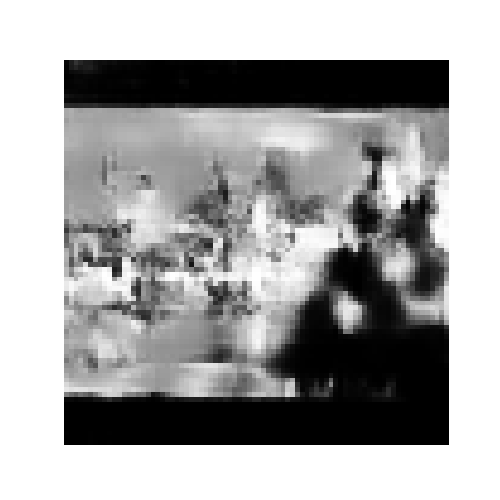

In [42]:
# Random Noise
noise = np.random.normal(0, 1, (1, gan.latent_dim))
gen_imgs = gan.generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

# Plot
fig = plt.figure(figsize=(5,5))
plt.imshow(gen_imgs[0, :,:,0], cmap='gray')
plt.axis("off")
plt.show()

# Animation Between Two Points in Latent Space

<IPython.core.display.Javascript object>


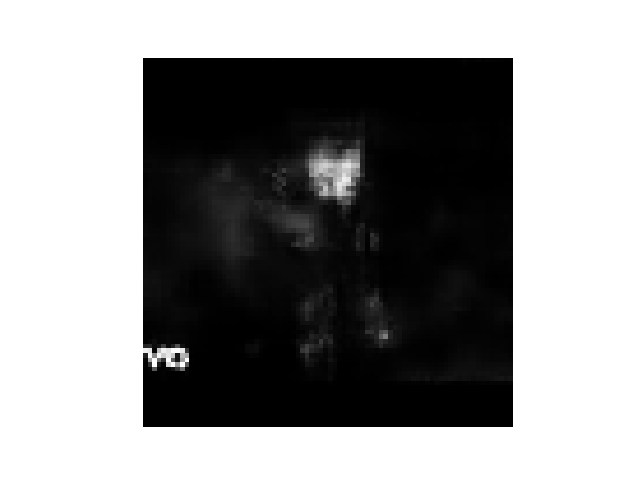

In [51]:
# For Jupyter
%matplotlib notebook

# Determining Unit Vector Between Two Point in Latent Space.
noise = np.random.normal(0, 1, (2, gan.latent_dim)) # Random two points
direction_between_points = (noise[1] - noise[0])
distance_between_points = np.linalg.norm(direction_between_points)
direction_of_noise = direction_between_points / distance_between_points
step = 100

# Interpolation Latent Space in N steps.
latent_space_animation = [noise[0]]

for _ in range(step):
    latent_space_animation.append(latent_space_animation[-1] + direction_of_noise * (distance_between_points/step))

# Interpolation to Image.
gen_imgs = gan.generator.predict(np.array(latent_space_animation))

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, ax = plt.subplots()
img_show = plt.imshow(gen_imgs[0, :,:,0], cmap='gray')

# Animation function
def update(frame):
    img_show.set_data(gen_imgs[frame, :,:,0])
    return img_show,
plt.axis('off')

ani = FuncAnimation(fig, update, frames=100, interval=20)
ani.save('latent_space.mp4')